## Functions

##### Initialization

In [1]:
!pip install -U matplotlib
!pip install -U statsmodels
!pip install pmdarima
!pip install scikit-posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 9.6 MB/s 
     |████████████████████████████████| 965 kB 51.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 8.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Forecast models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.sandbox.stats.multicomp import MultiComparison

# Scipy
from scipy import stats
from scipy.stats import f_oneway

# Scikit
import scikit_posthocs as sp

# Auto ARIMA
import pmdarima as pm

# Warnings
import warnings

# To register elapsed time
import time

# Save objects to files
import pickle

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Drive path
  %cd $drive_path

##### Read data

In [3]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [4]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [5]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [6]:
def prepare_time_series_univariate(df, price = "price_euro", interpolate_method = "linear"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df["price_euro"], method = interpolate_method)

  return df

##### Transform data series

In [7]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [8]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [9]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = id)["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes

  return df, product_id_ord

##### Missing values

In [10]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [11]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price):

  df = df.copy()

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro"):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price)

##### Performance Metrics

In [12]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

def get_nmse_sample(y_obs, y_pred):
  return np.sqrt((y_obs-y_pred)**2/y_obs**2)

In [13]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [14]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

def test_stationarity_dict(timeseries, stationary_tests, p_values_max):
  print(timeseries.name)
  
  p_values, test_results, is_stationary, is_overall_stationary = test_stationarity(timeseries, stationary_tests, p_values_max)
   
  info = {"ADF_p_values": p_values[0],
          "KPSS_p_values": p_values[1],
          "ADF_test_results": test_results[0],
          "KPSS_test_results": test_results[1],
          "ADF_is_stationary": is_stationary[0],
          "KPSS_is_stationary": is_stationary[1],
          "is_overall_stationary": is_overall_stationary}
           
  return info

##### Linear models

In [15]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  #if len(timeseries) <= 90:
  #  return np.nan

  timeseries_diff = diff_time_series(timeseries, diff_order)

  try:
    acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha, fft = True)
    pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)
  except np.linalg.LinAlgError: 
    return np.nan
  
  # The confidence interval is computed based on white noise (??), so the confidence interval (shaded blue area) is centered around the value of the correlation
  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1] - acf_coeff)  | (acf_coeff  < acf_confint[:,0] - acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]- pacf_coeff) | (pacf_coeff < pacf_confint[:,0] - pacf_coeff)).astype(int))

  acf_lags = acf_lags[1:]
  pacf_lags = pacf_lags[1:]

  return acf_lags, pacf_lags


def get_lags_and_coefs(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  if len(timeseries) <= 90:
    return np.nan

  timeseries_diff = diff_time_series(timeseries, diff_order)

  try:
    acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha, fft = True)
    pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)
  except np.linalg.LinAlgError: 
    return np.nan
  
  # The confidence interval is computed based on white noise (??), so the confidence interval (shaded blue area) is centered around the value of the correlation
  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1] - acf_coeff)  | (acf_coeff  < acf_confint[:,0] - acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]- pacf_coeff) | (pacf_coeff < pacf_confint[:,0] - pacf_coeff)).astype(int))

  acf_lags = acf_lags[1:]
  pacf_lags = pacf_lags[1:]

  acf_coeff = acf_coeff[1:]
  pacf_coeff = pacf_coeff[1:]

  return acf_lags, pacf_lags, acf_coeff, pacf_coeff

In [16]:
def plot_results(title, obs, pred, confint, fig_size, ax = None):
    
    if ax is None:
      # Graph
      fig, ax = plt.subplots(figsize=(fig_size))
    
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = confint
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    ax.set_ylim([min(obs)-50, max(obs)+50])
    return ax

##### Characteristics of timeseries

In [17]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

##### Save figure

In [18]:
def save_fig(plt, chapter_name, section_name, name_of_fig):
  path = 'Dissertação/Chapters/Imagens/Chapter_' + chapter_name + "/" + str.lower(chapter_name) + "_" + str.lower(section_name) + "_" + name_of_fig + "."
  print(path)
  plt.savefig(path + "svg")
  plt.savefig(path + "png", bbox_inches = "tight")
  plt.savefig(path + "pdf")

# Notebook: Basic_models

- **Goal**: implementation of simple models for short-term prediction of individual time series

In [19]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


## Read data

#### Read data

In [20]:
zip_name = "data/catalog_sample.zip"
file_name = "catalog_sample.json"
filetype = "json"
df_og = zip_2_dataframe(zip_name, file_name, filetype)

#### Read df_all

In [21]:
df_all = pd.read_pickle("df_all")

In [22]:
n_samples = df_all.dropna().groupby(by = "product_id").count().price_euro
n_changes = df_all.dropna()["diff"]
n_changes = n_changes[n_changes != 0].groupby(by = "product_id").count()
n_samples = n_samples.loc[n_changes.index]

In [23]:
min_n_changes = 5
min_n_samples = 90

n_changes_flt = n_changes[n_changes > min_n_changes]
n_samples_flt = n_samples.loc[n_changes_flt.index]
n_samples_flt = n_samples_flt[n_samples_flt > min_n_samples]
n_changes_flt = n_changes_flt.loc[n_samples_flt.index]
changes_samples_ratio_flt = n_changes_flt/n_samples_flt

In [24]:
df_flt = df_all.loc[n_changes_flt.index]
df_flt["price_euro_mv"] = df_flt["price_euro"].where(df_flt["out_of_stock"] == 0, np.nan) 
df_flt["diff_mv"] = df_flt["diff"].where(df_flt["out_of_stock"] == 0, np.nan)

#### Clean data and add unique identifiers to products, product groups and companies

In [25]:
df = clean_data(df_og.copy())
df = add_ids(df)

In [26]:
df

country_company  company_id  product_group_id  product_id  \
0         CL Falabella           1                 1           1   
1         CL Falabella           1                 1           1   
2         CL Falabella           1                 1           1   
3         CL Falabella           1                 1           1   
4         CL Falabella           1                 1           1   
...                ...         ...               ...         ...   
602051        CL claro          19               958        3222   
602052        CO Claro           5               958        3234   
602053         CO Tigo           3               958        3228   
602054     PE Movistar          23               960        3236   
602055        PE Claro          11               958        3233   

                       product country    company       price  timestamp  \
0       xiaomi Pocophone 128GB      CL  Falabella    $799,990 2020-07-22   
1       xiaomi Pocophone 128GB      CL  Falabella    $799,990 2020-07-21   
2       xiaomi Pocophone 128GB      CL  Falabella    $799,990 2020-07-20   
3       xiaomi Pocophone 128GB      CL  Falabella    $799,990 2020-07-19   
4       xiaomi Pocophone 128GB      CL  Falabella    $799,990 2020-07-18   
...                        ...     ...        ...         ...        ...   
602051        huawei Y9S 128GB      CL      claro    $229,990 2020-06-21   
602052        huawei Y9S 128GB      CO      Claro  $1,168,900 2020-06-21   
602053        huawei Y9S 128GB      CO       Tigo  $1,079,900 2020-06-21   
602054        huawei Y9S 128GB      PE   Movistar     S/1,519 2020-06-20   
602055        huawei Y9S 128GB      PE      Claro     S/1,139 2020-06-20   

                  offer_type currency  price_clean   price_euro  
0                   unlocked        $       799.99   727.726735  
1                   unlocked        $       799.99   727.726735  
2                   unlocked        $       799.99   727.726735  
3                   unlocked        $       799.99   727.726735  
4                   unlocked        $       799.99   727.726735  
...                      ...      ...          ...          ...  
602051              unlocked        $       229.99   209.214955  
602052              unlocked        $      1168.90  1063.313017  
602053              unlocked        $      1079.90   982.352406  
602054  postpaid_portability        S      1519.00   364.560000  
602055              unlocked        S      1139.00   273.360000  

[602056 rows x 13 columns]

#### Order products by number of changes in time series

In [27]:
df_changes, product_id_ord = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean")

counts = []
for i in range(min(df_changes), max(df_changes)):
  counts.append(len(df_changes[df_changes > i]))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(counts)
#ax.set_yscale('log')
plt.title("Nº of examples that have more than a certain number of changes");

ImportError: ignored

<Figure size 720x360 with 1 Axes>

In [28]:
df_changes[product_id_ord]

product_id
847     103
1606     93
2134     91
2010     89
1911     88
       ... 
1846      1
1844      1
1843      1
1829      1
1         0
Name: n_changes, Length: 3236, dtype: int64

## Visualize time series

In [ ]:
product_id = [product_id_ord[0]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  417


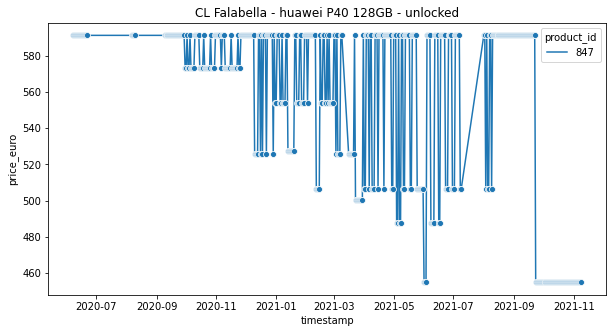

In [ ]:
show_time_series(df_product, "product_id", info)

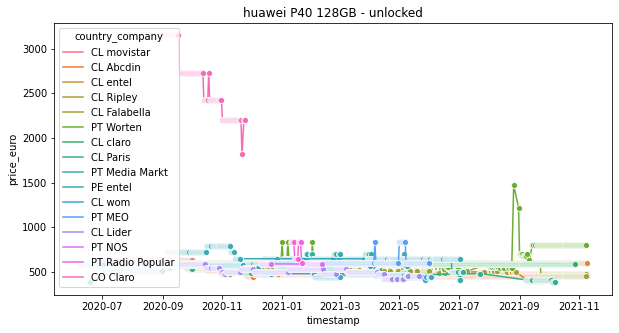

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

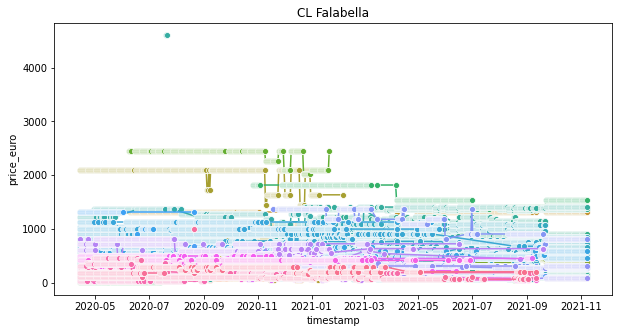

In [ ]:
df_company, info = select_time_series(df, "company_id", company_id)
show_time_series(df_company, "company_id", info)

In [ ]:
product_id = [product_id_ord[0]]

df["price_euro"].isna()

False

## ARIMA

In [ ]:
# Only series with at least 5 changes and a minimum of 90 samples will be analysed

### Introduction

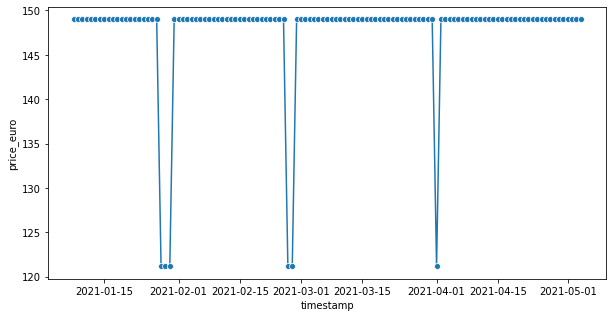

In [ ]:
product_id = product_id_ord[100]
product_id = 1512

set_fig_size((10, 5))
p = sns.lineplot(data = df_flt.loc[product_id], x = "timestamp", y = "price_euro", marker = 'o')

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1)


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


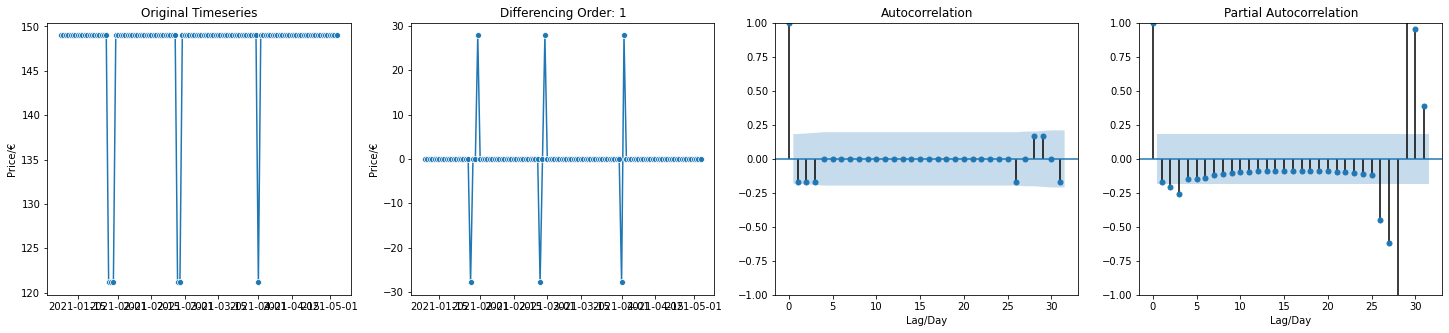

P-Values:  [4.199670593899558e-12, 0.1]
The timeseries is stationary.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
product_id = product_id_ord[100]
product_id = 1512

diff_order = 1

set_fig_size((25, 5))
fig, ax = plt.subplots(1,4)

# Original timeseries
p = sns.lineplot(data = df_flt.loc[product_id], x = "timestamp", y = "price_euro", ax = ax[0], marker = 'o')
p.set_title("Original Timeseries")
p.set_xlabel("")
p.set_ylabel("Price/€")

# Difference
sns_line = sns.lineplot(data = df_flt.loc[product_id], x = "timestamp", y = "diff", marker = 'o', ax = ax[1])
sns_line.set_title("Differencing Order: " + str(diff_order))
sns_line.set_xlabel("")
sns_line.set_ylabel("Price/€")

MA_lags, AR_lags = get_lags(df_flt.loc[product_id]["price_euro"], 1, nlags = 31)
print(MA_lags)
print(AR_lags)

# ACF and PACF
plot_acf(df_flt.loc[product_id]["diff"].dropna(), lags = 31, ax = ax[2], alpha = 0.05, fft = True)
ax[2].set_xlabel("Lag/Day")
p = plot_pacf(df_flt.loc[product_id]["diff"].dropna(), lags = 31, ax = ax[3], alpha = 0.05)
ax[3].set_xlabel("Lag/Day")

plt.show()

p_values_of_tests = test_stationarity(df_flt.loc[product_id]["diff"].dropna(), [adf_test, kpss_test], [0.05, 0.05])


Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_timeseriesDiffandACFs.


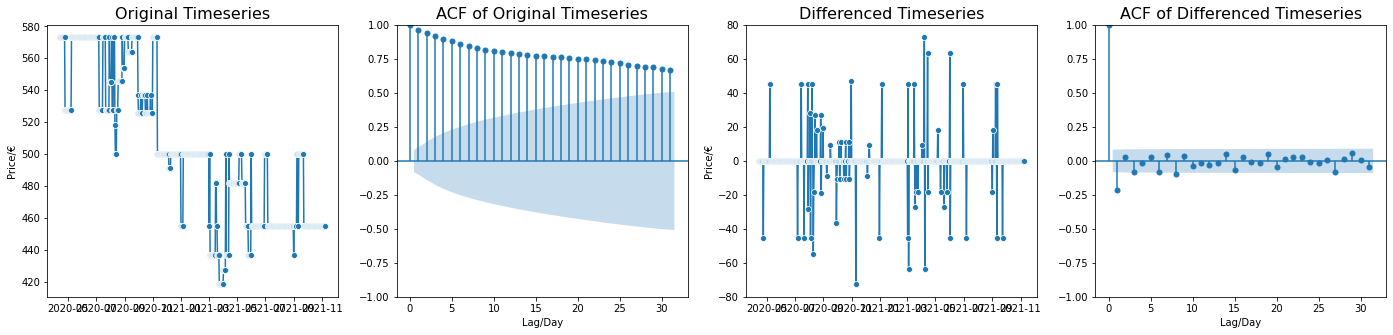

In [ ]:
product_id = product_id_ord[20]
#product_id = 18

fontsize = 16
n_subplots = 4
diff_order = 1
set_fig_size((n_subplots*6, 5))
fig, ax = plt.subplots(1,n_subplots)

# Original timeseries
p = sns.lineplot(data = df_flt.loc[product_id], x = "timestamp", y = "price_euro", ax = ax[0], marker = 'o')
p.set_title("Original Timeseries", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Price/€")

# ACF
plot_acf(df_flt.loc[product_id]["price_euro"], lags = 31, ax = ax[1], alpha = 0.05, fft = True)
ax[1].set_title("ACF of Original Timeseries", fontsize = fontsize)
ax[1].set_xlabel("Lag/Day")

# Differenced timeseries
sns_line = sns.lineplot(data = df_flt.loc[product_id], x = "timestamp", y = "diff", marker = 'o', ax = ax[2])
sns_line.set_title("Differenced Timeseries", fontsize = fontsize)
sns_line.set_xlabel("")
sns_line.set_ylabel("Price/€")

# ACF
plot_acf(df_flt.loc[product_id]["diff"].dropna(), lags = 31, ax = ax[3], alpha = 0.05, fft = True)
ax[3].set_title("ACF of Differenced Timeseries", fontsize = fontsize)
ax[3].set_xlabel("Lag/Day")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "timeseriesDiffandACFs")

plt.show()

### Stationarity

In [ ]:
# After applying first order differences, the timeseries become mainly stationary.

In [ ]:
stationary_tests = [adf_test, kpss_test]
p_values_max = [0.05, 0.05]

stationary_tests_results = pd.DataFrame(df_flt.groupby(by = "product_id")["price_euro"].apply(test_stationarity_dict, **{"stationary_tests": stationary_tests, "p_values_max": p_values_max})).unstack()
stationary_tests_results_diff = pd.DataFrame(df_flt.drop([1079, 2862, 3029]).dropna().groupby(by = "product_id", dropna = True)["diff"].apply(test_stationarity_dict, **{"stationary_tests": stationary_tests, "p_values_max": p_values_max})).unstack()
stationary_tests_results.columns = stationary_tests_results.columns.droplevel()
stationary_tests_results_diff.columns = stationary_tests_results_diff.columns.droplevel()

2
P-Values:  [0.33294667127386357, 0.01]
Can't confirm the series is stationary.
4
P-Values:  [0.8929409842913152, 0.026961568903320274]
Can't confirm the series is stationary.
12
P-Values:  [0.5590010509997749, 0.01]
Can't confirm the series is stationary.
18
P-Values:  [0.050076061805941235, 0.01]
Can't confirm the series is stationary.
20
P-Values:  [0.7791091404968213, 0.01]
Can't confirm the series is stationary.
21
P-Values:  [0.40509380627104496, 0.01]
Can't confirm the series is stationary.
24


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.45804463061107653, 0.01]
Can't confirm the series is stationary.
25
P-Values:  [0.1228071657626909, 0.1]
Can't confirm the series is stationary.
26
P-Values:  [0.30157302132341235, 0.01]
Can't confirm the series is stationary.
27
P-Values:  [0.00017285622333634227, 0.1]
The timeseries is stationary.
28
P-Values:  [0.1669319069743277, 0.01]
Can't confirm the series is stationary.
29
P-Values:  [0.18620270334689315, 0.01]
Can't confirm the series is stationary.
30


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.447590335407633, 0.01]
Can't confirm the series is stationary.
32
P-Values:  [0.5748456690616489, 0.01]
Can't confirm the series is stationary.
33
P-Values:  [0.6144994226647357, 0.01]
Can't confirm the series is stationary.
34
P-Values:  [0.5658811877909558, 0.01]
Can't confirm the series is stationary.
36
P-Values:  [0.9016820105592133, 0.09726811939315923]
Can't confirm the series is stationary.
37
P-Values:  [0.001333575113685014, 0.024775268636230252]
Can't confirm the series is stationary.
38
P-Values:  [0.6405467303379702, 0.01]
Can't confirm the series is stationary.
40
P-Values:  [0.08569854441086949, 0.1]
Can't confirm the series is stationary.
42


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.6849702463383018, 0.01]
Can't confirm the series is stationary.
43
P-Values:  [0.3106263310265484, 0.021740386563848066]
Can't confirm the series is stationary.
58
P-Values:  [0.2046843769134768, 0.046096475848950075]
Can't confirm the series is stationary.
73
P-Values:  [0.7994373093464885, 0.01]
Can't confirm the series is stationary.
74
P-Values:  [0.5075337067093265, 0.023118596509902264]
Can't confirm the series is stationary.
77
P-Values:  [0.9911446493342092, 0.1]
Can't confirm the series is stationary.
79
P-Values:  [0.028487684995958686, 0.01]
Can't confirm the series is stationary.
83


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4742567552735411, 0.01]
Can't confirm the series is stationary.
84
P-Values:  [0.004316015010430197, 0.01]
Can't confirm the series is stationary.
89
P-Values:  [0.9892097863450463, 0.01]
Can't confirm the series is stationary.
90
P-Values:  [0.2886092666581168, 0.01]
Can't confirm the series is stationary.
92
P-Values:  [0.3697676517819434, 0.01]
Can't confirm the series is stationary.
93


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.8183223367740662, 0.01]
Can't confirm the series is stationary.
94
P-Values:  [0.09164402337553612, 0.01]
Can't confirm the series is stationary.
95
P-Values:  [0.0002741596400628836, 0.01]
Can't confirm the series is stationary.
96
P-Values:  [0.21516183411289985, 0.01]
Can't confirm the series is stationary.
97
P-Values:  [0.04998134671636222, 0.08126622926541233]
The timeseries is stationary.
98


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.5641615211091222, 0.01]
Can't confirm the series is stationary.
100
P-Values:  [0.7127423375716286, 0.01]
Can't confirm the series is stationary.
102
P-Values:  [0.3781429983072047, 0.01]
Can't confirm the series is stationary.
103
P-Values:  [0.34957124113684584, 0.01]
Can't confirm the series is stationary.
104
P-Values:  [0.33082803149171197, 0.01]
Can't confirm the series is stationary.
105
P-Values:  [0.0062880084788117605, 0.01]
Can't confirm the series is stationary.
106


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.3647922436501279, 0.01]
Can't confirm the series is stationary.
107
P-Values:  [2.2802614144404412e-05, 0.01]
Can't confirm the series is stationary.
109
P-Values:  [0.14040979531231113, 0.01]
Can't confirm the series is stationary.
110
P-Values:  [0.10575345623487381, 0.1]
Can't confirm the series is stationary.
112
P-Values:  [1.9823029544817555e-08, 0.010726915837360842]
Can't confirm the series is stationary.
113
P-Values:  [0.7701645446338319, 0.01]
Can't confirm the series is stationary.
114
P-Values:  [0.890878725296922, 0.01]
Can't confirm the series is stationary.
115


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.5484349312229617, 0.01]
Can't confirm the series is stationary.
132
P-Values:  [0.009070671480729429, 0.1]
The timeseries is stationary.
136
P-Values:  [0.08734024847964317, 0.01]
Can't confirm the series is stationary.
138
P-Values:  [0.7434143874347212, 0.01]
Can't confirm the series is stationary.
145
P-Values:  [0.046064995181119006, 0.01]
Can't confirm the series is stationary.
148
P-Values:  [0.2643670757586005, 0.01]
Can't confirm the series is stationary.
161
P-Values:  [0.18146925900156058, 0.01]
Can't confirm the series is stationary.
163
P-Values:  [0.5482660678869729, 0.01]
Can't confirm the series is stationary.
164

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning


P-Values:  [0.0019242373853308667, 0.1]
The timeseries is stationary.
166
P-Values:  [0.006765526932533824, 0.014963325995261512]
Can't confirm the series is stationary.
168
P-Values:  [0.3716905528118569, 0.01]
Can't confirm the series is stationary.
179
P-Values:  [0.00994891307413433, 0.01]
Can't confirm the series is stationary.
189
P-Values:  [1.3895314572021198e-09, 0.1]
The timeseries is stationary.
193
P-Values:  [0.6819706188962522, 0.01]
Can't confirm the series is stationary.
194


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.6555888050785245, 0.01]
Can't confirm the series is stationary.
195
P-Values:  [0.5140937607762683, 0.01]
Can't confirm the series is stationary.
196
P-Values:  [0.14419871780238253, 0.07795967645069359]
Can't confirm the series is stationary.
198
P-Values:  [0.34603013445137815, 0.01]
Can't confirm the series is stationary.
200
P-Values:  [0.08623374179200471, 0.1]
Can't confirm the series is stationary.
201
P-Values:  [0.5610746186298603, 0.01]
Can't confirm the series is stationary.
202


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.1368240576833062, 0.021986117530403783]
Can't confirm the series is stationary.
203
P-Values:  [0.46023048556897467, 0.01]
Can't confirm the series is stationary.
204
P-Values:  [0.11159144547164163, 0.01]
Can't confirm the series is stationary.
205
P-Values:  [0.9189621470980249, 0.01]
Can't confirm the series is stationary.
206
P-Values:  [0.010654771285811125, 0.07526565394077787]
The timeseries is stationary.
207
P-Values:  [0.9749368467363287, 0.01]
Can't confirm the series is stationary.
208
P-Values:  [0.09984315295201507, 0.01]
Can't confirm the series is stationary.
212
P-Values:  [0.25368118261771455, 0.1]
Can't confirm the series is stationary.
225
P-Values:  [0.7234713572413214, 0.01]
Can't confirm the series is stationary.
228


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.04659542103063819, 0.01]
Can't confirm the series is stationary.
229
P-Values:  [0.05594198295211921, 0.01]
Can't confirm the series is stationary.
232
P-Values:  [0.06382784704803425, 0.01]
Can't confirm the series is stationary.
233
P-Values:  [0.026701821529814037, 0.01]
Can't confirm the series is stationary.
234
P-Values:  [0.1573299838592444, 0.01]
Can't confirm the series is stationary.
237
P-Values:  [0.14239224933627137, 0.1]
Can't confirm the series is stationary.
239
P-Values:  [0.03182344346154387, 0.0660840576311309]
The timeseries is stationary.
244


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2776207382245688, 0.01]
Can't confirm the series is stationary.
262
P-Values:  [0.3083357587505977, 0.01]
Can't confirm the series is stationary.
295
P-Values:  [0.15241948167713498, 0.01]
Can't confirm the series is stationary.
299
P-Values:  [2.678979948046687e-07, 0.019162286812239374]
Can't confirm the series is stationary.
301
P-Values:  [0.01387465058375967, 0.1]
The timeseries is stationary.
304
P-Values:  [0.028903758274479475, 0.1]
The timeseries is stationary.
305
P-Values:  [4.245876867076229e-06, 0.023806727300854345]
Can't confirm the series is stationary.
306
P-Values:  [0.05576934064069497, 0.01]
Can't confirm the series is stationary.
307
P-Values:  [0.02742660149835808, 0.01]
Can't confirm the series is stationary.
309
P-Values:  [0.24801244648828596, 0.1]
Can't confirm the series is stationary.
319


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.17341925929795177, 0.01]
Can't confirm the series is stationary.
320
P-Values:  [0.4870833515068016, 0.01]
Can't confirm the series is stationary.
325
P-Values:  [0.2522046493404124, 0.034789534530668895]
Can't confirm the series is stationary.
328
P-Values:  [0.8823627945308741, 0.01]
Can't confirm the series is stationary.
334
P-Values:  [0.8569899292616932, 0.1]
Can't confirm the series is stationary.
350
P-Values:  [0.9750026380984658, 0.01]
Can't confirm the series is stationary.
353
P-Values:  [0.015244776171579703, 0.01]
Can't confirm the series is stationary.
355
P-Values:  [0.009816618349062702, 0.01]
Can't confirm the series is stationary.
362
P-Values:  [0.6865151052959182, 0.01]
Can't confirm the series is stationary.
363


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.8643334005821754, 0.01]
Can't confirm the series is stationary.
365
P-Values:  [0.5690696543419995, 0.01]
Can't confirm the series is stationary.
367
P-Values:  [0.8647459654240246, 0.01]
Can't confirm the series is stationary.
368
P-Values:  [0.6942472210186552, 0.01]
Can't confirm the series is stationary.
370
P-Values:  [0.8740349708446059, 0.01]
Can't confirm the series is stationary.
371
P-Values:  [0.00013418281490322468, 0.01]
Can't confirm the series is stationary.
372
P-Values:  [0.6209291815972132, 0.01]
Can't confirm the series is stationary.
374
P-Values:  [2.216329666717881e-09, 0.1]
The timeseries is stationary.
389


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.3216416733713009, 0.01]
Can't confirm the series is stationary.
390
P-Values:  [0.09729371932339753, 0.01]
Can't confirm the series is stationary.
393
P-Values:  [0.6234157981234436, 0.01]
Can't confirm the series is stationary.
394
P-Values:  [0.4499790576226638, 0.06210836767182346]
Can't confirm the series is stationary.
395
P-Values:  [0.0010842115973562936, 0.01]
Can't confirm the series is stationary.
398
P-Values:  [0.030244750380966492, 0.1]
The timeseries is stationary.
399
P-Values:  [0.33846425925690865, 0.1]
Can't confirm the series is stationary.
400


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.2457386305644192, 0.1]
Can't confirm the series is stationary.
404
P-Values:  [8.47730366790171e-05, 0.1]
The timeseries is stationary.
410
P-Values:  [8.620775867808049e-05, 0.1]
The timeseries is stationary.
414
P-Values:  [0.44522673545287894, 0.01]
Can't confirm the series is stationary.
416
P-Values:  [0.6570344117320215, 0.01]
Can't confirm the series is stationary.
417
P-Values:  [0.44691681207961714, 0.01]
Can't confirm the series is stationary.
418
P-Values:  [0.9317306940815999, 0.01]
Can't confirm the series is stationary.
419


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.004830395456702862, 0.01]
Can't confirm the series is stationary.
421
P-Values:  [0.9912230979907534, 0.01]
Can't confirm the series is stationary.
423
P-Values:  [0.9248476351105108, 0.019780236053473]
Can't confirm the series is stationary.
428
P-Values:  [0.5623452471947703, 0.01]
Can't confirm the series is stationary.
429
P-Values:  [0.5792278645533104, 0.01]
Can't confirm the series is stationary.
431
P-Values:  [0.5345583655902358, 0.012147706066151192]
Can't confirm the series is stationary.
432
P-Values:  [0.0594772537085723, 0.01]
Can't confirm the series is stationary.
447
P-Values:  [0.7801832933132773, 0.01]
Can't confirm the series is stationary.
453


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2051156272517759, 0.01]
Can't confirm the series is stationary.
455
P-Values:  [3.4475516960291875e-08, 0.01]
Can't confirm the series is stationary.
457
P-Values:  [0.565328356326694, 0.05419395849659702]
Can't confirm the series is stationary.
458
P-Values:  [0.2011806767864105, 0.01]
Can't confirm the series is stationary.
459
P-Values:  [0.5683037555759959, 0.017976258998514284]
Can't confirm the series is stationary.
460
P-Values:  [0.9989724142139129, 0.01]
Can't confirm the series is stationary.
462
P-Values:  [2.2098811621641663e-09, 0.1]
The timeseries is stationary.
468
P-Values:  [0.0347327437964684, 0.01]
Can't confirm the series is stationary.
469


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.20298464223962437, 0.01]
Can't confirm the series is stationary.
470
P-Values:  [0.6830053024338631, 0.01]
Can't confirm the series is stationary.
471
P-Values:  [0.48542287707595944, 0.01]
Can't confirm the series is stationary.
473
P-Values:  [0.017300292493125955, 0.1]
The timeseries is stationary.
474
P-Values:  [0.3701798261941444, 0.01]
Can't confirm the series is stationary.
477
P-Values:  [0.00024379119440829652, 0.1]
The timeseries is stationary.
478
P-Values:  [0.19539762371566816, 0.01]
Can't confirm the series is stationary.
479


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [1.480278433659538e-07, 0.01]
Can't confirm the series is stationary.
480
P-Values:  [0.00017909396778050167, 0.01]
Can't confirm the series is stationary.
481
P-Values:  [0.012310032449246475, 0.01]
Can't confirm the series is stationary.
482
P-Values:  [1.87673859592386e-09, 0.01]
Can't confirm the series is stationary.
484
P-Values:  [0.3639853877026369, 0.01]
Can't confirm the series is stationary.
485
P-Values:  [0.8893917144854482, 0.01]
Can't confirm the series is stationary.
490


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.12833720302760337, 0.06804426541620212]
Can't confirm the series is stationary.
495
P-Values:  [0.6668111899758149, 0.07609396424029273]
Can't confirm the series is stationary.
496
P-Values:  [0.19413573845585058, 0.01]
Can't confirm the series is stationary.
499
P-Values:  [0.2583749936580576, 0.01]
Can't confirm the series is stationary.
500
P-Values:  [0.0004434963403945597, 0.01]
Can't confirm the series is stationary.
503
P-Values:  [0.13346059741532523, 0.06787265690300934]
Can't confirm the series is stationary.
506
P-Values:  [0.14249523755761456, 0.01]
Can't confirm the series is stationary.
511
P-Values:  [0.0882332258114043, 0.01]
Can't confirm the series is stationary.
512
P-Values:  [0.42050425973801914, 0.01]
Can't confirm the series is stationary.
515
P-Values:  [0.907449399550587, 0.01]
Can't confirm the series is stationary.
518


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.7277074491844138, 0.01]
Can't confirm the series is stationary.
521
P-Values:  [0.4597308348772171, 0.01]
Can't confirm the series is stationary.
522
P-Values:  [0.14078987180614422, 0.01]
Can't confirm the series is stationary.
523
P-Values:  [0.02455021708302101, 0.048420912753311764]
Can't confirm the series is stationary.
525
P-Values:  [0.6522296656601905, 0.01]
Can't confirm the series is stationary.
526


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.13089354128760855, 0.01]
Can't confirm the series is stationary.
527
P-Values:  [0.2597732711214846, 0.01]
Can't confirm the series is stationary.
528
P-Values:  [0.09645545798059774, 0.01]
Can't confirm the series is stationary.
529
P-Values:  [2.559561767365788e-09, 0.01]
Can't confirm the series is stationary.
530
P-Values:  [0.760639988930053, 0.01]
Can't confirm the series is stationary.
532
P-Values:  [0.6772808854322402, 0.01]
Can't confirm the series is stationary.
535
P-Values:  [2.080654379890293e-21, 0.01]
Can't confirm the series is stationary.
540


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4306813821958782, 0.01]
Can't confirm the series is stationary.
541
P-Values:  [0.48545348226922563, 0.01]
Can't confirm the series is stationary.
543
P-Values:  [0.6822710028242349, 0.01]
Can't confirm the series is stationary.
548
P-Values:  [0.11176605604402201, 0.03722999246365185]
Can't confirm the series is stationary.
549
P-Values:  [0.001884387207178512, 0.07641694419975725]
The timeseries is stationary.
551
P-Values:  [0.9301693321274846, 0.01]
Can't confirm the series is stationary.
559
P-Values:  [0.0001544120029971925, 0.09854412780762317]
The timeseries is stationary.
562


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.7429169184275295, 0.01]
Can't confirm the series is stationary.
563
P-Values:  [0.05893907608186173, 0.01]
Can't confirm the series is stationary.
565
P-Values:  [0.03414537270859468, 0.01]
Can't confirm the series is stationary.
568
P-Values:  [4.023741624060074e-05, 0.08405382528423068]
The timeseries is stationary.
572
P-Values:  [0.499580905002921, 0.01]
Can't confirm the series is stationary.
576
P-Values:  [0.20737471094875148, 0.01]
Can't confirm the series is stationary.
577
P-Values:  [0.16830672929786877, 0.01]
Can't confirm the series is stationary.
578
P-Values:  [0.16019634488432266, 0.01]
Can't confirm the series is stationary.
580
P-Values:  [0.30940764622541456, 0.034097672590516]
Can't confirm the series is stationary.
581


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.15870941369056418, 0.1]
Can't confirm the series is stationary.
582
P-Values:  [0.011320336805241292, 0.022489058425076345]
Can't confirm the series is stationary.
583
P-Values:  [0.009420260197976957, 0.02073784302073029]
Can't confirm the series is stationary.
584
P-Values:  [0.17267162196136387, 0.01]
Can't confirm the series is stationary.
585
P-Values:  [0.1104724185680756, 0.1]
Can't confirm the series is stationary.
586
P-Values:  [0.2634242159409842, 0.01]
Can't confirm the series is stationary.
588
P-Values:  [5.2087275305985946e-05, 0.09738370688205111]
The timeseries is stationary.
589
P-Values:  [0.36815209453857856, 0.01]
Can't confirm the series is stationary.
590
P-Values:  [0.0003319820831118486, 0.1]
The timeseries is stationary.
591
P-Values:  [0.09640157036035657, 0.01]
Can't confirm the series is stationary.
593


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.3662625753051928, 0.01]
Can't confirm the series is stationary.
598
P-Values:  [0.0005245397083935904, 0.013545596191830036]
Can't confirm the series is stationary.
599
P-Values:  [0.824279763490954, 0.01]
Can't confirm the series is stationary.
600
P-Values:  [0.30891562110821935, 0.01]
Can't confirm the series is stationary.
601


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [1.0358149740388452e-05, 0.1]
The timeseries is stationary.
602
P-Values:  [0.09381300419055805, 0.1]
Can't confirm the series is stationary.
603
P-Values:  [0.4608417069321086, 0.01]
Can't confirm the series is stationary.
604
P-Values:  [0.44132294895986435, 0.01]
Can't confirm the series is stationary.
606
P-Values:  [0.13719725548197897, 0.01]
Can't confirm the series is stationary.
607
P-Values:  [0.952688666124597, 0.1]
Can't confirm the series is stationary.
611


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.06740308123008139, 0.01]
Can't confirm the series is stationary.
612
P-Values:  [0.2574873262500347, 0.01]
Can't confirm the series is stationary.
614
P-Values:  [0.5310825118935492, 0.01575244174784214]
Can't confirm the series is stationary.
615
P-Values:  [1.0537135099528084e-15, 0.1]
The timeseries is stationary.
616
P-Values:  [0.3070292276223808, 0.01]
Can't confirm the series is stationary.
617
P-Values:  [0.22609349814634527, 0.01]
Can't confirm the series is stationary.
618
P-Values:  [0.22766870678347256, 0.024918397743507934]
Can't confirm the series is stationary.
630
P-Values:  [0.4630482160816322, 0.01]
Can't confirm the series is stationary.
637
P-Values:  [4.826093491033188e-08, 0.1]
The timeseries is stationary.
638
P-Values:  [0.8897568754683531, 0.01]
Can't confirm the series is stationary.
639


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.3410678911077305, 0.01]
Can't confirm the series is stationary.
645
P-Values:  [0.5068363114260606, 0.01]
Can't confirm the series is stationary.
649
P-Values:  [0.0007963776187111742, 0.01]
Can't confirm the series is stationary.
650
P-Values:  [0.05570100542689239, 0.1]
Can't confirm the series is stationary.
651
P-Values:  [0.09733952352650033, 0.01]
Can't confirm the series is stationary.
654
P-Values:  [0.3930555914970366, 0.01]
Can't confirm the series is stationary.
655
P-Values:  [0.09562876343940857, 0.01]
Can't confirm the series is stationary.
657
P-Values:  [0.23879974249556396, 0.01]
Can't confirm the series is stationary.
658


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.08222435838629993, 0.05286445720375199]
Can't confirm the series is stationary.
670
P-Values:  [0.007824777161407372, 0.01]
Can't confirm the series is stationary.
678
P-Values:  [0.20094681888934962, 0.03984894981646832]
Can't confirm the series is stationary.
690
P-Values:  [0.4316605078592673, 0.01]
Can't confirm the series is stationary.
691
P-Values:  [0.008426403607852764, 0.012175994030754091]
Can't confirm the series is stationary.
692
P-Values:  [0.5220408770307138, 0.01]
Can't confirm the series is stationary.
693
P-Values:  [0.18728605068483473, 0.01]
Can't confirm the series is stationary.
694
P-Values:  [0.009771105179800356, 0.01]
Can't confirm the series is stationary.
695
P-Values:  [0.09071866285373326, 0.01]
Can't confirm the series is stationary.
696


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2209356390908967, 0.01]
Can't confirm the series is stationary.
698
P-Values:  [0.08700873815217336, 0.08176230611817695]
Can't confirm the series is stationary.
699
P-Values:  [0.0010263169650288008, 0.01]
Can't confirm the series is stationary.
700
P-Values:  [6.380535962115835e-05, 0.01]
Can't confirm the series is stationary.
701
P-Values:  [1.742719662301427e-05, 0.1]
The timeseries is stationary.
702
P-Values:  [0.040400377035557294, 0.1]
The timeseries is stationary.
703
P-Values:  [0.5936266696919998, 0.01]
Can't confirm the series is stationary.
704
P-Values:  [0.17607600464919237, 0.01]
Can't confirm the series is stationary.
705
P-Values:  [1.7446232515512397e-05, 0.01]
Can't confirm the series is stationary.
708


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [3.0513551430802203e-26, 0.01]
Can't confirm the series is stationary.
709
P-Values:  [0.25523220617846926, 0.01]
Can't confirm the series is stationary.
711
P-Values:  [0.46693879349999345, 0.01]
Can't confirm the series is stationary.
712
P-Values:  [0.30475394276688494, 0.01]
Can't confirm the series is stationary.
718
P-Values:  [0.8351775736751039, 0.01]
Can't confirm the series is stationary.
719
P-Values:  [0.01782154562383629, 0.1]
The timeseries is stationary.
724
P-Values:  [0.758491622014426, 0.01]
Can't confirm the series is stationary.
725
P-Values:  [0.0012821362677712174, 0.01]
Can't confirm the series is stationary.
726
P-Values:  [0.0014704794495104616, 0.1]
The timeseries is stationary.
728
P-Values:  [0.6707136271927072, 0.01]
Can't confirm the series is stationary.
732


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0002222608570379049, 0.1]
The timeseries is stationary.
738
P-Values:  [0.3635671331504801, 0.01]
Can't confirm the series is stationary.
739
P-Values:  [0.44539471858525204, 0.01]
Can't confirm the series is stationary.
740
P-Values:  [0.004808663131421309, 0.029396808583266893]
Can't confirm the series is stationary.
741
P-Values:  [0.00287417777017776, 0.01]
Can't confirm the series is stationary.
742
P-Values:  [0.40816133516100483, 0.1]
Can't confirm the series is stationary.
746
P-Values:  [0.8600005931510423, 0.01]
Can't confirm the series is stationary.
747
P-Values:  [0.5554727700699786, 0.1]
Can't confirm the series is stationary.
749
P-Values:  [0.009072753597261202, 0.1]
The timeseries is stationary.
750
P-Values:  [0.05413666095126133, 0.01]
Can't confirm the series is stationary.
752


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [6.452389173390726e-12, 0.1]
The timeseries is stationary.
753
P-Values:  [0.35386315634100884, 0.01]
Can't confirm the series is stationary.
758
P-Values:  [0.011300798153957552, 0.018829954833456355]
Can't confirm the series is stationary.
759
P-Values:  [0.10968791574033632, 0.01]
Can't confirm the series is stationary.
760
P-Values:  [0.08385708823557741, 0.010767014459959132]
Can't confirm the series is stationary.
761
P-Values:  [0.47539419411677053, 0.01]
Can't confirm the series is stationary.
762
P-Values:  [0.47499068361778596, 0.01]
Can't confirm the series is stationary.
767
P-Values:  [0.08427007613291804, 0.01]
Can't confirm the series is stationary.
771
P-Values:  [0.4507399818640217, 0.08902018099915]
Can't confirm the series is stationary.
773


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [2.8446779301434688e-05, 0.1]
The timeseries is stationary.
777
P-Values:  [0.010369979042144374, 0.1]
The timeseries is stationary.
786
P-Values:  [0.04017786711752975, 0.01]
Can't confirm the series is stationary.
787
P-Values:  [0.7678630397846541, 0.01]
Can't confirm the series is stationary.
788
P-Values:  [0.13255421901694092, 0.0436556345487442]
Can't confirm the series is stationary.
789
P-Values:  [0.22539615612241753, 0.04405775085968165]
Can't confirm the series is stationary.
790


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.04434208210281489, 0.01]
Can't confirm the series is stationary.
792
P-Values:  [0.2814073319714474, 0.01]
Can't confirm the series is stationary.
793
P-Values:  [0.4272711313882121, 0.01]
Can't confirm the series is stationary.
795
P-Values:  [0.4289385500748824, 0.01]
Can't confirm the series is stationary.
798
P-Values:  [0.015728828719647762, 0.0887352184426263]
The timeseries is stationary.
799
P-Values:  [0.701607628500724, 0.01]
Can't confirm the series is stationary.
800
P-Values:  [0.2331783762464017, 0.020540716123775695]
Can't confirm the series is stationary.
801


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2642663700688336, 0.01]
Can't confirm the series is stationary.
802
P-Values:  [0.45271796303822487, 0.01]
Can't confirm the series is stationary.
803
P-Values:  [0.10878239965312303, 0.08025825735194418]
Can't confirm the series is stationary.
804
P-Values:  [0.6253679158013317, 0.01]
Can't confirm the series is stationary.
805
P-Values:  [0.1326423963685271, 0.01]
Can't confirm the series is stationary.
806
P-Values:  [0.0008874973802143528, 0.01]
Can't confirm the series is stationary.
809
P-Values:  [0.7828299153591601, 0.01]
Can't confirm the series is stationary.
814
P-Values:  [0.04593548973786762, 0.01]
Can't confirm the series is stationary.
815
P-Values:  [0.2299886630902609, 0.1]
Can't confirm the series is stationary.
817
P-Values:  [0.22717990813380173, 0.01]
Can't confirm the series is stationary.
818
P-Values:  [0.6073689662973711, 0.01]
Can't confirm the series is stationary.
828


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.8562782584312735, 0.01]
Can't confirm the series is stationary.
829
P-Values:  [0.1796590670215305, 0.01]
Can't confirm the series is stationary.
830
P-Values:  [0.44602027133365574, 0.01]
Can't confirm the series is stationary.
831
P-Values:  [0.13123645755733093, 0.06398248287859756]
Can't confirm the series is stationary.
832
P-Values:  [0.35555431801161735, 0.01]
Can't confirm the series is stationary.
833
P-Values:  [0.0004392697204054657, 0.01]
Can't confirm the series is stationary.
835
P-Values:  [0.0005430302015892518, 0.01]
Can't confirm the series is stationary.
838
P-Values:  [0.455697308457599, 0.01]
Can't confirm the series is stationary.
839
P-Values:  [0.17832934346447765, 0.01]
Can't confirm the series is stationary.
840


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.053317896835958396, 0.01]
Can't confirm the series is stationary.
843
P-Values:  [0.32755361273701306, 0.01]
Can't confirm the series is stationary.
844
P-Values:  [0.003993010871858185, 0.01]
Can't confirm the series is stationary.
846
P-Values:  [0.3351721530515087, 0.01]
Can't confirm the series is stationary.
847
P-Values:  [0.43546233170486837, 0.01]
Can't confirm the series is stationary.
848
P-Values:  [0.004667953162173424, 0.01]
Can't confirm the series is stationary.
850


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.5288456393236163, 0.01]
Can't confirm the series is stationary.
852
P-Values:  [0.4925256926180875, 0.04512753503729388]
Can't confirm the series is stationary.
857
P-Values:  [0.606397634673346, 0.01]
Can't confirm the series is stationary.
861
P-Values:  [0.9467205877798683, 0.01]
Can't confirm the series is stationary.
867
P-Values:  [0.013436726089837559, 0.01]
Can't confirm the series is stationary.
869
P-Values:  [0.23057098111603708, 0.01]
Can't confirm the series is stationary.
870
P-Values:  [0.05864240015382403, 0.01]
Can't confirm the series is stationary.
876
P-Values:  [0.36280279875469823, 0.017527511624294587]
Can't confirm the series is stationary.
883
P-Values:  [0.06309985910976079, 0.01]
Can't confirm the series is stationary.
890
P-Values:  [0.07298915821104993, 0.01]
Can't confirm the series is stationary.
915


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.8386992947247385, 0.01]
Can't confirm the series is stationary.
918
P-Values:  [1.0249367967318183e-13, 0.1]
The timeseries is stationary.
919
P-Values:  [8.52558358190494e-05, 0.1]
The timeseries is stationary.
920
P-Values:  [4.060607573732137e-09, 0.1]
The timeseries is stationary.
923
P-Values:  [0.6543261884431012, 0.01]
Can't confirm the series is stationary.
925
P-Values:  [0.17872754703602428, 0.01]
Can't confirm the series is stationary.
927
P-Values:  [0.8047916881973181, 0.01]
Can't confirm the series is stationary.
928
P-Values:  [0.47119913910968647, 0.01]
Can't confirm the series is stationary.
932
P-Values:  [0.7324096232422348, 0.01]
Can't confirm the series is stationary.
933
P-Values:  [0.4718278707661266, 0.01]
Can't confirm the series is stationary.
934
P-Values:  [0.8375330059816382, 0.01]
Can't confirm the series is stationary.
935
P-Values:  [0.5491716053620487, 0.01]
Can't confirm the series is stationary.
936
P-Values:  [0.5633758695931819, 0.01]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.6771873087744806, 0.01]
Can't confirm the series is stationary.
943
P-Values:  [5.6092772788980285e-09, 0.01]
Can't confirm the series is stationary.
945
P-Values:  [0.7837957821102031, 0.01]
Can't confirm the series is stationary.
948
P-Values:  [0.011911277856396008, 0.08157802619749185]
The timeseries is stationary.
950
P-Values:  [9.037483554843765e-23, 0.1]
The timeseries is stationary.
964
P-Values:  [0.03302650274180384, 0.01]
Can't confirm the series is stationary.
969
P-Values:  [0.14689133554022688, 0.01]
Can't confirm the series is stationary.
971
P-Values:  [0.009994537968345157, 0.01794980722885313]
Can't confirm the series is stationary.
972
P-Values:  [0.9266987091101895, 0.01]
Can't confirm the series is stationary.
974
P-Values:  [0.028944414670542647, 0.017613426180623882]
Can't confirm the series is stationary.
975


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.12515036760506348, 0.01]
Can't confirm the series is stationary.
976
P-Values:  [0.2812724160088436, 0.1]
Can't confirm the series is stationary.
977
P-Values:  [0.2551959752173234, 0.01]
Can't confirm the series is stationary.
979
P-Values:  [0.3879216337961377, 0.1]
Can't confirm the series is stationary.
997
P-Values:  [0.8141726583906173, 0.01]
Can't confirm the series is stationary.
998
P-Values:  [0.0670327503185559, 0.01]
Can't confirm the series is stationary.
1008
P-Values:  [0.7544382652339003, 0.01]
Can't confirm the series is stationary.
1009
P-Values:  [0.9016622921096179, 0.01]
Can't confirm the series is stationary.
1010
P-Values:  [0.29084052170773184, 0.01]
Can't confirm the series is stationary.
1012
P-Values:  [0.7277416632950434, 0.01]
Can't confirm the series is stationary.
1013


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.5208128328498134, 0.01]
Can't confirm the series is stationary.
1015
P-Values:  [0.722490349237368, 0.01]
Can't confirm the series is stationary.
1018
P-Values:  [0.34239735423823214, 0.01]
Can't confirm the series is stationary.
1019
P-Values:  [0.04432222179873885, 0.01]
Can't confirm the series is stationary.
1021
P-Values:  [0.14519378395000582, 0.03947127391939915]
Can't confirm the series is stationary.
1025
P-Values:  [0.387801819768698, 0.013988692361516978]
Can't confirm the series is stationary.
1028
P-Values:  [0.007281350724408724, 0.1]
The timeseries is stationary.
1029
P-Values:  [0.8852079420260307, 0.01]
Can't confirm the series is stationary.
1032
P-Values:  [0.024789767032760285, 0.1]
The timeseries is stationary.
1033
P-Values:  [0.0001240078094796092, 0.01]
Can't confirm the series is stationary.
1037


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.209881162163794e-09, 0.1]
The timeseries is stationary.
1047
P-Values:  [0.6236488832992055, 0.01]
Can't confirm the series is stationary.
1050
P-Values:  [0.4530463364329106, 0.01]
Can't confirm the series is stationary.
1075
P-Values:  [0.48554765872428224, 0.01]
Can't confirm the series is stationary.
1077
P-Values:  [0.6493845036986535, 0.01]
Can't confirm the series is stationary.
1078
P-Values:  [0.31332520416244514, 0.01]
Can't confirm the series is stationary.
1079
P-Values:  [7.757934241037335e-06, 0.1]
The timeseries is stationary.
1081
P-Values:  [1.7653472121690558e-09, 0.01]
Can't confirm the series is stationary.
1082


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [2.5815200988143916e-07, 0.021292047006001]
Can't confirm the series is stationary.
1083
P-Values:  [0.0010237442957320268, 0.1]
The timeseries is stationary.
1089
P-Values:  [0.017545317684138202, 0.01]
Can't confirm the series is stationary.
1099
P-Values:  [0.7244389221026816, 0.01]
Can't confirm the series is stationary.
1102
P-Values:  [0.0010420302905841546, 0.1]
The timeseries is stationary.
1107
P-Values:  [0.6837240901469568, 0.01]
Can't confirm the series is stationary.
1111
P-Values:  [0.2310373112748249, 0.1]
Can't confirm the series is stationary.
1112
P-Values:  [0.4413363017364579, 0.01]
Can't confirm the series is stationary.
1113


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.06431874450612342, 0.01]
Can't confirm the series is stationary.
1114
P-Values:  [0.45572721974732544, 0.01]
Can't confirm the series is stationary.
1115
P-Values:  [0.005137203192658985, 0.01]
Can't confirm the series is stationary.
1118
P-Values:  [0.21160464525980555, 0.1]
Can't confirm the series is stationary.
1119
P-Values:  [0.39025001160268225, 0.05189381832529901]
Can't confirm the series is stationary.
1121
P-Values:  [0.5743953139479767, 0.01]
Can't confirm the series is stationary.
1122
P-Values:  [0.016653207028867256, 0.01]
Can't confirm the series is stationary.
1123
P-Values:  [0.005139412485022736, 0.01]
Can't confirm the series is stationary.
1124
P-Values:  [0.051120302758037674, 0.01]
Can't confirm the series is stationary.
1125
P-Values:  [0.7169355338895994, 0.01]
Can't confirm the series is stationary.
1126


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.36894303409390633, 0.01]
Can't confirm the series is stationary.
1127
P-Values:  [0.018396976957557338, 0.01]
Can't confirm the series is stationary.
1129
P-Values:  [0.04601386558964224, 0.1]
The timeseries is stationary.
1135
P-Values:  [0.18027308425617578, 0.02329839954707594]
Can't confirm the series is stationary.
1138
P-Values:  [0.9144926649889008, 0.01]
Can't confirm the series is stationary.
1142
P-Values:  [0.2538586823229131, 0.01]
Can't confirm the series is stationary.
1144
P-Values:  [0.5020216573507446, 0.01]
Can't confirm the series is stationary.
1145
P-Values:  [0.0825629574683846, 0.01]
Can't confirm the series is stationary.
1147


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.7305595438586444, 0.075071881201393]
Can't confirm the series is stationary.
1161
P-Values:  [0.016498139649740094, 0.022235343452625282]
Can't confirm the series is stationary.
1162
P-Values:  [0.28823444682564137, 0.1]
Can't confirm the series is stationary.
1163
P-Values:  [0.0035134137758405276, 0.01]
Can't confirm the series is stationary.
1164
P-Values:  [0.5550241725370106, 0.01]
Can't confirm the series is stationary.
1165
P-Values:  [0.009357931803729146, 0.01]
Can't confirm the series is stationary.
1166
P-Values:  [0.021328355113112513, 0.012329317136464579]
Can't confirm the series is stationary.
1169
P-Values:  [0.012498412417858505, 0.1]
The timeseries is stationary.
1189
P-Values:  [0.509064263703462, 0.01]
Can't confirm the series is stationary.
1195


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4757954860675498, 0.01]
Can't confirm the series is stationary.
1196
P-Values:  [0.3253423840500491, 0.01]
Can't confirm the series is stationary.
1198
P-Values:  [0.6086197102548236, 0.01]
Can't confirm the series is stationary.
1199
P-Values:  [0.17171148582319462, 0.01]
Can't confirm the series is stationary.
1200
P-Values:  [0.4271907432340554, 0.01]
Can't confirm the series is stationary.
1201
P-Values:  [0.008451919151152908, 0.01]
Can't confirm the series is stationary.
1202


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.7515911930821606, 0.01]
Can't confirm the series is stationary.
1205
P-Values:  [0.017974542407369773, 0.1]
The timeseries is stationary.
1227
P-Values:  [0.5795524400702807, 0.01]
Can't confirm the series is stationary.
1230
P-Values:  [0.672176613289355, 0.01]
Can't confirm the series is stationary.
1231
P-Values:  [0.6353836717868253, 0.01]
Can't confirm the series is stationary.
1234
P-Values:  [0.3667373374707158, 0.01]
Can't confirm the series is stationary.
1251
P-Values:  [0.7296568964316437, 0.01]
Can't confirm the series is stationary.
1253
P-Values:  [0.3999535851672316, 0.01]
Can't confirm the series is stationary.
1254
P-Values:  [0.8161949903342207, 0.01]
Can't confirm the series is stationary.
1255


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.7347953704570678, 0.01]
Can't confirm the series is stationary.
1257
P-Values:  [0.03198066825587862, 0.01]
Can't confirm the series is stationary.
1258
P-Values:  [0.00847436609528673, 0.01]
Can't confirm the series is stationary.
1264
P-Values:  [0.20884948079432875, 0.01]
Can't confirm the series is stationary.
1270
P-Values:  [0.36363235817270867, 0.01]
Can't confirm the series is stationary.
1275
P-Values:  [0.06620414045431201, 0.01]
Can't confirm the series is stationary.
1276
P-Values:  [0.1937984156605192, 0.1]
Can't confirm the series is stationary.
1281
P-Values:  [0.3290089790898547, 0.1]
Can't confirm the series is stationary.
1283
P-Values:  [0.5979187037377286, 0.01]
Can't confirm the series is stationary.
1284


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.20872227311657493, 0.01]
Can't confirm the series is stationary.
1285
P-Values:  [0.032864002049767124, 0.0455912610943434]
Can't confirm the series is stationary.
1286
P-Values:  [0.040367787532832385, 0.01]
Can't confirm the series is stationary.
1287
P-Values:  [0.4961331006421245, 0.01]
Can't confirm the series is stationary.
1289
P-Values:  [0.08558155747402701, 0.0609196359060528]
Can't confirm the series is stationary.
1291
P-Values:  [0.005169356399577648, 0.1]
The timeseries is stationary.
1292
P-Values:  [0.20801997567196312, 0.01]
Can't confirm the series is stationary.
1293
P-Values:  [0.06871688026869642, 0.03692126893322685]
Can't confirm the series is stationary.
1296


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.00019114853657558126, 0.01]
Can't confirm the series is stationary.
1300
P-Values:  [0.33422696178264943, 0.01]
Can't confirm the series is stationary.
1310
P-Values:  [0.008431343225540967, 0.1]
The timeseries is stationary.
1316
P-Values:  [0.7467322239559451, 0.01]
Can't confirm the series is stationary.
1317
P-Values:  [0.8022543476584958, 0.01]
Can't confirm the series is stationary.
1318
P-Values:  [0.7319899602127847, 0.01]
Can't confirm the series is stationary.
1319
P-Values:  [0.1533463240582314, 0.01]
Can't confirm the series is stationary.
1320
P-Values:  [0.09947961009944123, 0.022814090392335708]
Can't confirm the series is stationary.
1321
P-Values:  [0.4981557998668392, 0.01]
Can't confirm the series is stationary.
1322


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.022151143957500834, 0.01]
Can't confirm the series is stationary.
1325
P-Values:  [0.3653548537315631, 0.01]
Can't confirm the series is stationary.
1326
P-Values:  [0.8434777707806754, 0.01]
Can't confirm the series is stationary.
1327
P-Values:  [0.09881372508678848, 0.01]
Can't confirm the series is stationary.
1330
P-Values:  [0.03692503276527473, 0.01]
Can't confirm the series is stationary.
1335
P-Values:  [0.6932854404846971, 0.01]
Can't confirm the series is stationary.
1336
P-Values:  [0.12003487250825629, 0.021948554316141903]
Can't confirm the series is stationary.
1338
P-Values:  [0.48353107292265574, 0.06714479758961217]
Can't confirm the series is stationary.
1339
P-Values:  [0.3309712257318357, 0.01]
Can't confirm the series is stationary.
1340
P-Values:  [0.6340283631984405, 0.01]
Can't confirm the series is stationary.
1341


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.05673744495742006, 0.01]
Can't confirm the series is stationary.
1342
P-Values:  [0.5795772429975403, 0.01]
Can't confirm the series is stationary.
1343
P-Values:  [0.27249317735888623, 0.01]
Can't confirm the series is stationary.
1344
P-Values:  [0.0006201805854352093, 0.1]
The timeseries is stationary.
1345
P-Values:  [0.28390575860108247, 0.01]
Can't confirm the series is stationary.
1353
P-Values:  [0.15501813134929987, 0.01]
Can't confirm the series is stationary.
1356
P-Values:  [0.2251412158100412, 0.023628608661323002]
Can't confirm the series is stationary.
1357
P-Values:  [0.02212365763868715, 0.1]
The timeseries is stationary.
1358
P-Values:  [0.33159775630161226, 0.01]
Can't confirm the series is stationary.
1360
P-Values:  [5.243926754814896e-05, 0.04219697684561006]
Can't confirm the series is stationary.
1368


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.9790749736844522, 0.01]
Can't confirm the series is stationary.
1370
P-Values:  [7.80039713388181e-05, 0.1]
The timeseries is stationary.
1371
P-Values:  [0.10225129273302364, 0.03273198240376821]
Can't confirm the series is stationary.
1382
P-Values:  [0.5880481216376099, 0.01]
Can't confirm the series is stationary.
1384
P-Values:  [0.7230012170812439, 0.01]
Can't confirm the series is stationary.
1385
P-Values:  [0.9525312065590888, 0.01]
Can't confirm the series is stationary.
1390
P-Values:  [0.014386900098165525, 0.01]
Can't confirm the series is stationary.
1392
P-Values:  [0.08153381235627172, 0.01]
Can't confirm the series is stationary.
1395
P-Values:  [0.3154154348953269, 0.01]
Can't confirm the series is stationary.
1396


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.0007168837378169146, 0.01]
Can't confirm the series is stationary.
1397
P-Values:  [0.27360670654183605, 0.01]
Can't confirm the series is stationary.
1398
P-Values:  [0.38582139839986246, 0.01]
Can't confirm the series is stationary.
1400


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4409304510415966, 0.01]
Can't confirm the series is stationary.
1401
P-Values:  [0.01683633650990997, 0.010651375479579114]
Can't confirm the series is stationary.
1402
P-Values:  [0.3618620475599268, 0.01]
Can't confirm the series is stationary.
1403
P-Values:  [0.3034632736025637, 0.01]
Can't confirm the series is stationary.
1405
P-Values:  [0.17487021707302336, 0.01]
Can't confirm the series is stationary.
1406
P-Values:  [0.8641516788011708, 0.04375887520870814]
Can't confirm the series is stationary.
1407
P-Values:  [0.16904471664411008, 0.01]
Can't confirm the series is stationary.
1409
P-Values:  [0.596624028220649, 0.01]
Can't confirm the series is stationary.
1410


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.10038501119073534, 0.01]
Can't confirm the series is stationary.
1411
P-Values:  [0.0015451473600173785, 0.01]
Can't confirm the series is stationary.
1413
P-Values:  [0.05581020073550263, 0.03552182898449709]
Can't confirm the series is stationary.
1414
P-Values:  [0.3488187022253393, 0.01]
Can't confirm the series is stationary.
1417
P-Values:  [2.267420883574791e-05, 0.1]
The timeseries is stationary.
1424
P-Values:  [0.08023630335713988, 0.01]
Can't confirm the series is stationary.
1425
P-Values:  [0.9751527025551153, 0.01]
Can't confirm the series is stationary.
1428
P-Values:  [0.6634869967076518, 0.01]
Can't confirm the series is stationary.
1436
P-Values:  [0.10126711196129928, 0.01]
Can't confirm the series is stationary.
1444
P-Values:  [0.5312471451793183, 0.01]
Can't confirm the series is stationary.
1445


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.3479202686607131, 0.01]
Can't confirm the series is stationary.
1446
P-Values:  [0.06524060397530516, 0.01]
Can't confirm the series is stationary.
1447
P-Values:  [0.8960882915504018, 0.01]
Can't confirm the series is stationary.
1448
P-Values:  [0.7803928253976573, 0.01]
Can't confirm the series is stationary.
1451
P-Values:  [0.05994291984087959, 0.01]
Can't confirm the series is stationary.
1452
P-Values:  [0.011613642602429327, 0.09070528220606368]
The timeseries is stationary.
1453
P-Values:  [0.39182925276470765, 0.01]
Can't confirm the series is stationary.
1459
P-Values:  [0.010639740513180979, 0.020955697061015147]
Can't confirm the series is stationary.
1460
P-Values:  [2.9629511880527315e-05, 0.01]
Can't confirm the series is stationary.
1461


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [3.189408297239883e-05, 0.01]
Can't confirm the series is stationary.
1462
P-Values:  [0.009247382878013003, 0.01]
Can't confirm the series is stationary.
1463
P-Values:  [7.909151450795125e-06, 0.026334946607953096]
Can't confirm the series is stationary.
1464
P-Values:  [0.0007003207289930967, 0.01]
Can't confirm the series is stationary.
1465
P-Values:  [0.26267216044085095, 0.1]
Can't confirm the series is stationary.
1466
P-Values:  [0.3639785478406704, 0.01]
Can't confirm the series is stationary.
1467
P-Values:  [0.6172004267761089, 0.01]
Can't confirm the series is stationary.
1468
P-Values:  [0.2071005009898817, 0.01]
Can't confirm the series is stationary.
1469
P-Values:  [0.4820370000823041, 0.01]
Can't confirm the series is stationary.
1476
P-Values:  [0.0002439939832939538, 0.015064474707755808]
Can't confirm the series is stationary.
1477
P-Values:  [0.9774481826703241, 0.01]
Can't confirm the series is stationary.
1479
P-Values:  [0.20098246672296488, 0.031542

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning


1512
P-Values:  [2.1329317504208022e-08, 0.1]
The timeseries is stationary.
1514
P-Values:  [0.10263008799926499, 0.01]
Can't confirm the series is stationary.
1515
P-Values:  [2.1726531405558095e-05, 0.1]
The timeseries is stationary.
1516
P-Values:  [4.3796356698934345e-05, 0.07757882079348771]
The timeseries is stationary.
1517
P-Values:  [0.537907698896168, 0.01]
Can't confirm the series is stationary.
1518
P-Values:  [1.8672671951671813e-10, 0.024077997323859894]
Can't confirm the series is stationary.
1519
P-Values:  [0.3808469259874839, 0.01]
Can't confirm the series is stationary.
1528
P-Values:  [0.021578605826930577, 0.0424791458729285]
Can't confirm the series is stationary.
1541
P-Values:  [0.008152283897215017, 0.1]
The timeseries is stationary.
1542
P-Values:  [0.3971113109507048, 0.01]
Can't confirm the series is stationary.
1543


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.06986152023760499, 0.01]
Can't confirm the series is stationary.
1544
P-Values:  [0.3770676067022068, 0.01]
Can't confirm the series is stationary.
1545
P-Values:  [0.022848735497944198, 0.03974922295156896]
Can't confirm the series is stationary.
1547
P-Values:  [0.4944590682419928, 0.01]
Can't confirm the series is stationary.
1549
P-Values:  [0.5071322936088258, 0.01]
Can't confirm the series is stationary.
1550
P-Values:  [0.21924654447082542, 0.01]
Can't confirm the series is stationary.
1551
P-Values:  [0.2864901821065837, 0.01]
Can't confirm the series is stationary.
1552


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.8868833670593634, 0.01]
Can't confirm the series is stationary.
1554
P-Values:  [0.1833791733228477, 0.04363151965336079]
Can't confirm the series is stationary.
1556
P-Values:  [0.0900943186323756, 0.013198561857643364]
Can't confirm the series is stationary.
1557
P-Values:  [0.17102214055710424, 0.01]
Can't confirm the series is stationary.
1560
P-Values:  [0.0008765580294174728, 0.01]
Can't confirm the series is stationary.
1561
P-Values:  [0.1973926686328144, 0.01]
Can't confirm the series is stationary.
1562
P-Values:  [0.05354561961453661, 0.1]
Can't confirm the series is stationary.
1563
P-Values:  [0.27348527964539326, 0.01]
Can't confirm the series is stationary.
1566
P-Values:  [0.00031348465969276504, 0.1]
The timeseries is stationary.
1577


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.36151400203919e-18, 0.1]
The timeseries is stationary.
1578
P-Values:  [0.13027322734861002, 0.01]
Can't confirm the series is stationary.
1579
P-Values:  [0.6444378044403373, 0.01]
Can't confirm the series is stationary.
1592
P-Values:  [0.571028144907595, 0.01]
Can't confirm the series is stationary.
1596
P-Values:  [0.1809575093611498, 0.01]
Can't confirm the series is stationary.
1597
P-Values:  [0.3782151716065353, 0.1]
Can't confirm the series is stationary.
1598
P-Values:  [0.24735045563352143, 0.01]
Can't confirm the series is stationary.
1600
P-Values:  [0.6845584155646924, 0.01]
Can't confirm the series is stationary.
1601
P-Values:  [0.5307092952715067, 0.01]
Can't confirm the series is stationary.
1606
P-Values:  [0.675883906882397, 0.01]
Can't confirm the series is stationary.
1626


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.10533602331095421, 0.1]
Can't confirm the series is stationary.
1631
P-Values:  [0.0022436533867824684, 0.02871828978768122]
Can't confirm the series is stationary.
1632
P-Values:  [0.3549945965617541, 0.01]
Can't confirm the series is stationary.
1634
P-Values:  [0.020019563408445556, 0.01]
Can't confirm the series is stationary.
1637
P-Values:  [0.2989106527422416, 0.07483930758374319]
Can't confirm the series is stationary.
1653
P-Values:  [0.2930428240564053, 0.01]
Can't confirm the series is stationary.
1654
P-Values:  [0.15108044841351048, 0.01]
Can't confirm the series is stationary.
1655
P-Values:  [0.015001976993728098, 0.09280266573501071]
The timeseries is stationary.
1656


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2671458472959501, 0.01]
Can't confirm the series is stationary.
1678
P-Values:  [0.353217414741739, 0.01]
Can't confirm the series is stationary.
1679
P-Values:  [0.022693312646672473, 0.01]
Can't confirm the series is stationary.
1680
P-Values:  [0.15968482472183038, 0.01]
Can't confirm the series is stationary.
1681
P-Values:  [0.004516635785829898, 0.08989712383905733]
The timeseries is stationary.
1682
P-Values:  [0.10702721349960798, 0.01]
Can't confirm the series is stationary.
1683
P-Values:  [0.07163646124168303, 0.01]
Can't confirm the series is stationary.
1689
P-Values:  [0.005216352755662268, 0.1]
The timeseries is stationary.
1693
P-Values:  [0.6547782867984064, 0.01]
Can't confirm the series is stationary.
1694
P-Values:  [0.08913162513218242, 0.01]
Can't confirm the series is stationary.
1698


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.14077626878060534, 0.01]
Can't confirm the series is stationary.
1699
P-Values:  [0.025082468538871628, 0.03528840424788199]
Can't confirm the series is stationary.
1703
P-Values:  [0.33432671592602936, 0.01]
Can't confirm the series is stationary.
1708
P-Values:  [0.2201297567409785, 0.0232460301925094]
Can't confirm the series is stationary.
1710
P-Values:  [0.893080211138164, 0.01]
Can't confirm the series is stationary.
1711
P-Values:  [0.3480164444976146, 0.01]
Can't confirm the series is stationary.
1717
P-Values:  [0.15380291717818478, 0.1]
Can't confirm the series is stationary.
1720
P-Values:  [0.6258169565119784, 0.01]
Can't confirm the series is stationary.
1722
P-Values:  [0.4134079702259828, 0.01]
Can't confirm the series is stationary.
1723
P-Values:  [0.0001929724444414911, 0.01]
Can't confirm the series is stationary.
1725


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.09218060530364103, 0.01]
Can't confirm the series is stationary.
1732
P-Values:  [0.8840509729617967, 0.01]
Can't confirm the series is stationary.
1733
P-Values:  [0.8225343087362803, 0.01]
Can't confirm the series is stationary.
1737
P-Values:  [0.12478287498234963, 0.01]
Can't confirm the series is stationary.
1740
P-Values:  [0.01797563426051837, 0.0813110799653346]
The timeseries is stationary.
1743
P-Values:  [0.5868443660509794, 0.01]
Can't confirm the series is stationary.
1746
P-Values:  [0.646819563409982, 0.01]
Can't confirm the series is stationary.
1747
P-Values:  [0.5851188004096703, 0.01]
Can't confirm the series is stationary.
1748
P-Values:  [0.7118295432636184, 0.01]
Can't confirm the series is stationary.
1750


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.5408782940092164, 0.01]
Can't confirm the series is stationary.
1751
P-Values:  [0.6386782035327081, 0.01]
Can't confirm the series is stationary.
1753
P-Values:  [0.00045459544735912085, 0.01]
Can't confirm the series is stationary.
1761
P-Values:  [0.40145825253922923, 0.01]
Can't confirm the series is stationary.
1762
P-Values:  [0.6656077763837563, 0.01]
Can't confirm the series is stationary.
1763
P-Values:  [0.04912654246023145, 0.01]
Can't confirm the series is stationary.
1764
P-Values:  [0.25536330246877, 0.01]
Can't confirm the series is stationary.
1769
P-Values:  [0.6520352747779347, 0.01]
Can't confirm the series is stationary.
1770
P-Values:  [0.815082645864263, 0.01]
Can't confirm the series is stationary.
1771


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.731989960212795, 0.01]
Can't confirm the series is stationary.
1772
P-Values:  [0.011097236591651093, 0.01]
Can't confirm the series is stationary.
1773
P-Values:  [0.08622725550062194, 0.01]
Can't confirm the series is stationary.
1774
P-Values:  [0.1863458334013704, 0.01]
Can't confirm the series is stationary.
1775
P-Values:  [0.5432308037712396, 0.01]
Can't confirm the series is stationary.
1777
P-Values:  [0.3350420642773281, 0.01]
Can't confirm the series is stationary.
1781
P-Values:  [0.9857807618365445, 0.01]
Can't confirm the series is stationary.
1792
P-Values:  [0.00048618679028900524, 0.1]
The timeseries is stationary.
1797
P-Values:  [0.1715910888356001, 0.01]
Can't confirm the series is stationary.
1798


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.9290767990059785, 0.01]
Can't confirm the series is stationary.
1800
P-Values:  [0.1239972941107117, 0.01]
Can't confirm the series is stationary.
1801
P-Values:  [0.7612390192586254, 0.01]
Can't confirm the series is stationary.
1805
P-Values:  [0.9545785922044512, 0.01]
Can't confirm the series is stationary.
1807
P-Values:  [0.3737955644799721, 0.01]
Can't confirm the series is stationary.
1814
P-Values:  [0.0017142508337882226, 0.020067692454095423]
Can't confirm the series is stationary.
1817
P-Values:  [0.07454453730027903, 0.01]
Can't confirm the series is stationary.
1820
P-Values:  [0.016377310073747584, 0.1]
The timeseries is stationary.
1821
P-Values:  [0.7295914680729221, 0.01]
Can't confirm the series is stationary.
1826
P-Values:  [0.004317048472138478, 0.01]
Can't confirm the series is stationary.
1827


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.05132727096426564, 0.01]
Can't confirm the series is stationary.
1833
P-Values:  [0.2476121983293264, 0.01]
Can't confirm the series is stationary.
1834
P-Values:  [0.4169270548640712, 0.01]
Can't confirm the series is stationary.
1835
P-Values:  [0.553868868933451, 0.01]
Can't confirm the series is stationary.
1836
P-Values:  [0.005757744017192303, 0.027094425706210134]
Can't confirm the series is stationary.
1837
P-Values:  [0.58923392288867, 0.01]
Can't confirm the series is stationary.
1838
P-Values:  [0.7939638774305252, 0.01]
Can't confirm the series is stationary.
1839
P-Values:  [0.11856217860119861, 0.01]
Can't confirm the series is stationary.
1840
P-Values:  [0.3451109873163697, 0.03453182877869379]
Can't confirm the series is stationary.
1842


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.9666716415787399, 0.01]
Can't confirm the series is stationary.
1857
P-Values:  [0.5780150239454608, 0.01]
Can't confirm the series is stationary.
1859
P-Values:  [0.0016951260545460193, 0.1]
The timeseries is stationary.
1863
P-Values:  [0.9621339550162988, 0.01]
Can't confirm the series is stationary.
1864
P-Values:  [0.9817931440744175, 0.01]
Can't confirm the series is stationary.
1866
P-Values:  [0.3409272259988062, 0.01]
Can't confirm the series is stationary.
1870
P-Values:  [0.11633545443186716, 0.09601996020537266]
Can't confirm the series is stationary.
1874
P-Values:  [0.9813556607385988, 0.01]
Can't confirm the series is stationary.
1876
P-Values:  [0.0005905373921105922, 0.01]
Can't confirm the series is stationary.
1877


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.17926848746956836, 0.01]
Can't confirm the series is stationary.
1894
P-Values:  [0.1759749521892814, 0.1]
Can't confirm the series is stationary.
1901


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.9784551829639002, 0.01]
Can't confirm the series is stationary.
1903
P-Values:  [0.44638459475959547, 0.01]
Can't confirm the series is stationary.
1904


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.21376916560245185, 0.01]
Can't confirm the series is stationary.
1905
P-Values:  [0.996420663548335, 0.01]
Can't confirm the series is stationary.
1908


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.49053918386015277, 0.01]
Can't confirm the series is stationary.
1909
P-Values:  [0.8135705011713041, 0.01]
Can't confirm the series is stationary.
1911
P-Values:  [0.10059085491735836, 0.01]
Can't confirm the series is stationary.
1914


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.37534954945631777, 0.01]
Can't confirm the series is stationary.
1915
P-Values:  [0.0963072326580795, 0.01]
Can't confirm the series is stationary.
1916
P-Values:  [0.5568911604361209, 0.01]
Can't confirm the series is stationary.
1919
P-Values:  [0.33349094982770433, 0.01]
Can't confirm the series is stationary.
1925


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.013831710906530322, 0.01]
Can't confirm the series is stationary.
1936
P-Values:  [0.00790528089015369, 0.01]
Can't confirm the series is stationary.
1937
P-Values:  [0.00016781992642656758, 0.07199799130157417]
The timeseries is stationary.
1939
P-Values:  [0.002864552754283481, 0.1]
The timeseries is stationary.
1942
P-Values:  [0.12209458824360314, 0.01673443113925375]
Can't confirm the series is stationary.
1945
P-Values:  [0.021966432703900376, 0.1]
The timeseries is stationary.
1947
P-Values:  [0.2656049152854835, 0.0174293994806844]
Can't confirm the series is stationary.
1952
P-Values:  [0.008645439417153355, 0.020780754432674797]
Can't confirm the series is stationary.
1954
P-Values:  [0.6281702480746558, 0.01]
Can't confirm the series is stationary.
1958
P-Values:  [0.02324697844764254, 0.022832722427856833]
Can't confirm the series is stationary.
1959


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.0004522394216897452, 0.01]
Can't confirm the series is stationary.
1960
P-Values:  [0.010397185938705283, 0.01]
Can't confirm the series is stationary.
1961
P-Values:  [0.14646497365137046, 0.01]
Can't confirm the series is stationary.
1962


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.0224528506380354, 0.01]
Can't confirm the series is stationary.
1963
P-Values:  [7.5115716178454e-15, 0.01759947111632152]
Can't confirm the series is stationary.
1966
P-Values:  [0.0, 0.019250827104298898]
Can't confirm the series is stationary.
1967
P-Values:  [0.2985288337572646, 0.013930602359411511]
Can't confirm the series is stationary.
1977
P-Values:  [0.005737110246532182, 0.1]
The timeseries is stationary.
1990


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.295425622533188, 0.01]
Can't confirm the series is stationary.
1991
P-Values:  [0.1578597055639619, 0.01]
Can't confirm the series is stationary.
1993
P-Values:  [0.5078346125330115, 0.01]
Can't confirm the series is stationary.
1994


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.9439536034713948, 0.01]
Can't confirm the series is stationary.
1995
P-Values:  [0.3068242954125112, 0.01]
Can't confirm the series is stationary.
1996
P-Values:  [0.42576511303725073, 0.01]
Can't confirm the series is stationary.
1997
P-Values:  [0.6295354630767354, 0.01]
Can't confirm the series is stationary.
1998
P-Values:  [0.18375829479526923, 0.01]
Can't confirm the series is stationary.
1999
P-Values:  [0.9564671752111318, 0.01]
Can't confirm the series is stationary.
2001
P-Values:  [0.6673403494628422, 0.01]
Can't confirm the series is stationary.
2002

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning


P-Values:  [0.7041647765225718, 0.01]
Can't confirm the series is stationary.
2003
P-Values:  [0.9482337573488467, 0.01]
Can't confirm the series is stationary.
2004
P-Values:  [0.0379980605810689, 0.01]
Can't confirm the series is stationary.
2005


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.6410931299094746, 0.01]
Can't confirm the series is stationary.
2006
P-Values:  [0.8836593108784506, 0.01]
Can't confirm the series is stationary.
2008
P-Values:  [0.36322876711616886, 0.01]
Can't confirm the series is stationary.
2009


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.7857916071296337, 0.01]
Can't confirm the series is stationary.
2010
P-Values:  [0.16071117073672825, 0.01]
Can't confirm the series is stationary.
2015


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.8287571258986897, 0.01]
Can't confirm the series is stationary.
2021
P-Values:  [0.6006225004755444, 0.01]
Can't confirm the series is stationary.
2024
P-Values:  [0.2569364461282262, 0.01]
Can't confirm the series is stationary.
2026
P-Values:  [0.08156946459039366, 0.01]
Can't confirm the series is stationary.
2028


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


P-Values:  [0.9606174748018936, 0.01]
Can't confirm the series is stationary.
2037
P-Values:  [0.004389349920378264, 0.08428636843918463]
The timeseries is stationary.
2039
P-Values:  [4.361514002038311e-18, 0.1]
The timeseries is stationary.
2041
P-Values:  [0.04437718643657944, 0.024115792517810285]
Can't confirm the series is stationary.
2042
P-Values:  [0.8698676434632735, 0.01]
Can't confirm the series is stationary.
2043
P-Values:  [0.009554402611715295, 0.1]
The timeseries is stationary.
2045


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.19938116332632988, 0.01]
Can't confirm the series is stationary.
2046
P-Values:  [0.027541599412647697, 0.1]
The timeseries is stationary.
2047
P-Values:  [0.2504397836984888, 0.1]
Can't confirm the series is stationary.
2049
P-Values:  [3.121814381770301e-05, 0.1]
The timeseries is stationary.
2052
P-Values:  [0.7268132776965783, 0.01]
Can't confirm the series is stationary.
2057
P-Values:  [0.00230978499031379, 0.09032022117741374]
The timeseries is stationary.
2058
P-Values:  [4.3615140020386565e-18, 0.1]
The timeseries is stationary.
2059
P-Values:  [0.030151181297957675, 0.1]
The timeseries is stationary.
2061
P-Values:  [0.7105014637771578, 0.01]
Can't confirm the series is stationary.
2070


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.006702967424112544, 0.1]
The timeseries is stationary.
2074
P-Values:  [3.4139830876736855e-06, 0.07972369320244557]
The timeseries is stationary.
2076
P-Values:  [0.9692268533284313, 0.01]
Can't confirm the series is stationary.
2079
P-Values:  [0.21607871283220442, 0.1]
Can't confirm the series is stationary.
2084
P-Values:  [0.31270553984670124, 0.01]
Can't confirm the series is stationary.
2105
P-Values:  [0.7567709374118905, 0.01]
Can't confirm the series is stationary.
2108
P-Values:  [0.27603765026808325, 0.01]
Can't confirm the series is stationary.
2109


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.03885427806873019, 0.01]
Can't confirm the series is stationary.
2110
P-Values:  [0.6955448355443045, 0.01]
Can't confirm the series is stationary.
2112
P-Values:  [0.07421801668535541, 0.021580940751193455]
Can't confirm the series is stationary.
2114
P-Values:  [0.3709726920467875, 0.01]
Can't confirm the series is stationary.
2115
P-Values:  [0.07873093946225868, 0.01]
Can't confirm the series is stationary.
2116
P-Values:  [9.966422313607818e-13, 0.01632332832856389]
Can't confirm the series is stationary.
2127


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2605304004151091, 0.01]
Can't confirm the series is stationary.
2133
P-Values:  [0.07976475762454122, 0.01]
Can't confirm the series is stationary.
2134
P-Values:  [0.216858011496113, 0.01]
Can't confirm the series is stationary.
2136
P-Values:  [0.00939067600428789, 0.016112020756627887]
Can't confirm the series is stationary.
2137
P-Values:  [0.0004748419449000831, 0.1]
The timeseries is stationary.
2138
P-Values:  [0.004277418463762916, 0.1]
The timeseries is stationary.
2150
P-Values:  [0.1712343409948044, 0.01]
Can't confirm the series is stationary.
2153


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.041094945370562956, 0.1]
The timeseries is stationary.
2157
P-Values:  [0.0918249316581844, 0.1]
Can't confirm the series is stationary.
2163
P-Values:  [0.3401674724767998, 0.026285143414750443]
Can't confirm the series is stationary.
2171
P-Values:  [0.19905406263679126, 0.01]
Can't confirm the series is stationary.
2172
P-Values:  [0.8279293290311527, 0.01]
Can't confirm the series is stationary.
2177
P-Values:  [0.008311738142856824, 0.01]
Can't confirm the series is stationary.
2187
P-Values:  [0.4378150903916494, 0.01]
Can't confirm the series is stationary.
2188


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.6880900064539025, 0.09998246878728759]
Can't confirm the series is stationary.
2193
P-Values:  [0.5388192776866014, 0.033764274082037846]
Can't confirm the series is stationary.
2207
P-Values:  [0.46116446208097184, 0.01]
Can't confirm the series is stationary.
2218
P-Values:  [0.16041515376096088, 0.0224155755843757]
Can't confirm the series is stationary.
2220
P-Values:  [0.30836036243051956, 0.01]
Can't confirm the series is stationary.
2221
P-Values:  [0.4596148255551307, 0.01]
Can't confirm the series is stationary.
2229
P-Values:  [0.037785894498646354, 0.01]
Can't confirm the series is stationary.
2233
P-Values:  [7.34304185927758e-11, 0.015111961843448833]
Can't confirm the series is stationary.
2235
P-Values:  [0.24707794408350864, 0.08343331248743992]
Can't confirm the series is stationary.
2236
P-Values:  [0.31925960818234667, 0.01]
Can't confirm the series is stationary.
2263


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.021223595270297366, 0.01]
Can't confirm the series is stationary.
2267
P-Values:  [3.093276965221166e-08, 0.01]
Can't confirm the series is stationary.
2269
P-Values:  [0.6427882573459084, 0.01]
Can't confirm the series is stationary.
2270
P-Values:  [0.0002965534156493211, 0.1]
The timeseries is stationary.
2274
P-Values:  [0.5701394709622105, 0.01]
Can't confirm the series is stationary.
2276
P-Values:  [0.9274156815914456, 0.017222556867506702]
Can't confirm the series is stationary.
2278
P-Values:  [0.30380549359167963, 0.01]
Can't confirm the series is stationary.
2279
P-Values:  [0.9352071318742796, 0.01]
Can't confirm the series is stationary.
2281
P-Values:  [0.8620276121055783, 0.01]
Can't confirm the series is stationary.
2283
P-Values:  [0.6988456036232085, 0.01]
Can't confirm the series is stationary.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning


2285
P-Values:  [0.9291502334538302, 0.01]
Can't confirm the series is stationary.
2288
P-Values:  [0.774522144712215, 0.04115968368856263]
Can't confirm the series is stationary.
2291
P-Values:  [0.061681560996903625, 0.1]
Can't confirm the series is stationary.
2298
P-Values:  [0.2387842953355684, 0.01]
Can't confirm the series is stationary.
2299
P-Values:  [0.9342486098065276, 0.01]
Can't confirm the series is stationary.
2300
P-Values:  [0.06334085039691165, 0.01]
Can't confirm the series is stationary.
2301
P-Values:  [0.0, 0.062008311960459944]
The timeseries is stationary.
2302
P-Values:  [0.07805738116855264, 0.01]
Can't confirm the series is stationary.
2303
P-Values:  [8.388314662668056e-07, 0.01]
Can't confirm the series is stationary.
2305


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.21593661923787927, 0.01]
Can't confirm the series is stationary.
2306
P-Values:  [6.63299306181634e-05, 0.02389519881818317]
Can't confirm the series is stationary.
2307
P-Values:  [0.2590786968063015, 0.01]
Can't confirm the series is stationary.
2308
P-Values:  [0.6860076447951381, 0.01]
Can't confirm the series is stationary.
2309
P-Values:  [0.007445410739413387, 0.04117866815785681]
Can't confirm the series is stationary.
2318
P-Values:  [0.0015240796305810145, 0.1]
The timeseries is stationary.
2323
P-Values:  [0.18052453860015888, 0.01]
Can't confirm the series is stationary.
2324
P-Values:  [0.6197798570786627, 0.01]
Can't confirm the series is stationary.
2325
P-Values:  [0.1926341826737532, 0.01]
Can't confirm the series is stationary.
2326
P-Values:  [0.2672122715581582, 0.01]
Can't confirm the series is stationary.
2327


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.7594948932499818, 0.01]
Can't confirm the series is stationary.
2329
P-Values:  [0.001474190175188171, 0.06668998772346973]
The timeseries is stationary.
2330
P-Values:  [0.01675450359994517, 0.01]
Can't confirm the series is stationary.
2331
P-Values:  [0.41847578880405745, 0.05294193800776273]
Can't confirm the series is stationary.
2333
P-Values:  [2.2098811621642143e-09, 0.1]
The timeseries is stationary.
2339
P-Values:  [0.0025905689377130384, 0.1]
The timeseries is stationary.
2353
P-Values:  [0.8805813321931097, 0.01]
Can't confirm the series is stationary.
2356
P-Values:  [0.1889646071355462, 0.01]
Can't confirm the series is stationary.
2358
P-Values:  [0.1885457022894329, 0.01]
Can't confirm the series is stationary.
2359


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.17148503922862762, 0.01]
Can't confirm the series is stationary.
2360
P-Values:  [0.5215390533491989, 0.01]
Can't confirm the series is stationary.
2362
P-Values:  [0.08963885433890473, 0.01]
Can't confirm the series is stationary.
2363
P-Values:  [0.7492172588756589, 0.01]
Can't confirm the series is stationary.
2368
P-Values:  [0.034729482802704124, 0.01]
Can't confirm the series is stationary.
2374
P-Values:  [0.6145313308218397, 0.01]
Can't confirm the series is stationary.
2378
P-Values:  [0.12478409573841848, 0.1]
Can't confirm the series is stationary.
2379
P-Values:  [0.00023871959944050911, 0.1]
The timeseries is stationary.
2393
P-Values:  [0.6526029088440606, 0.01]
Can't confirm the series is stationary.
2394
P-Values:  [0.39483894712593404, 0.01]
Can't confirm the series is stationary.
2395


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4673970137123609, 0.01]
Can't confirm the series is stationary.
2396
P-Values:  [0.5614946247959309, 0.01]
Can't confirm the series is stationary.
2398
P-Values:  [0.3349155521028802, 0.01]
Can't confirm the series is stationary.
2399
P-Values:  [0.20490512565925867, 0.01]
Can't confirm the series is stationary.
2403
P-Values:  [0.03674311328843223, 0.01]
Can't confirm the series is stationary.
2412
P-Values:  [0.024264431596784364, 0.1]
The timeseries is stationary.
2420
P-Values:  [4.22058181406597e-07, 0.1]
The timeseries is stationary.
2426
P-Values:  [0.38986806712626493, 0.01]
Can't confirm the series is stationary.
2430
P-Values:  [0.006227969403109444, 0.01]
Can't confirm the series is stationary.
2431


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.030403675305791675, 0.01]
Can't confirm the series is stationary.
2434
P-Values:  [0.08551384525117706, 0.01]
Can't confirm the series is stationary.
2436
P-Values:  [0.2149650040554978, 0.01]
Can't confirm the series is stationary.
2437
P-Values:  [0.16941128083908913, 0.1]
Can't confirm the series is stationary.
2439
P-Values:  [0.00023543331311991873, 0.1]
The timeseries is stationary.
2441
P-Values:  [0.6384645097316901, 0.01]
Can't confirm the series is stationary.
2442
P-Values:  [0.06713172704185849, 0.01]
Can't confirm the series is stationary.
2443
P-Values:  [0.006929961574927309, 0.1]
The timeseries is stationary.
2450
P-Values:  [7.840076547894277e-07, 0.015249124448721467]
Can't confirm the series is stationary.
2451
P-Values:  [0.011548985917101693, 0.01]
Can't confirm the series is stationary.
2459


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.2726140994968608, 0.01]
Can't confirm the series is stationary.
2463
P-Values:  [3.2530697425975158e-09, 0.1]
The timeseries is stationary.
2481
P-Values:  [0.002814018248953481, 0.1]
The timeseries is stationary.
2486
P-Values:  [0.30459397049104764, 0.01]
Can't confirm the series is stationary.
2492
P-Values:  [0.0030624681761113747, 0.010888468056322619]
Can't confirm the series is stationary.
2499
P-Values:  [0.005390777980320658, 0.01]
Can't confirm the series is stationary.
2511
P-Values:  [0.8701203165494118, 0.01]
Can't confirm the series is stationary.
2529
P-Values:  [0.5382640275114338, 0.01]
Can't confirm the series is stationary.
2539


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.0890818783856333, 0.1]
Can't confirm the series is stationary.
2548
P-Values:  [0.2715446750866205, 0.01]
Can't confirm the series is stationary.
2568
P-Values:  [0.04961862499118846, 0.1]
The timeseries is stationary.
2569
P-Values:  [0.042655928754427544, 0.01]
Can't confirm the series is stationary.
2571
P-Values:  [0.16268423968064583, 0.1]
Can't confirm the series is stationary.
2572
P-Values:  [0.18792580027719546, 0.01]
Can't confirm the series is stationary.
2573
P-Values:  [0.8473240300685702, 0.01]
Can't confirm the series is stationary.
2574
P-Values:  [0.014256626197172087, 0.018753159823615646]
Can't confirm the series is stationary.
2575
P-Values:  [1.3968191377882694e-06, 0.1]
The timeseries is stationary.
2579
P-Values:  [0.7686358148516886, 0.01]
Can't confirm the series is stationary.
2580
P-Values:  [0.044529120217203365, 0.01]
Can't confirm the series is stationary.
2582
P-Values:  [0.29584861824219666, 0.01]
Can't confirm the series is stationary.
258

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.39468489095085796, 0.01]
Can't confirm the series is stationary.
2588
P-Values:  [0.001983042327140156, 0.01]
Can't confirm the series is stationary.
2591
P-Values:  [0.5703950761539451, 0.01]
Can't confirm the series is stationary.
2597
P-Values:  [0.1835758974144847, 0.1]
Can't confirm the series is stationary.
2598
P-Values:  [0.254119292043952, 0.01]
Can't confirm the series is stationary.
2599
P-Values:  [0.8781006762692734, 0.01387447802641286]
Can't confirm the series is stationary.
2600


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.5130736361890169, 0.01]
Can't confirm the series is stationary.
2601
P-Values:  [0.025257033095248446, 0.1]
The timeseries is stationary.
2603
P-Values:  [0.3944939894675899, 0.01]
Can't confirm the series is stationary.
2604
P-Values:  [0.13569873178468322, 0.01]
Can't confirm the series is stationary.
2609
P-Values:  [0.1627593042868637, 0.01]
Can't confirm the series is stationary.
2611
P-Values:  [0.9752878287668462, 0.01]
Can't confirm the series is stationary.
2612
P-Values:  [0.23165047339132078, 0.1]
Can't confirm the series is stationary.
2617


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.019677670163567532, 0.01]
Can't confirm the series is stationary.
2619
P-Values:  [0.5580362438000537, 0.01]
Can't confirm the series is stationary.
2623
P-Values:  [0.04648586503888962, 0.1]
The timeseries is stationary.
2624
P-Values:  [0.4268058119057563, 0.01]
Can't confirm the series is stationary.
2626
P-Values:  [0.4777028246517653, 0.01]
Can't confirm the series is stationary.
2627
P-Values:  [0.3770749330697527, 0.01]
Can't confirm the series is stationary.
2628
P-Values:  [0.0033063612268942493, 0.01]
Can't confirm the series is stationary.
2630
P-Values:  [0.13851513318198444, 0.01]
Can't confirm the series is stationary.
2631


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.00013549085109836842, 0.01]
Can't confirm the series is stationary.
2632
P-Values:  [0.3671679423300455, 0.01]
Can't confirm the series is stationary.
2636
P-Values:  [0.8532028881098869, 0.01]
Can't confirm the series is stationary.
2637
P-Values:  [0.5107277977578597, 0.01]
Can't confirm the series is stationary.
2640
P-Values:  [0.39237784296227035, 0.01]
Can't confirm the series is stationary.
2641
P-Values:  [0.9160889805261354, 0.01]
Can't confirm the series is stationary.
2642
P-Values:  [0.5719972633389646, 0.01]
Can't confirm the series is stationary.
2643


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4488191977437676, 0.08977647888108778]
Can't confirm the series is stationary.
2645
P-Values:  [0.05911957566170554, 0.01]
Can't confirm the series is stationary.
2665
P-Values:  [0.7180365813654366, 0.01]
Can't confirm the series is stationary.
2677
P-Values:  [0.02279611038928986, 0.1]
The timeseries is stationary.
2687
P-Values:  [0.09665069494220907, 0.01]
Can't confirm the series is stationary.
2688
P-Values:  [0.13528411715337718, 0.035105756421280145]
Can't confirm the series is stationary.
2692
P-Values:  [0.11785942854167264, 0.022875742489240635]
Can't confirm the series is stationary.
2693
P-Values:  [0.20081711329978502, 0.01]
Can't confirm the series is stationary.
2695
P-Values:  [0.8273537755522742, 0.01]
Can't confirm the series is stationary.
2704
P-Values:  [0.22011356443970953, 0.01]
Can't confirm the series is stationary.
2706


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.3518307496114976, 0.01]
Can't confirm the series is stationary.
2708
P-Values:  [0.010621781931847235, 0.03092585619750826]
Can't confirm the series is stationary.
2709
P-Values:  [0.1476122506735934, 0.01]
Can't confirm the series is stationary.
2711
P-Values:  [0.47868400942674527, 0.01]
Can't confirm the series is stationary.
2715
P-Values:  [0.5164567157615518, 0.01]
Can't confirm the series is stationary.
2717
P-Values:  [0.3338102626845479, 0.0993234146817996]
Can't confirm the series is stationary.
2724
P-Values:  [0.5354064959660317, 0.01]
Can't confirm the series is stationary.
2727
P-Values:  [0.000216137692372237, 0.1]
The timeseries is stationary.
2728


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.022829161197287538, 0.1]
The timeseries is stationary.
2731
P-Values:  [0.060262554527468364, 0.01]
Can't confirm the series is stationary.
2738
P-Values:  [0.8043851058745368, 0.01]
Can't confirm the series is stationary.
2749
P-Values:  [0.08279712942816764, 0.01]
Can't confirm the series is stationary.
2750
P-Values:  [0.6678496841078008, 0.01]
Can't confirm the series is stationary.
2751
P-Values:  [0.21212849315001814, 0.01]
Can't confirm the series is stationary.
2752
P-Values:  [0.0052368365618644785, 0.01]
Can't confirm the series is stationary.
2753


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.22482753846726228, 0.01]
Can't confirm the series is stationary.
2754
P-Values:  [0.12665247473723373, 0.01]
Can't confirm the series is stationary.
2757
P-Values:  [0.019395882285224694, 0.0317896380197807]
Can't confirm the series is stationary.
2759
P-Values:  [0.21214312090708715, 0.01]
Can't confirm the series is stationary.
2760
P-Values:  [0.21100320286959667, 0.0757393373138275]
Can't confirm the series is stationary.
2764
P-Values:  [0.3202559564691849, 0.01]
Can't confirm the series is stationary.
2765
P-Values:  [0.13867503562404054, 0.1]
Can't confirm the series is stationary.
2792


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.06824475676646762, 0.01]
Can't confirm the series is stationary.
2798
P-Values:  [0.7628853831829985, 0.01]
Can't confirm the series is stationary.
2799
P-Values:  [0.019804910338636333, 0.08597784856287158]
The timeseries is stationary.
2800
P-Values:  [0.09016137499909266, 0.01]
Can't confirm the series is stationary.
2804
P-Values:  [0.037917734630592795, 0.1]
The timeseries is stationary.
2808
P-Values:  [0.17653807856579207, 0.01]
Can't confirm the series is stationary.
2810
P-Values:  [0.0040485249829934145, 0.01]
Can't confirm the series is stationary.
2816
P-Values:  [0.267244165543132, 0.1]
Can't confirm the series is stationary.
2844


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4241641852619243, 0.01]
Can't confirm the series is stationary.
2846
P-Values:  [1.5658810760007848e-05, 0.02012639891712511]
Can't confirm the series is stationary.
2848
P-Values:  [0.013285066929328248, 0.01]
Can't confirm the series is stationary.
2850
P-Values:  [0.36161701804509333, 0.01]
Can't confirm the series is stationary.
2853
P-Values:  [0.002836202781345088, 0.1]
The timeseries is stationary.
2854
P-Values:  [0.7774053133158649, 0.046723231201697336]
Can't confirm the series is stationary.
2855
P-Values:  [0.005511268132812026, 0.1]
The timeseries is stationary.
2856
P-Values:  [0.10434551766973588, 0.1]
Can't confirm the series is stationary.
2857
P-Values:  [0.3398531348758106, 0.01]
Can't confirm the series is stationary.
2862


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.37431105595040276, 0.04524153440953608]
Can't confirm the series is stationary.
2863
P-Values:  [0.012626802357139887, 0.01]
Can't confirm the series is stationary.
2867
P-Values:  [0.0554633997817719, 0.1]
Can't confirm the series is stationary.
2868
P-Values:  [0.8181973124905784, 0.01]
Can't confirm the series is stationary.
2893
P-Values:  [0.2456653607567999, 0.01]
Can't confirm the series is stationary.
2894
P-Values:  [0.5606791206115935, 0.01]
Can't confirm the series is stationary.
2895


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.5315730037677354, 0.01]
Can't confirm the series is stationary.
2897
P-Values:  [2.666304623271879e-29, 0.1]
The timeseries is stationary.
2898
P-Values:  [0.6320463980849873, 0.01]
Can't confirm the series is stationary.
2899
P-Values:  [0.0012521435228870432, 0.01]
Can't confirm the series is stationary.
2900
P-Values:  [0.05836244422303255, 0.01]
Can't confirm the series is stationary.
2901
P-Values:  [0.04465113913792111, 0.01]
Can't confirm the series is stationary.
2902


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2103645592699928, 0.08497535347194725]
Can't confirm the series is stationary.
2903
P-Values:  [4.561570535982644e-05, 0.04952387284355549]
Can't confirm the series is stationary.
2905
P-Values:  [0.10341672617307662, 0.01]
Can't confirm the series is stationary.
2907
P-Values:  [0.029718174427417362, 0.018648048847576437]
Can't confirm the series is stationary.
2908
P-Values:  [0.058859724411386885, 0.047668888504788766]
Can't confirm the series is stationary.
2919
P-Values:  [0.05315686510017321, 0.1]
Can't confirm the series is stationary.
2925
P-Values:  [0.08246571330071462, 0.01]
Can't confirm the series is stationary.
2926
P-Values:  [0.759715687188987, 0.01]
Can't confirm the series is stationary.
2928


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.20286951153010635, 0.01]
Can't confirm the series is stationary.
2939
P-Values:  [0.6521585789938369, 0.01]
Can't confirm the series is stationary.
2944
P-Values:  [0.0323587840071934, 0.036491061298636635]
Can't confirm the series is stationary.
2945
P-Values:  [0.05633590322014611, 0.01]
Can't confirm the series is stationary.
2946
P-Values:  [0.00905735492166001, 0.1]
The timeseries is stationary.
2947
P-Values:  [0.3982994080683432, 0.01]
Can't confirm the series is stationary.
2948


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.06833593795574494, 0.01]
Can't confirm the series is stationary.
2950
P-Values:  [0.31106896144632856, 0.015046419331883271]
Can't confirm the series is stationary.
2951
P-Values:  [0.18331119907825366, 0.01]
Can't confirm the series is stationary.
2953
P-Values:  [0.10146576173324068, 0.01]
Can't confirm the series is stationary.
2954
P-Values:  [0.044733134348167856, 0.01]
Can't confirm the series is stationary.
2956
P-Values:  [0.19929362541263018, 0.01]
Can't confirm the series is stationary.
2960


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.2076106060827233, 0.01]
Can't confirm the series is stationary.
2961
P-Values:  [0.6062629496863249, 0.01]
Can't confirm the series is stationary.
2962
P-Values:  [0.026015787477549446, 0.045597709626899074]
Can't confirm the series is stationary.
2963
P-Values:  [0.028831220152327443, 0.1]
The timeseries is stationary.
2970
P-Values:  [0.04230694554709931, 0.01190646324661062]
Can't confirm the series is stationary.
2976
P-Values:  [0.19943709217082461, 0.01]
Can't confirm the series is stationary.
2984
P-Values:  [0.00027961840324189477, 0.01]
Can't confirm the series is stationary.
2985


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.027259753207562874, 0.01]
Can't confirm the series is stationary.
2987
P-Values:  [0.23111934390414346, 0.01]
Can't confirm the series is stationary.
2989
P-Values:  [0.008271542502076613, 0.08453731491930332]
The timeseries is stationary.
2990
P-Values:  [0.4287227842625853, 0.04302544239239581]
Can't confirm the series is stationary.
2993
P-Values:  [0.3457355369819213, 0.01]
Can't confirm the series is stationary.
2995
P-Values:  [0.0066172727854617456, 0.1]
The timeseries is stationary.
2998
P-Values:  [0.00791292145340638, 0.08480468119693732]
The timeseries is stationary.
2999


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.050026746192898375, 0.1]
Can't confirm the series is stationary.
3002
P-Values:  [0.46888234867438, 0.01]
Can't confirm the series is stationary.
3015
P-Values:  [0.6315254869499267, 0.01]
Can't confirm the series is stationary.
3016
P-Values:  [2.1329317504208482e-08, 0.1]
The timeseries is stationary.
3029
P-Values:  [3.6414357716020594e-26, 0.1]
The timeseries is stationary.
3035
P-Values:  [0.013163548467983123, 0.01944526637041909]
Can't confirm the series is stationary.
3039
P-Values:  [0.4600708369914203, 0.01]
Can't confirm the series is stationary.
3045


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.3593402741165852, 0.029030821310377482]
Can't confirm the series is stationary.
3047
P-Values:  [0.6043478075450363, 0.01]
Can't confirm the series is stationary.
3048
P-Values:  [0.5725698363337562, 0.01]
Can't confirm the series is stationary.
3058
P-Values:  [0.005271221754301858, 0.01]
Can't confirm the series is stationary.
3059
P-Values:  [0.0058197644664456085, 0.043492747079843644]
Can't confirm the series is stationary.
3060
P-Values:  [0.2585278372228925, 0.01]
Can't confirm the series is stationary.
3061


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.00030258331924552155, 0.04647653288378215]
Can't confirm the series is stationary.
3062
P-Values:  [0.6317186389025038, 0.01]
Can't confirm the series is stationary.
3072
P-Values:  [0.5690302731971152, 0.01]
Can't confirm the series is stationary.
3073
P-Values:  [0.13476905156380553, 0.022707164362365476]
Can't confirm the series is stationary.
3074
P-Values:  [0.010296622291658493, 0.026680169005625913]
Can't confirm the series is stationary.
3075
P-Values:  [0.25181878993481066, 0.01]
Can't confirm the series is stationary.
3076
P-Values:  [0.10783289984721262, 0.019329772648042]
Can't confirm the series is stationary.
3079
P-Values:  [0.6362523571675291, 0.03657395163130138]
Can't confirm the series is stationary.
3089
P-Values: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


 [0.01785644994755141, 0.1]
The timeseries is stationary.
3095
P-Values:  [0.26425721696517285, 0.01]
Can't confirm the series is stationary.
3098
P-Values:  [4.939816386581423e-08, 0.015445288559387297]
Can't confirm the series is stationary.
3101
P-Values:  [7.199467484144594e-08, 0.026616539127795442]
Can't confirm the series is stationary.
3105
P-Values:  [7.492162187122906e-07, 0.1]
The timeseries is stationary.
3116
P-Values:  [0.06745901745679052, 0.015740514360695942]
Can't confirm the series is stationary.
3117
P-Values:  [8.073853218534534e-08, 0.06078685917429931]
The timeseries is stationary.
3118


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.00025033076663014397, 0.01]
Can't confirm the series is stationary.
3120
P-Values:  [0.5172519855911657, 0.05267855499763666]
Can't confirm the series is stationary.
3121
P-Values:  [0.9270982231605143, 0.01]
Can't confirm the series is stationary.
3123
P-Values:  [0.061942443304382866, 0.03070655802172192]
Can't confirm the series is stationary.
3124
P-Values:  [0.1649923825362593, 0.01]
Can't confirm the series is stationary.
3125
P-Values:  [0.14478320293062574, 0.01]
Can't confirm the series is stationary.
3126
P-Values:  [0.018343245001598805, 0.01]
Can't confirm the series is stationary.
3127
P-Values:  [0.49473973056164244, 0.01]
Can't confirm the series is stationary.
3130


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.7382536450597043, 0.01]
Can't confirm the series is stationary.
3131
P-Values:  [0.0506051063876283, 0.01]
Can't confirm the series is stationary.
3132
P-Values:  [0.0018494476474716197, 0.01]
Can't confirm the series is stationary.
3133
P-Values:  [0.09263583313017087, 0.01]
Can't confirm the series is stationary.
3134
P-Values:  [0.003627605481928739, 0.015478624356006998]
Can't confirm the series is stationary.
3137
P-Values:  [0.0012305343183412491, 0.049380549140946355]
Can't confirm the series is stationary.
3138
P-Values:  [9.504708731309192e-11, 0.01]
Can't confirm the series is stationary.
3139
P-Values:  [0.06443233198665282, 0.01]
Can't confirm the series is stationary.
3140


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.22155481021977125, 0.01]
Can't confirm the series is stationary.
3147
P-Values:  [0.02833465488253587, 0.01]
Can't confirm the series is stationary.
3160
P-Values:  [0.5261906764394595, 0.01]
Can't confirm the series is stationary.
3167
P-Values:  [0.2438442898155994, 0.01]
Can't confirm the series is stationary.
3168
P-Values:  [0.6671566741975723, 0.01]
Can't confirm the series is stationary.
3169


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.4408944497366056, 0.01]
Can't confirm the series is stationary.
3171
P-Values:  [0.13234484690505366, 0.01]
Can't confirm the series is stationary.
3172
P-Values:  [0.0003913322065083717, 0.1]
The timeseries is stationary.
3174
P-Values:  [0.4820078086264424, 0.01]
Can't confirm the series is stationary.
3175
P-Values:  [0.7816733794413717, 0.01]
Can't confirm the series is stationary.
3177
P-Values:  [0.36049533533252365, 0.01]
Can't confirm the series is stationary.
3178


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.3646358592011064, 0.01]
Can't confirm the series is stationary.
3181
P-Values:  [0.2996799319791684, 0.012053588203244496]
Can't confirm the series is stationary.
3182
P-Values:  [0.040656972627582555, 0.01]
Can't confirm the series is stationary.
3184
P-Values:  [0.5971354051798377, 0.01]
Can't confirm the series is stationary.
3185
P-Values:  [0.8333041407071747, 0.01]
Can't confirm the series is stationary.
3186
P-Values:  [0.4462184279995718, 0.02697821945832084]
Can't confirm the series is stationary.
3211
P-Values:  [0.07226916406385793, 0.01]
Can't confirm the series is stationary.
3216
P-Values:  [0.22804717303943356, 0.01]
Can't confirm the series is stationary.
3217
P-Values:  [0.037682487348763026, 0.01]
Can't confirm the series is stationary.
3218
P-Values:  [0.02589023022456259, 0.044739591152370535]
Can't confirm the series is stationary.
3220
P-Values:  [0.0042240972434927325, 0.01]
Can't confirm the series is stationary.
3223
P-Values:  [3.5147649833768766

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

P-Values:  [0.42757237855568075, 0.01]
Can't confirm the series is stationary.
3234
P-Values:  [0.5004666067210417, 0.01]
Can't confirm the series is stationary.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


2
P-Values:  [1.6011378890430304e-29, 0.1]
The timeseries is stationary.
4
P-Values:  [1.3297837254989094e-10, 0.1]
The timeseries is stationary.
12
P-Values:  [1.0583732875644684e-20, 0.1]
The timeseries is stationary.
18
P-Values:  [7.836901289347168e-25, 0.1]
The timeseries is stationary.
20
P-Values:  [7.415312095945741e-13, 0.1]
The timeseries is stationary.
21
P-Values:  [6.826443615211305e-15, 0.1]
The timeseries is stationary.
24
P-Values:  [1.7411287935858007e-29, 0.1]
The timeseries is stationary.
25


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.0843954535860011e-27, 0.1]
The timeseries is stationary.
26
P-Values:  [1.094036236707057e-17, 0.1]
The timeseries is stationary.
27
P-Values:  [6.059916786997238e-15, 0.1]
The timeseries is stationary.
28
P-Values:  [2.9238272759330866e-06, 0.1]
The timeseries is stationary.
29
P-Values:  [3.2066289534461124e-15, 0.1]
The timeseries is stationary.
30
P-Values:  [4.4166305755143365e-13, 0.1]
The timeseries is stationary.
32
P-Values:  [2.537386910666229e-11, 0.1]
The timeseries is stationary.
33


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [8.686276563633025e-15, 0.1]
The timeseries is stationary.
34
P-Values:  [3.1174710767959086e-08, 0.1]
The timeseries is stationary.
36
P-Values:  [1.2316089601576827e-14, 0.1]
The timeseries is stationary.
37
P-Values:  [5.741414700239152e-14, 0.1]
The timeseries is stationary.
38
P-Values:  [1.4918430965640177e-25, 0.1]
The timeseries is stationary.
40
P-Values:  [5.983823044473124e-18, 0.1]
The timeseries is stationary.
42
P-Values:  [8.94443255861812e-18, 0.1]
The timeseries is stationary.
43
P-Values:  [7.871116411219845e-17, 0.1]
The timeseries is stationary.
58
P-Values:  [9.742464236986598e-09, 0.1]
The timeseries is stationary.
73
P-Values:  [2.156407739252404e-21, 0.1]
The timeseries is stationary.
74


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.22033992710401e-28, 0.08602205454736297]
The timeseries is stationary.
77
P-Values:  [0.9470603428470249, 0.1]
Can't confirm the series is stationary.
79
P-Values:  [1.4733540461646964e-06, 0.1]
The timeseries is stationary.
83
P-Values:  [1.1522010267431569e-14, 0.1]
The timeseries is stationary.
84
P-Values:  [4.798254774089037e-15, 0.059398769081882394]
The timeseries is stationary.
89
P-Values:  [1.1913723784159355e-25, 0.1]
The timeseries is stationary.
90
P-Values:  [1.7421152668623222e-20, 0.1]
The timeseries is stationary.
92


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0, 0.1]
The timeseries is stationary.
93
P-Values:  [1.0965524128680805e-15, 0.1]
The timeseries is stationary.
94
P-Values:  [1.8955850298234057e-29, 0.1]
The timeseries is stationary.
95
P-Values:  [1.5504305097950664e-14, 0.1]
The timeseries is stationary.
96
P-Values:  [3.9621217606513224e-23, 0.1]
The timeseries is stationary.
97
P-Values:  [2.853197827720798e-30, 0.1]
The timeseries is stationary.
98


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.3789246794203222e-07, 0.1]
The timeseries is stationary.
100
P-Values:  [1.0184690154149327e-10, 0.1]
The timeseries is stationary.
102
P-Values:  [0.0, 0.1]
The timeseries is stationary.
103
P-Values:  [0.0, 0.1]
The timeseries is stationary.
104
P-Values:  [4.578654415340409e-18, 0.1]
The timeseries is stationary.
105
P-Values:  [8.729527306053235e-15, 0.1]
The timeseries is stationary.
106
P-Values:  [2.5857721298274724e-24, 0.1]
The timeseries is stationary.
107


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.4076002599079236e-17, 0.1]
The timeseries is stationary.
109
P-Values:  [3.3397679317336305e-13, 0.1]
The timeseries is stationary.
110
P-Values:  [1.435700922005074e-17, 0.054968039595969846]
The timeseries is stationary.
112
P-Values:  [1.13067569728733e-13, 0.1]
The timeseries is stationary.
113
P-Values:  [1.1022545118083967e-17, 0.1]
The timeseries is stationary.
114
P-Values:  [4.864749369140376e-07, 0.1]
The timeseries is stationary.
115
P-Values:  [0.0, 0.1]
The timeseries is stationary.
132
P-Values:  [1.9966362927006766e-21, 0.1]
The timeseries is stationary.
136
P-Values:  [1.362355569524541e-09, 0.1]
The timeseries is stationary.
138
P-Values:  [2.949253408729864e-18, 0.1]
The timeseries is stationary.
145


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.101722588737553e-30, 0.1]
The timeseries is stationary.
148
P-Values:  [4.459522465948409e-22, 0.1]
The timeseries is stationary.
161
P-Values:  [0.0, 0.1]
The timeseries is stationary.
163
P-Values:  [4.9014397274306655e-11, 0.1]
The timeseries is stationary.
164
P-Values:  [2.43517067032233e-22, 0.1]
The timeseries is stationary.
166
P-Values:  [2.2678013367184762e-24, 0.09968652037617555]
The timeseries is stationary.
168


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.0096928572367338e-25, 0.1]
The timeseries is stationary.
179
P-Values:  [0.0, 0.1]
The timeseries is stationary.
189
P-Values:  [2.5770644596311812e-05, 0.1]
The timeseries is stationary.
193
P-Values:  [3.1687631052388265e-17, 0.1]
The timeseries is stationary.
194
P-Values:  [2.023275022058806e-22, 0.1]
The timeseries is stationary.
195
P-Values:  [3.651643950490555e-13, 0.1]
The timeseries is stationary.
196
P-Values:  [4.716364497451805e-30, 0.1]
The timeseries is stationary.
198
P-Values:  [3.445851048627143e-20, 0.08485805725164325]
The timeseries is stationary.
200


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [5.810707274758144e-19, 0.1]
The timeseries is stationary.
201
P-Values:  [8.751569645981366e-25, 0.1]
The timeseries is stationary.
202
P-Values:  [3.727604930897826e-14, 0.1]
The timeseries is stationary.
203
P-Values:  [3.6271232857631437e-17, 0.058279196075307516]
The timeseries is stationary.
204
P-Values:  [3.7709818217258616e-23, 0.1]
The timeseries is stationary.
205
P-Values:  [3.35016531741174e-14, 0.1]
The timeseries is stationary.
206
P-Values:  [1.9933704832071337e-12, 0.1]
The timeseries is stationary.
207
P-Values:  [8.531238987123174e-12, 0.1]
The timeseries is stationary.
208
P-Values:  [1.0139203544763361e-21, 0.1]
The timeseries is stationary.
212
P-Values:  [7.132816801832113e-08, 0.04166666666668145]
Can't confirm the series is stationary.
225


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.079800606937022e-12, 0.1]
The timeseries is stationary.
228
P-Values:  [4.8050192694205626e-30, 0.1]
The timeseries is stationary.
229
P-Values:  [1.3300467613237622e-12, 0.1]
The timeseries is stationary.
232
P-Values:  [0.0, 0.1]
The timeseries is stationary.
233
P-Values:  [2.8161910751789763e-14, 0.1]
The timeseries is stationary.
234
P-Values:  [3.923159460239794e-07, 0.1]
The timeseries is stationary.
237
P-Values:  [5.831550146558055e-17, 0.1]
The timeseries is stationary.
239
P-Values:  [5.358105753170828e-07, 0.1]
The timeseries is stationary.
244


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.979029930745445e-13, 0.1]
The timeseries is stationary.
262
P-Values:  [1.285631914519408e-08, 0.1]
The timeseries is stationary.
295
P-Values:  [1.8361947662839635e-06, 0.1]
The timeseries is stationary.
299
P-Values:  [4.760256278830516e-16, 0.1]
The timeseries is stationary.
301
P-Values:  [2.611894668495752e-15, 0.1]
The timeseries is stationary.
304
P-Values:  [6.07576278430281e-09, 0.0594066937119661]
The timeseries is stationary.
305
P-Values:  [6.242813513764768e-12, 0.1]
The timeseries is stationary.
306
P-Values:  [3.5325761320248008e-16, 0.1]
The timeseries is stationary.
307
P-Values:  [1.1062629652271398e-19, 0.1]
The timeseries is stationary.
309
P-Values:  [2.621471364882681e-07, 0.1]
The timeseries is stationary.
319


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.0002224730034247e-29, 0.1]
The timeseries is stationary.
320
P-Values:  [1.7613615859538306e-10, 0.1]
The timeseries is stationary.
325
P-Values:  [2.5973382764927455e-26, 0.1]
The timeseries is stationary.
328
P-Values:  [2.9686610783178196e-22, 0.1]
The timeseries is stationary.
334
P-Values:  [3.091264436014079e-25, 0.1]
The timeseries is stationary.
350
P-Values:  [3.2286287912769817e-19, 0.03745000491782035]
Can't confirm the series is stationary.
353
P-Values:  [0.0, 0.1]
The timeseries is stationary.
355
P-Values:  [3.266811376112505e-20, 0.1]
The timeseries is stationary.
362
P-Values:  [3.5032514926141203e-11, 0.1]
The timeseries is stationary.
363
P-Values:  [1.1209723103965004e-11, 0.1]
The timeseries is stationary.
365


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.9118516553436454e-23, 0.1]
The timeseries is stationary.
367
P-Values:  [1.2861635218420203e-28, 0.1]
The timeseries is stationary.
368
P-Values:  [5.4711617423698174e-27, 0.1]
The timeseries is stationary.
370
P-Values:  [2.457050985157983e-15, 0.04166666666666542]
Can't confirm the series is stationary.
371
P-Values:  [2.1326633492972599e-19, 0.04166666666671513]
Can't confirm the series is stationary.
372
P-Values:  [1.1317507871586281e-17, 0.1]
The timeseries is stationary.
374
P-Values:  [4.734154753647039e-06, 0.1]
The timeseries is stationary.
389
P-Values:  [0.0, 0.1]
The timeseries is stationary.
390


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [5.1132429044525046e-30, 0.1]
The timeseries is stationary.
393
P-Values:  [6.789227707500419e-13, 0.1]
The timeseries is stationary.
394
P-Values:  [0.001622473877153079, 0.1]
The timeseries is stationary.
395
P-Values:  [1.067099502996033e-14, 0.1]
The timeseries is stationary.
398
P-Values:  [4.8009259735432835e-05, 0.1]
The timeseries is stationary.
399
P-Values:  [7.224077077569728e-27, 0.1]
The timeseries is stationary.
400
P-Values:  [6.787240077193393e-17, 0.1]
The timeseries is stationary.
404
P-Values:  [2.846789025535378e-10, 0.1]
The timeseries is stationary.
410
P-Values:  [1.6223887135190123e-11, 0.1]
The timeseries is stationary.
414


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [9.33288606827451e-11, 0.1]
The timeseries is stationary.
416
P-Values:  [4.5809827958570513e-10, 0.1]
The timeseries is stationary.
417
P-Values:  [5.939918626287717e-15, 0.1]
The timeseries is stationary.
418
P-Values:  [1.5831349309205175e-15, 0.1]
The timeseries is stationary.
419
P-Values:  [6.954535744176895e-10, 0.1]
The timeseries is stationary.
421
P-Values:  [3.4313531500872853e-15, 0.1]
The timeseries is stationary.
423
P-Values:  [4.1600002745633437e-22, 0.1]
The timeseries is stationary.
428


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.00032868053488269334, 0.1]
The timeseries is stationary.
429
P-Values:  [9.103878856186608e-14, 0.1]
The timeseries is stationary.
431
P-Values:  [0.0008486482090175066, 0.0962415231955629]
The timeseries is stationary.
432
P-Values:  [1.486642315996633e-29, 0.1]
The timeseries is stationary.
447
P-Values:  [2.5337124875025873e-18, 0.1]
The timeseries is stationary.
453
P-Values:  [9.857542911828333e-17, 0.1]
The timeseries is stationary.
455
P-Values:  [1.891599019970226e-13, 0.1]
The timeseries is stationary.
457
P-Values:  [4.928262767878241e-20, 0.08558558320471889]
The timeseries is stationary.
458
P-Values:  [3.9453332948975667e-10, 0.1]
The timeseries is stationary.
459
P-Values:  [2.0588170228613618e-26, 0.1]
The timeseries is stationary.
460


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.7897210313390955e-11, 0.027232168524325914]
Can't confirm the series is stationary.
462
P-Values:  [9.173459647062483e-11, 0.04166666666666602]
Can't confirm the series is stationary.
468
P-Values:  [5.0883662064268415e-23, 0.1]
The timeseries is stationary.
469
P-Values:  [1.4388197178631589e-15, 0.1]
The timeseries is stationary.
470
P-Values:  [2.498457029013324e-15, 0.1]
The timeseries is stationary.
471
P-Values:  [6.493469433388352e-11, 0.1]
The timeseries is stationary.
473
P-Values:  [1.3880408581044224e-08, 0.1]
The timeseries is stationary.
474
P-Values: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

 [2.4468432173210965e-30, 0.1]
The timeseries is stationary.
477
P-Values:  [4.371287125713123e-16, 0.1]
The timeseries is stationary.
478
P-Values:  [1.1277777719370997e-11, 0.1]
The timeseries is stationary.
479
P-Values:  [5.290064556816778e-13, 0.1]
The timeseries is stationary.
480
P-Values:  [1.6731862203946785e-12, 0.1]
The timeseries is stationary.
481
P-Values:  [5.560246853336186e-30, 0.1]
The timeseries is stationary.
482
P-Values:  [7.895496814437746e-11, 0.1]
The timeseries is stationary.
484
P-Values:  [7.665659481804172e-20, 0.1]
The timeseries is stationary.
485
P-Values:  [1.0710919694606186e-15, 0.1]
The timeseries is stationary.
490


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [6.174669509793462e-27, 0.1]
The timeseries is stationary.
495
P-Values:  [0.00010272910402386591, 0.08112745920635014]
The timeseries is stationary.
496
P-Values:  [3.38498967447753e-19, 0.1]
The timeseries is stationary.
499
P-Values:  [5.933374743534096e-20, 0.1]
The timeseries is stationary.
500
P-Values:  [9.089328978482152e-30, 0.08537673583033567]
The timeseries is stationary.
503
P-Values:  [1.660397443521989e-07, 0.1]
The timeseries is stationary.
506
P-Values:  [1.9745108119285067e-24, 0.1]
The timeseries is stationary.
511
P-Values:  [3.9773889696608793e-25, 0.1]
The timeseries is stationary.
512
P-Values:  [1.2859403260719001e-20, 0.1]
The timeseries is stationary.
515
P-Values:  [9.921891009934442e-11, 0.1]
The timeseries is stationary.
518
P-Values:  [4.2839834257515826e-30, 0.1]
The timeseries is stationary.
521


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0, 0.1]
The timeseries is stationary.
522
P-Values:  [3.334945676949723e-12, 0.1]
The timeseries is stationary.
523
P-Values:  [6.315874633185003e-20, 0.1]
The timeseries is stationary.
525
P-Values:  [0.07563442283121138, 0.1]
Can't confirm the series is stationary.
526
P-Values:  [5.1875421182911936e-12, 0.1]
The timeseries is stationary.
527
P-Values:  [0.0011635500138238357, 0.1]
The timeseries is stationary.
528
P-Values:  [1.6171985026228638e-29, 0.1]
The timeseries is stationary.
529
P-Values:  [7.09019153329732e-14, 0.1]
The timeseries is stationary.
530


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [5.3848790948767956e-24, 0.1]
The timeseries is stationary.
532
P-Values:  [1.888714305370115e-23, 0.1]
The timeseries is stationary.
535
P-Values:  [5.150329934642392e-12, 0.1]
The timeseries is stationary.
540
P-Values:  [5.219695873702832e-13, 0.1]
The timeseries is stationary.
541
P-Values:  [4.144978178343826e-25, 0.1]
The timeseries is stationary.
543
P-Values:  [7.447976945544211e-16, 0.1]
The timeseries is stationary.
548
P-Values:  [2.5744054550652264e-08, 0.1]
The timeseries is stationary.
549


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.5595861158878246e-10, 0.1]
The timeseries is stationary.
551
P-Values:  [8.027218078705368e-14, 0.1]
The timeseries is stationary.
559
P-Values:  [2.2729630528856714e-10, 0.1]
The timeseries is stationary.
562
P-Values:  [0.0, 0.1]
The timeseries is stationary.
563
P-Values:  [5.739054938981102e-15, 0.1]
The timeseries is stationary.
565
P-Values:  [4.2807570679195394e-20, 0.1]
The timeseries is stationary.
568
P-Values:  [3.855531225177903e-15, 0.1]
The timeseries is stationary.
572
P-Values:  [5.768843871524058e-22, 0.1]
The timeseries is stationary.
576
P-Values:  [2.001507928051962e-24, 0.1]
The timeseries is stationary.
577
P-Values:  [6.558976067008133e-29, 0.1]
The timeseries is stationary.
578


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.3137197415311324e-26, 0.1]
The timeseries is stationary.
580
P-Values:  [2.791379700295666e-14, 0.1]
The timeseries is stationary.
581
P-Values:  [2.572202476835209e-05, 0.1]
The timeseries is stationary.
582
P-Values:  [2.0255466711568704e-30, 0.1]
The timeseries is stationary.
583
P-Values:  [9.741024973554101e-29, 0.1]
The timeseries is stationary.
584
P-Values:  [3.0904679267982313e-10, 0.04166666666666457]
Can't confirm the series is stationary.
585
P-Values:  [6.607699390351541e-22, 0.1]
The timeseries is stationary.
586
P-Values:  [1.1511904381352737e-05, 0.1]
The timeseries is stationary.
588
P-Values:  [1.2598539909943596e-11, 0.1]
The timeseries is stationary.
589
P-Values:  [1.4958467665650063e-06, 0.1]
The timeseries is stationary.
590


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.0457522244559878e-14, 0.1]
The timeseries is stationary.
591
P-Values:  [6.417525186813946e-16, 0.1]
The timeseries is stationary.
593
P-Values:  [2.505285240025358e-23, 0.1]
The timeseries is stationary.
598
P-Values:  [9.98571664661923e-13, 0.1]
The timeseries is stationary.
599
P-Values:  [7.366574143080523e-18, 0.1]
The timeseries is stationary.
600
P-Values:  [6.914673870180684e-29, 0.1]
The timeseries is stationary.
601
P-Values:  [0.0, 0.1]
The timeseries is stationary.
602
P-Values:  [1.0211033518887247e-15, 0.1]
The timeseries is stationary.
603


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0, 0.1]
The timeseries is stationary.
604
P-Values:  [0.0030579066178368767, 0.1]
The timeseries is stationary.
606
P-Values:  [1.3032404966854156e-10, 0.1]
The timeseries is stationary.
607
P-Values:  [7.177558402794034e-28, 0.1]
The timeseries is stationary.
611
P-Values:  [1.1619142883902673e-09, 0.1]
The timeseries is stationary.
612
P-Values:  [3.5309232222399326e-16, 0.1]
The timeseries is stationary.
614
P-Values:  [2.537835465642298e-30, 0.1]
The timeseries is stationary.
615
P-Values:  [4.85391265144989e-11, 0.1]
The timeseries is stationary.
616
P-Values:  [1.4281591273067848e-25, 0.1]
The timeseries is stationary.
617


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.0100870844006404e-22, 0.1]
The timeseries is stationary.
618
P-Values:  [2.0332153264146744e-20, 0.1]
The timeseries is stationary.
630
P-Values:  [9.248671404374833e-29, 0.1]
The timeseries is stationary.
637
P-Values:  [6.139112663510647e-16, 0.041666666666578776]
Can't confirm the series is stationary.
638
P-Values:  [3.073916586091722e-19, 0.1]
The timeseries is stationary.
639
P-Values:  [2.510158311844801e-20, 0.1]
The timeseries is stationary.
645
P-Values:  [5.577049217073093e-10, 0.1]
The timeseries is stationary.
649
P-Values:  [4.843680230359274e-10, 0.1]
The timeseries is stationary.
650
P-Values: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

 [1.8607084165492264e-08, 0.1]
The timeseries is stationary.
651
P-Values:  [1.8674583646517895e-28, 0.1]
The timeseries is stationary.
654
P-Values:  [1.2508271814341639e-05, 0.1]
The timeseries is stationary.
655
P-Values:  [1.0088557179950608e-13, 0.1]
The timeseries is stationary.
657
P-Values:  [1.5993707616496081e-27, 0.1]
The timeseries is stationary.
658
P-Values:  [2.38736487685113e-13, 0.1]
The timeseries is stationary.
670
P-Values:  [2.521771212285343e-15, 0.1]
The timeseries is stationary.
678
P-Values:  [3.2972846963750126e-23, 0.1]
The timeseries is stationary.
690
P-Values:  [0.0, 0.1]
The timeseries is stationary.
691
P-Values:  [1.293410296823231e-05, 0.09406959985067849]
The timeseries is stationary.
692


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.907541470765601e-15, 0.1]
The timeseries is stationary.
693
P-Values:  [5.3950127270717223e-14, 0.1]
The timeseries is stationary.
694
P-Values:  [1.3560053178381025e-14, 0.1]
The timeseries is stationary.
695
P-Values:  [3.5459213295373446e-28, 0.1]
The timeseries is stationary.
696
P-Values:  [2.6174519925385116e-29, 0.1]
The timeseries is stationary.
698
P-Values:  [3.6685079452373713e-29, 0.1]
The timeseries is stationary.
699
P-Values:  [2.0049720588410884e-26, 0.1]
The timeseries is stationary.
700
P-Values:  [2.352317089564734e-26, 0.1]
The timeseries is stationary.
701
P-Values:  [4.183606635105579e-14, 0.1]
The timeseries is stationary.
702


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.130448782133955e-10, 0.1]
The timeseries is stationary.
703
P-Values:  [8.830960058495441e-18, 0.1]
The timeseries is stationary.
704
P-Values:  [1.5017175344704824e-29, 0.1]
The timeseries is stationary.
705
P-Values:  [2.8376963174387822e-12, 0.1]
The timeseries is stationary.
708
P-Values:  [0.0, 0.1]
The timeseries is stationary.
709
P-Values:  [0.0, 0.1]
The timeseries is stationary.
711
P-Values:  [5.7991166565246395e-24, 0.1]
The timeseries is stationary.
712
P-Values:  [1.264687231018825e-09, 0.1]
The timeseries is stationary.
718
P-Values:  [3.351933495592857e-05, 0.1]
The timeseries is stationary.
719
P-Values:  [4.3017873457275955e-20, 0.1]
The timeseries is stationary.
724


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.5503581825383215e-08, 0.1]
The timeseries is stationary.
725
P-Values:  [3.443736674763176e-20, 0.1]
The timeseries is stationary.
726
P-Values:  [6.978532520759442e-20, 0.1]
The timeseries is stationary.
728
P-Values:  [1.1027088709394507e-25, 0.1]
The timeseries is stationary.
732
P-Values:  [5.074414162887402e-20, 0.1]
The timeseries is stationary.
738
P-Values:  [1.528754076121854e-11, 0.1]
The timeseries is stationary.
739
P-Values:  [5.035294830207754e-11, 0.1]
The timeseries is stationary.
740
P-Values:  [1.1953715289552945e-14, 0.1]
The timeseries is stationary.
741
P-Values:  [7.228952532638291e-07, 0.1]
The timeseries is stationary.
742
P-Values:  [3.371568065287057e-06, 0.1]
The timeseries is stationary.
746


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [9.638853323678208e-07, 0.1]
The timeseries is stationary.
747
P-Values:  [2.514915980450266e-13, 0.1]
The timeseries is stationary.
749
P-Values:  [0.0, 0.1]
The timeseries is stationary.
750
P-Values:  [9.132098624103703e-22, 0.1]
The timeseries is stationary.
752
P-Values:  [8.578714413954444e-13, 0.1]
The timeseries is stationary.
753
P-Values:  [6.211322473232258e-16, 0.1]
The timeseries is stationary.
758
P-Values:  [1.607988383070194e-27, 0.0798979433961829]
The timeseries is stationary.
759
P-Values:  [2.5803774262573005e-10, 0.1]
The timeseries is stationary.
760
P-Values:  [4.5130034080944465e-26, 0.1]
The timeseries is stationary.
761
P-Values:  [8.859361870305959e-21, 0.1]
The timeseries is stationary.
762
P-Values:  [8.037702697647255e-15, 0.1]
The timeseries is stationary.
767


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.1115026454770436e-11, 0.1]
The timeseries is stationary.
771
P-Values:  [0.00276134844391059, 0.1]
The timeseries is stationary.
773
P-Values:  [2.4395452224548816e-10, 0.1]
The timeseries is stationary.
777
P-Values:  [3.5150906989572184e-07, 0.1]
The timeseries is stationary.
786
P-Values:  [1.5949587543572774e-26, 0.1]
The timeseries is stationary.
787
P-Values:  [1.3419106716388992e-22, 0.1]
The timeseries is stationary.
788
P-Values:  [2.0850911807965437e-18, 0.1]
The timeseries is stationary.
789
P-Values:  [2.467538354089132e-25, 0.1]
The timeseries is stationary.
790
P-Values: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

 [2.4846096354303134e-30, 0.1]
The timeseries is stationary.
792
P-Values:  [0.0, 0.1]
The timeseries is stationary.
793
P-Values:  [7.607202574654408e-15, 0.1]
The timeseries is stationary.
795
P-Values:  [9.08533907861925e-12, 0.1]
The timeseries is stationary.
798
P-Values:  [6.051836461601769e-25, 0.1]
The timeseries is stationary.
799
P-Values:  [1.498560594891418e-14, 0.1]
The timeseries is stationary.
800
P-Values:  [2.6874827223954827e-14, 0.1]
The timeseries is stationary.
801
P-Values:  [5.052108182776142e-26, 0.1]
The timeseries is stationary.
802


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0002047479558857374, 0.1]
The timeseries is stationary.
803
P-Values:  [1.7302551685176523e-11, 0.1]
The timeseries is stationary.
804
P-Values:  [1.6968863146251105e-29, 0.1]
The timeseries is stationary.
805
P-Values:  [2.864886470882287e-30, 0.1]
The timeseries is stationary.
806
P-Values:  [1.2212349670806378e-17, 0.1]
The timeseries is stationary.
809
P-Values:  [0.005337022020626005, 0.1]
The timeseries is stationary.
814
P-Values:  [3.1031247700586886e-15, 0.1]
The timeseries is stationary.
815
P-Values:  [5.899482261976314e-26, 0.1]
The timeseries is stationary.
817
P-Values:  [5.880347460570272e-16, 0.1]
The timeseries is stationary.
818
P-Values:  [2.944922821032596e-19, 0.1]
The timeseries is stationary.
828
P-Values:  [0.0, 0.1]
The timeseries is stationary.
829


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.999198180490583e-14, 0.1]
The timeseries is stationary.
830
P-Values:  [1.8771528240567943e-25, 0.1]
The timeseries is stationary.
831
P-Values:  [3.166972236580711e-20, 0.1]
The timeseries is stationary.
832
P-Values:  [0.0, 0.1]
The timeseries is stationary.
833
P-Values:  [3.752480223097371e-13, 0.1]
The timeseries is stationary.
835
P-Values:  [6.111932621900323e-09, 0.1]
The timeseries is stationary.
838
P-Values:  [1.995753397617302e-24, 0.1]
The timeseries is stationary.
839
P-Values:  [4.965103852071611e-27, 0.1]
The timeseries is stationary.
840
P-Values:  [6.512242696089498e-23, 0.1]
The timeseries is stationary.
843
P-Values:  [5.647179914073911e-16, 0.1]
The timeseries is stationary.
844


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.820988554880757e-09, 0.1]
The timeseries is stationary.
846
P-Values:  [1.7478502769522697e-12, 0.1]
The timeseries is stationary.
847
P-Values:  [1.477506464399657e-10, 0.1]
The timeseries is stationary.
848
P-Values:  [4.410384051775008e-14, 0.1]
The timeseries is stationary.
850
P-Values:  [7.282664455013453e-14, 0.1]
The timeseries is stationary.
852
P-Values:  [7.897095483162128e-24, 0.1]
The timeseries is stationary.
857
P-Values:  [1.7216933004191598e-29, 0.1]
The timeseries is stationary.
861
P-Values:  [1.667645477236033e-16, 0.1]
The timeseries is stationary.
867
P-Values:  [6.1960035444630885e-15, 0.1]
The timeseries is stationary.
869
P-Values:  [1.9941548935096856e-06, 0.1]
The timeseries is stationary.
870


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [5.687261348685681e-07, 0.1]
The timeseries is stationary.
876
P-Values:  [5.544749368906896e-13, 0.1]
The timeseries is stationary.
883
P-Values:  [1.4682580821006935e-10, 0.1]
The timeseries is stationary.
890
P-Values:  [8.58008222774601e-18, 0.1]
The timeseries is stationary.
915
P-Values:  [3.1584864440407804e-24, 0.1]
The timeseries is stationary.
918
P-Values:  [6.133847974296105e-15, 0.1]
The timeseries is stationary.
919
P-Values:  [3.1338585291084414e-17, 0.1]
The timeseries is stationary.
920
P-Values:  [2.3108900807772515e-14, 0.1]
The timeseries is stationary.
923
P-Values:  [1.1859425201297836e-09, 0.1]
The timeseries is stationary.
925
P-Values:  [6.844918972823201e-11, 0.1]
The timeseries is stationary.
927


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.509556514617159e-13, 0.1]
The timeseries is stationary.
928
P-Values:  [4.6039431392407236e-11, 0.1]
The timeseries is stationary.
932
P-Values:  [2.6600623275302e-28, 0.1]
The timeseries is stationary.
933
P-Values:  [0.0, 0.1]
The timeseries is stationary.
934
P-Values:  [5.711007107401685e-10, 0.1]
The timeseries is stationary.
935
P-Values:  [0.0, 0.1]
The timeseries is stationary.
936
P-Values:  [2.4909109946432574e-17, 0.1]
The timeseries is stationary.
937
P-Values:  [3.1910783762118304e-14, 0.1]
The timeseries is stationary.
938
P-Values:  [3.458883467172075e-10, 0.1]
The timeseries is stationary.
939
P-Values:  [3.9119234807396995e-19, 0.1]
The timeseries is stationary.
940


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.767866832837171e-20, 0.1]
The timeseries is stationary.
941
P-Values:  [1.8050250997036383e-12, 0.1]
The timeseries is stationary.
943
P-Values:  [2.5298009660118514e-10, 0.1]
The timeseries is stationary.
945
P-Values:  [1.6068010388925357e-08, 0.1]
The timeseries is stationary.
948
P-Values:  [4.700183039356061e-29, 0.1]
The timeseries is stationary.
950
P-Values:  [1.4430896645552325e-12, 0.1]
The timeseries is stationary.
964
P-Values:  [1.8362073646419365e-06, 0.1]
The timeseries is stationary.
969
P-Values:  [3.2579836995622316e-12, 0.1]
The timeseries is stationary.
971
P-Values:  [6.068454286787069e-25, 0.1]
The timeseries is stationary.
972
P-Values:  [2.176022897994253e-30, 0.1]
The timeseries is stationary.
974


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.4126800972354215e-29, 0.1]
The timeseries is stationary.
975
P-Values:  [1.410924887433064e-06, 0.1]
The timeseries is stationary.
976
P-Values:  [6.333575438017119e-22, 0.1]
The timeseries is stationary.
977
P-Values:  [8.369616299829295e-17, 0.1]
The timeseries is stationary.
979
P-Values:  [0.34181968716041655, 0.1]
Can't confirm the series is stationary.
997
P-Values:  [1.3692212366633088e-13, 0.1]
The timeseries is stationary.
998
P-Values:  [2.7347888388908097e-29, 0.1]
The timeseries is stationary.
1008
P-Values:  [2.1058030615872842e-18, 0.1]
The timeseries is stationary.
1009
P-Values:  [8.729821602364538e-14, 0.1]
The timeseries is stationary.
1010
P-Values:  [2.3445843705159276e-06, 0.1]
The timeseries is stationary.
1012


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.391202228635916e-08, 0.1]
The timeseries is stationary.
1013
P-Values:  [2.948490076964196e-30, 0.1]
The timeseries is stationary.
1015
P-Values:  [4.771095243460014e-29, 0.1]
The timeseries is stationary.
1018
P-Values:  [2.630528408898799e-21, 0.1]
The timeseries is stationary.
1019
P-Values:  [3.1990610149607925e-11, 0.1]
The timeseries is stationary.
1021
P-Values:  [7.22250800827924e-18, 0.1]
The timeseries is stationary.
1025
P-Values:  [6.47156500997212e-27, 0.1]
The timeseries is stationary.
1028
P-Values:  [3.817684631514474e-20, 0.1]
The timeseries is stationary.
1029
P-Values:  [4.406572139305629e-06, 0.1]
The timeseries is stationary.
1032
P-Values:  [5.804562354320782e-20, 0.1]
The timeseries is stationary.
1033


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.1930416082249517e-16, 0.1]
The timeseries is stationary.
1037
P-Values:  [9.173459647062551e-11, 0.04166666666666649]
Can't confirm the series is stationary.
1047
P-Values:  [7.681192204383341e-19, 0.1]
The timeseries is stationary.
1050
P-Values:  [4.0137211609908345e-28, 0.1]
The timeseries is stationary.
1075
P-Values:  [3.0724572627994757e-16, 0.1]
The timeseries is stationary.
1077
P-Values:  [6.861629766580596e-19, 0.1]
The timeseries is stationary.
1078
P-Values:  [4.254953006159558e-08, 0.1]
The timeseries is stationary.
1081
P-Values:  [1.2802238182267626e-11, 0.1]
The timeseries is stationary.
1082
P-Values:  [7.767726836616884e-12, 0.1]
The timeseries is stationary.
1083
P-Values:  [5.113164502452639e-25, 0.09563544296169482]
The timeseries is stationary.
1089


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.080085444199365e-25, 0.1]
The timeseries is stationary.
1099
P-Values:  [6.063106857170126e-05, 0.1]
The timeseries is stationary.
1102
P-Values:  [8.57308385659226e-30, 0.1]
The timeseries is stationary.
1107
P-Values:  [2.038097012106373e-21, 0.1]
The timeseries is stationary.
1111
P-Values:  [2.9741942721383486e-27, 0.1]
The timeseries is stationary.
1112
P-Values:  [3.018539465485833e-29, 0.1]
The timeseries is stationary.
1113
P-Values:  [3.880065557969116e-20, 0.1]
The timeseries is stationary.
1114
P-Values:  [5.937965407009809e-08, 0.1]
The timeseries is stationary.
1115
P-Values:  [5.565012597185589e-16, 0.1]
The timeseries is stationary.
1118
P-Values:  [0.00028370272031717, 0.1]
The timeseries is stationary.
1119


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.4701329082360135e-18, 0.1]
The timeseries is stationary.
1121
P-Values:  [1.0237272381943258e-06, 0.1]
The timeseries is stationary.
1122
P-Values:  [7.539051899196839e-25, 0.1]
The timeseries is stationary.
1123
P-Values:  [5.466752326033012e-13, 0.1]
The timeseries is stationary.
1124
P-Values:  [3.209894611418831e-19, 0.1]
The timeseries is stationary.
1125
P-Values:  [3.4886112604518675e-21, 0.1]
The timeseries is stationary.
1126
P-Values:  [7.482894489424158e-27, 0.1]
The timeseries is stationary.
1127
P-Values:  [3.4404533649818885e-16, 0.1]
The timeseries is stationary.
1129
P-Values:  [0.001051472116226117, 0.1]
The timeseries is stationary.
1135


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.3945497331329058e-25, 0.1]
The timeseries is stationary.
1138
P-Values:  [2.361657367427127e-10, 0.1]
The timeseries is stationary.
1142
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1144
P-Values:  [3.390464755475524e-10, 0.1]
The timeseries is stationary.
1145
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1147
P-Values:  [1.0691872084190142e-10, 0.1]
The timeseries is stationary.
1161
P-Values:  [2.456050583900124e-14, 0.1]
The timeseries is stationary.
1162
P-Values:  [2.7745764540978577e-30, 0.1]
The timeseries is stationary.
1163
P-Values:  [3.004567212711166e-13, 0.1]
The timeseries is stationary.
1164


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.4793099142555858e-11, 0.1]
The timeseries is stationary.
1165
P-Values:  [2.3743317160157646e-11, 0.1]
The timeseries is stationary.
1166
P-Values:  [7.579687190737624e-18, 0.1]
The timeseries is stationary.
1169
P-Values:  [0.0009717673623224651, 0.1]
The timeseries is stationary.
1189
P-Values:  [0.41287462032102673, 0.1]
Can't confirm the series is stationary.
1195
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1196
P-Values:  [2.9962534730305805e-20, 0.1]
The timeseries is stationary.
1198
P-Values:  [5.823490702174568e-14, 0.1]
The timeseries is stationary.
1199


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [7.999044652048518e-17, 0.1]
The timeseries is stationary.
1200
P-Values:  [3.9429611866361557e-16, 0.1]
The timeseries is stationary.
1201
P-Values:  [1.8260665670457793e-13, 0.1]
The timeseries is stationary.
1202
P-Values:  [1.8662309173445243e-26, 0.1]
The timeseries is stationary.
1205
P-Values:  [2.259392487901162e-09, 0.04166666666665977]
Can't confirm the series is stationary.
1227
P-Values:  [0.000465535442877457, 0.1]
The timeseries is stationary.
1230
P-Values:  [1.2483190475071294e-08, 0.1]
The timeseries is stationary.
1231
P-Values:  [5.915835596317859e-13, 0.1]
The timeseries is stationary.
1234
P-Values:  [2.355844363204881e-10, 0.1]
The timeseries is stationary.
1251
P-Values:  [4.2836782520318555e-19, 0.1]
The timeseries is stationary.
1253


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [5.044374796770948e-22, 0.1]
The timeseries is stationary.
1254
P-Values:  [4.768845853342889e-07, 0.1]
The timeseries is stationary.
1255
P-Values:  [3.26798383017358e-13, 0.1]
The timeseries is stationary.
1257
P-Values:  [5.700629396223473e-08, 0.1]
The timeseries is stationary.
1258
P-Values:  [4.881602326062705e-10, 0.1]
The timeseries is stationary.
1264
P-Values:  [2.744841129390639e-29, 0.1]
The timeseries is stationary.
1270
P-Values:  [2.2015518013384013e-18, 0.1]
The timeseries is stationary.
1275
P-Values:  [3.581130387694343e-12, 0.1]
The timeseries is stationary.
1276
P-Values:  [4.8818536470419816e-23, 0.1]
The timeseries is stationary.
1281
P-Values:  [1.097579161346401e-19, 0.1]
The timeseries is stationary.
1283


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.8980463465610588e-16, 0.1]
The timeseries is stationary.
1284
P-Values:  [4.021490315043055e-19, 0.1]
The timeseries is stationary.
1285
P-Values:  [2.835467840748387e-10, 0.1]
The timeseries is stationary.
1286
P-Values:  [4.2875771758407406e-13, 0.1]
The timeseries is stationary.
1287
P-Values:  [8.648389327319678e-20, 0.1]
The timeseries is stationary.
1289
P-Values:  [3.468060049364161e-12, 0.1]
The timeseries is stationary.
1291
P-Values:  [2.1705583842286856e-13, 0.1]
The timeseries is stationary.
1292
P-Values:  [3.7426776428448e-30, 0.1]
The timeseries is stationary.
1293


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.656632003118103e-15, 0.1]
The timeseries is stationary.
1296
P-Values:  [7.195697183386584e-12, 0.1]
The timeseries is stationary.
1300
P-Values:  [1.6063291999066943e-29, 0.1]
The timeseries is stationary.
1310
P-Values:  [1.6946657278145095e-09, 0.1]
The timeseries is stationary.
1316
P-Values:  [1.1957250700214338e-11, 0.1]
The timeseries is stationary.
1317
P-Values:  [1.6458721206835132e-16, 0.1]
The timeseries is stationary.
1318
P-Values:  [1.7209168026655138e-13, 0.1]
The timeseries is stationary.
1319
P-Values:  [1.6088284199178275e-19, 0.1]
The timeseries is stationary.
1320
P-Values:  [2.36428515244734e-13, 0.1]
The timeseries is stationary.
1321
P-Values:  [1.43929940947848e-14, 0.1]
The timeseries is stationary.
1322


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.5404432853840557e-08, 0.1]
The timeseries is stationary.
1325
P-Values:  [7.709976374026e-11, 0.1]
The timeseries is stationary.
1326
P-Values:  [8.420102777050603e-27, 0.1]
The timeseries is stationary.
1327
P-Values:  [7.563821158135223e-22, 0.1]
The timeseries is stationary.
1330
P-Values:  [4.452271588717887e-09, 0.1]
The timeseries is stationary.
1335
P-Values:  [5.605535703953269e-26, 0.1]
The timeseries is stationary.
1336
P-Values:  [3.86745244639411e-16, 0.1]
The timeseries is stationary.
1338
P-Values:  [4.2983458802484886e-08, 0.1]
The timeseries is stationary.
1339
P-Values:  [7.587830568631096e-16, 0.1]
The timeseries is stationary.
1340
P-Values:  [1.8860657320915476e-13, 0.1]
The timeseries is stationary.
1341


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.7824161732796311e-12, 0.1]
The timeseries is stationary.
1342
P-Values:  [2.691307249784819e-13, 0.1]
The timeseries is stationary.
1343
P-Values:  [3.8268243503725085e-14, 0.1]
The timeseries is stationary.
1344
P-Values:  [7.008644367860744e-28, 0.1]
The timeseries is stationary.
1345
P-Values:  [4.093929931449725e-12, 0.1]
The timeseries is stationary.
1353
P-Values:  [3.028880596322734e-19, 0.1]
The timeseries is stationary.
1356
P-Values:  [1.0783827092429674e-09, 0.1]
The timeseries is stationary.
1357
P-Values:  [5.756339800564982e-08, 0.1]
The timeseries is stationary.
1358
P-Values:  [1.3233785701752035e-12, 0.1]
The timeseries is stationary.
1360
P-Values:  [2.249402990510534e-17, 0.1]
The timeseries is stationary.
1368


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.946038849933242e-16, 0.1]
The timeseries is stationary.
1370
P-Values:  [5.852422836953372e-13, 0.1]
The timeseries is stationary.
1371
P-Values:  [1.745147719571444e-21, 0.1]
The timeseries is stationary.
1382
P-Values:  [4.330468515679116e-11, 0.1]
The timeseries is stationary.
1384
P-Values:  [2.5297228856690683e-30, 0.1]
The timeseries is stationary.
1385
P-Values:  [8.481035720051331e-15, 0.1]
The timeseries is stationary.
1390
P-Values:  [2.349556770520011e-09, 0.1]
The timeseries is stationary.
1392
P-Values:  [3.2535632817753853e-13, 0.1]
The timeseries is stationary.
1395
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1396


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [6.678524746011689e-22, 0.1]
The timeseries is stationary.
1397
P-Values:  [4.637084519781419e-20, 0.1]
The timeseries is stationary.
1398
P-Values:  [3.714447574249638e-23, 0.1]
The timeseries is stationary.
1400
P-Values:  [6.715171095422123e-30, 0.1]
The timeseries is stationary.
1401
P-Values:  [2.8301627566488414e-21, 0.1]
The timeseries is stationary.
1402
P-Values:  [4.619215767689431e-19, 0.1]
The timeseries is stationary.
1403
P-Values:  [3.5422641083506165e-23, 0.1]
The timeseries is stationary.
1405
P-Values:  [5.170929413830387e-13, 0.1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning


The timeseries is stationary.
1406
P-Values:  [1.3471993525601371e-10, 0.1]
The timeseries is stationary.
1407
P-Values:  [2.4744288399678157e-20, 0.1]
The timeseries is stationary.
1409
P-Values:  [6.22839681399287e-19, 0.1]
The timeseries is stationary.
1410
P-Values:  [1.1645486222445654e-21, 0.1]
The timeseries is stationary.
1411
P-Values:  [2.337752999874469e-10, 0.1]
The timeseries is stationary.
1413
P-Values:  [6.946796926005048e-15, 0.1]
The timeseries is stationary.
1414
P-Values:  [6.920349419435055e-16, 0.1]
The timeseries is stationary.
1417
P-Values:  [4.898926789829676e-07, 0.1]
The timeseries is stationary.
1424
P-Values:  [1.766992935140175e-12, 0.1]
The timeseries is stationary.
1425


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.2160350875321e-16, 0.1]
The timeseries is stationary.
1428
P-Values:  [2.666030686808537e-16, 0.1]
The timeseries is stationary.
1436
P-Values:  [1.9777266698081255e-14, 0.1]
The timeseries is stationary.
1444
P-Values:  [2.693751812992018e-28, 0.046850625508431804]
Can't confirm the series is stationary.
1445
P-Values:  [2.095492132296594e-12, 0.1]
The timeseries is stationary.
1446
P-Values:  [9.556896108323317e-28, 0.1]
The timeseries is stationary.
1447
P-Values:  [1.7605243479205638e-11, 0.1]
The timeseries is stationary.
1448
P-Values:  [2.433742338653088e-30, 0.1]
The timeseries is stationary.
1451
P-Values:  [2.2100496511578064e-28, 0.1]
The timeseries is stationary.
1452
P-Values:  [7.320331378925912e-11, 0.1]
The timeseries is stationary.
1453


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [9.121023936122683e-30, 0.1]
The timeseries is stationary.
1459
P-Values:  [4.980340123193816e-19, 0.1]
The timeseries is stationary.
1460
P-Values:  [1.4361139430507064e-15, 0.1]
The timeseries is stationary.
1461
P-Values:  [1.927154674827903e-10, 0.1]
The timeseries is stationary.
1462
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1463
P-Values:  [2.162346769069532e-12, 0.1]
The timeseries is stationary.
1464
P-Values:  [1.0189068164693983e-16, 0.1]
The timeseries is stationary.
1465
P-Values:  [9.325193003862237e-22, 0.1]
The timeseries is stationary.
1466
P-Values:  [5.5718799277645315e-21, 0.1]
The timeseries is stationary.
1467
P-Values:  [1.3811819661821998e-11, 0.1]
The timeseries is stationary.
1468


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [6.333728965761112e-14, 0.1]
The timeseries is stationary.
1469
P-Values:  [2.7053818978382923e-29, 0.1]
The timeseries is stationary.
1476
P-Values:  [1.742467906271453e-13, 0.1]
The timeseries is stationary.
1477
P-Values:  [8.913028066639845e-16, 0.1]
The timeseries is stationary.
1479
P-Values:  [3.109863083226748e-08, 0.1]
The timeseries is stationary.
1484
P-Values:  [5.647759682810128e-25, 0.1]
The timeseries is stationary.
1490
P-Values:  [2.3194471999784187e-17, 0.1]
The timeseries is stationary.
1495
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1498
P-Values:  [1.782128711733399e-14, 0.1]
The timeseries is stationary.
1502


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [6.298585312529288e-07, 0.1]
The timeseries is stationary.
1503
P-Values:  [0.0011236415432943386, 0.1]
The timeseries is stationary.
1512
P-Values:  [4.199670593899558e-12, 0.1]
The timeseries is stationary.
1514
P-Values:  [3.577611202672622e-07, 0.1]
The timeseries is stationary.
1515
P-Values:  [1.3026975109100101e-23, 0.1]
The timeseries is stationary.
1516
P-Values:  [1.05745882349411e-14, 0.1]
The timeseries is stationary.
1517
P-Values:  [1.2118557103297358e-21, 0.1]
The timeseries is stationary.
1518
P-Values:  [0.000890176470084742, 0.08471972260877497]
The timeseries is stationary.
1519
P-Values:  [3.1038100367436317e-16, 0.1]
The timeseries is stationary.
1528
P-Values:  [1.595092726896108e-10, 0.1]
The timeseries is stationary.
1541
P-Values:  [1.1201316522158519e-06, 0.1]
The timeseries is stationary.
1542


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.354115424261603e-12, 0.1]
The timeseries is stationary.
1543
P-Values:  [2.2222400517994525e-16, 0.1]
The timeseries is stationary.
1544
P-Values:  [1.8541820489585511e-19, 0.1]
The timeseries is stationary.
1545
P-Values:  [1.270816066649771e-06, 0.1]
The timeseries is stationary.
1547
P-Values:  [8.265804212750762e-29, 0.1]
The timeseries is stationary.
1549
P-Values:  [2.8551936490212713e-11, 0.1]
The timeseries is stationary.
1550
P-Values:  [1.715570462478211e-28, 0.1]
The timeseries is stationary.
1551
P-Values:  [1.1195119151665477e-18, 0.1]
The timeseries is stationary.
1552
P-Values:  [3.372957504051925e-09, 0.1]
The timeseries is stationary.
1554


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.0621695202082843e-27, 0.1]
The timeseries is stationary.
1556
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1557
P-Values:  [2.1221336487791116e-16, 0.1]
The timeseries is stationary.
1560
P-Values:  [5.076811760542326e-16, 0.1]
The timeseries is stationary.
1561
P-Values:  [2.3663709583542678e-18, 0.1]
The timeseries is stationary.
1562
P-Values:  [1.7372797849948313e-11, 0.1]
The timeseries is stationary.
1563
P-Values:  [3.973300410778496e-29, 0.1]
The timeseries is stationary.
1566
P-Values:  [6.476421495816389e-14, 0.1]
The timeseries is stationary.
1577
P-Values:  [9.526953280543969e-17, 0.1]
The timeseries is stationary.
1578


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.8769666341857078e-23, 0.1]
The timeseries is stationary.
1579
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1592
P-Values:  [0.00019058405266884757, 0.1]
The timeseries is stationary.
1596
P-Values:  [1.772946859006975e-08, 0.1]
The timeseries is stationary.
1597
P-Values:  [2.6581121460467273e-25, 0.040792136222243765]
Can't confirm the series is stationary.
1598
P-Values:  [1.4062829210627948e-27, 0.1]
The timeseries is stationary.
1600
P-Values:  [9.027608980097682e-15, 0.1]
The timeseries is stationary.
1601
P-Values:  [1.1364430828640679e-08, 0.1]
The timeseries is stationary.
1606
P-Values:  [1.0824090709944085e-06, 0.1]
The timeseries is stationary.
1626
P-Values:  [1.0528510714679685e-27, 0.1]
The timeseries is stationary.
1631


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.6152758111012616e-16, 0.1]
The timeseries is stationary.
1632
P-Values:  [9.229673248334926e-12, 0.1]
The timeseries is stationary.
1634
P-Values:  [4.4003636972913006e-24, 0.0792640359379191]
The timeseries is stationary.
1637
P-Values:  [2.8515742595914346e-08, 0.1]
The timeseries is stationary.
1653
P-Values:  [6.582988071462497e-13, 0.1]
The timeseries is stationary.
1654
P-Values:  [2.814890138050572e-18, 0.1]
The timeseries is stationary.
1655
P-Values:  [2.786227298654604e-17, 0.1]
The timeseries is stationary.
1656
P-Values:  [4.931037660814744e-30, 0.1]
The timeseries is stationary.
1678


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.890108559814862e-28, 0.1]
The timeseries is stationary.
1679
P-Values:  [1.1750240404132731e-29, 0.1]
The timeseries is stationary.
1680
P-Values:  [1.863571055595542e-18, 0.1]
The timeseries is stationary.
1681
P-Values:  [5.364651809181489e-27, 0.1]
The timeseries is stationary.
1682
P-Values:  [2.1712902834738506e-13, 0.1]
The timeseries is stationary.
1683
P-Values:  [8.990923779175602e-11, 0.1]
The timeseries is stationary.
1689
P-Values:  [3.6614294613562966e-19, 0.1]
The timeseries is stationary.
1693
P-Values:  [3.6707676541897606e-09, 0.1]
The timeseries is stationary.
1694
P-Values:  [3.286178911999631e-05, 0.1]
The timeseries is stationary.
1698


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.0483659495948496e-15, 0.1]
The timeseries is stationary.
1699
P-Values:  [1.1628140790822006e-12, 0.1]
The timeseries is stationary.
1703
P-Values:  [1.2077341059788632e-08, 0.1]
The timeseries is stationary.
1708
P-Values:  [1.7095175428444168e-13, 0.1]
The timeseries is stationary.
1710
P-Values:  [5.12058540737979e-11, 0.1]
The timeseries is stationary.
1711
P-Values:  [6.074146463864309e-24, 0.1]
The timeseries is stationary.
1717
P-Values:  [5.972729496043766e-08, 0.1]
The timeseries is stationary.
1720
P-Values:  [0.0012339422038885554, 0.1]
The timeseries is stationary.
1722
P-Values:  [1.4493063605239272e-29, 0.1]
The timeseries is stationary.
1723
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1725


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [6.73866891410854e-11, 0.1]
The timeseries is stationary.
1732
P-Values:  [0.00012990354021109372, 0.1]
The timeseries is stationary.
1733
P-Values:  [1.4156759131229686e-13, 0.1]
The timeseries is stationary.
1737
P-Values:  [6.559552858249762e-09, 0.1]
The timeseries is stationary.
1740
P-Values:  [2.5910427209389243e-30, 0.1]
The timeseries is stationary.
1743
P-Values:  [3.3090840319359443e-07, 0.1]
The timeseries is stationary.
1746
P-Values:  [5.088821257418968e-12, 0.1]
The timeseries is stationary.
1747
P-Values:  [2.4853399795123597e-18, 0.1]
The timeseries is stationary.
1748
P-Values:  [1.4004576093446883e-13, 0.1]
The timeseries is stationary.
1750
P-Values:  [2.5887811437458635e-11, 0.1]
The timeseries is stationary.
1751


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0004741387499334288, 0.1]
The timeseries is stationary.
1753
P-Values:  [1.0647541893575226e-25, 0.1]
The timeseries is stationary.
1761
P-Values:  [8.222356161357127e-22, 0.1]
The timeseries is stationary.
1762
P-Values:  [6.936504481915625e-11, 0.1]
The timeseries is stationary.
1763
P-Values:  [9.682007613507463e-17, 0.1]
The timeseries is stationary.
1764
P-Values:  [2.094423082287403e-15, 0.1]
The timeseries is stationary.
1769
P-Values:  [1.4048046484669483e-19, 0.1]
The timeseries is stationary.
1770
P-Values:  [3.00630946899407e-17, 0.1]
The timeseries is stationary.
1771
P-Values:  [1.7209168026655138e-13, 0.1]
The timeseries is stationary.
1772
P-Values:  [7.993000993393304e-11, 0.1]
The timeseries is stationary.
1773


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.2783517913588472e-10, 0.1]
The timeseries is stationary.
1774
P-Values:  [1.8439787524601005e-10, 0.1]
The timeseries is stationary.
1775
P-Values:  [1.452574474348324e-08, 0.1]
The timeseries is stationary.
1777
P-Values:  [8.866003669338715e-11, 0.1]
The timeseries is stationary.
1781
P-Values:  [2.157650605455024e-07, 0.1]
The timeseries is stationary.
1792
P-Values:  [1.0271011109741965e-09, 0.04166666666666362]
Can't confirm the series is stationary.
1797
P-Values:  [1.981937132117876e-26, 0.1]
The timeseries is stationary.
1798
P-Values:  [7.478826102390939e-23, 0.1]
The timeseries is stationary.
1800
P-Values:  [1.2123949851795283e-10, 0.1]
The timeseries is stationary.
1801
P-Values:  [1.7405199160993056e-16, 0.1]
The timeseries is stationary.
1805


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.9693463106437603e-08, 0.1]
The timeseries is stationary.
1807
P-Values:  [1.2333944150859689e-14, 0.1]
The timeseries is stationary.
1814
P-Values:  [3.5993087893313716e-06, 0.1]
The timeseries is stationary.
1817
P-Values:  [3.611944748015208e-20, 0.1]
The timeseries is stationary.
1820
P-Values:  [1.0635762324568388e-23, 0.1]
The timeseries is stationary.
1821
P-Values:  [1.504356540530611e-29, 0.1]
The timeseries is stationary.
1826
P-Values:  [8.369087151230737e-25, 0.1]
The timeseries is stationary.
1827
P-Values:  [1.678758442477264e-13, 0.1]
The timeseries is stationary.
1833
P-Values:  [9.457378671774731e-10, 0.1]
The timeseries is stationary.
1834
P-Values:  [1.1682678045132845e-18, 0.1]
The timeseries is stationary.
1835


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.446292239385498e-15, 0.1]
The timeseries is stationary.
1836
P-Values:  [1.969772839939801e-09, 0.1]
The timeseries is stationary.
1837
P-Values:  [2.2482260187407467e-12, 0.1]
The timeseries is stationary.
1838
P-Values:  [3.198644880066576e-10, 0.1]
The timeseries is stationary.
1839
P-Values:  [6.925220619469497e-20, 0.1]
The timeseries is stationary.
1840
P-Values:  [2.6824446223593096e-30, 0.1]
The timeseries is stationary.
1842
P-Values:  [1.2699840258335621e-09, 0.1]
The timeseries is stationary.
1857
P-Values:  [3.2811500560256226e-29, 0.1]
The timeseries is stationary.
1859
P-Values:  [1.0043945922410898e-08, 0.04166666666666682]
Can't confirm the series is stationary.
1863
P-Values:  [7.065178488065586e-13, 0.1]
The timeseries is stationary.
1864


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.3927123820682432e-16, 0.1]
The timeseries is stationary.
1866
P-Values:  [1.806931598101384e-10, 0.1]
The timeseries is stationary.
1870
P-Values:  [1.0129948061063543e-25, 0.1]
The timeseries is stationary.
1874
P-Values:  [6.122008365437764e-12, 0.1]
The timeseries is stationary.
1876
P-Values:  [8.75479324020233e-22, 0.050237555737491765]
The timeseries is stationary.
1877
P-Values:  [7.52758895299653e-14, 0.1]
The timeseries is stationary.
1894
P-Values:  [1.3750168844909958e-10, 0.1]
The timeseries is stationary.
1901
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1903
P-Values:  [2.0211951856409298e-23, 0.1]
The timeseries is stationary.
1904


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.1624535070166168e-14, 0.1]
The timeseries is stationary.
1905
P-Values:  [1.6884780756151037e-29, 0.1]
The timeseries is stationary.
1908
P-Values:  [2.7133867130558224e-28, 0.1]
The timeseries is stationary.
1909
P-Values:  [6.766835290181717e-21, 0.1]
The timeseries is stationary.
1911
P-Values:  [2.4264760929493165e-08, 0.1]
The timeseries is stationary.
1914
P-Values:  [1.8733338738796925e-21, 0.1]
The timeseries is stationary.
1915
P-Values:  [4.4413322585890634e-14, 0.1]
The timeseries is stationary.
1916


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.5983120068067493e-20, 0.1]
The timeseries is stationary.
1919
P-Values:  [2.322809053309347e-29, 0.1]
The timeseries is stationary.
1925
P-Values:  [2.0687410455451045e-30, 0.1]
The timeseries is stationary.
1936
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1937
P-Values:  [1.7839957465173598e-24, 0.1]
The timeseries is stationary.
1939
P-Values:  [4.256013303885867e-06, 0.1]
The timeseries is stationary.
1942
P-Values:  [8.054084201803427e-06, 0.1]
The timeseries is stationary.
1945


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0018196918521472623, 0.1]
The timeseries is stationary.
1947
P-Values:  [2.2967770184591337e-29, 0.1]
The timeseries is stationary.
1952
P-Values:  [4.2427144814279675e-09, 0.1]
The timeseries is stationary.
1954
P-Values:  [5.16511740587322e-11, 0.1]
The timeseries is stationary.
1958
P-Values:  [1.0530892928462833e-22, 0.1]
The timeseries is stationary.
1959
P-Values:  [5.691231077458053e-24, 0.1]
The timeseries is stationary.
1960
P-Values:  [4.810697037449284e-27, 0.1]
The timeseries is stationary.
1961
P-Values:  [9.474835828462718e-28, 0.1]
The timeseries is stationary.
1962
P-Values:  [1.028501321611958e-09, 0.1]
The timeseries is stationary.
1963
P-Values:  [6.851584912735422e-09, 0.07927575847204665]
The timeseries is stationary.
1966


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.5014639820536912, 0.1]
Can't confirm the series is stationary.
1967
P-Values:  [1.4863000320388032e-11, 0.1]
The timeseries is stationary.
1977
P-Values:  [2.9713169329195165e-13, 0.1]
The timeseries is stationary.
1990
P-Values:  [1.2867779933076678e-29, 0.1]
The timeseries is stationary.
1991
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1993
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1994
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1995
P-Values:  [1.2540904101121152e-15, 0.1]
The timeseries is stationary.
1996

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning


P-Values:  [7.547760604433956e-18, 0.1]
The timeseries is stationary.
1997
P-Values:  [0.0, 0.1]
The timeseries is stationary.
1998
P-Values:  [5.704918046531073e-13, 0.1]
The timeseries is stationary.
1999
P-Values:  [2.1122786290048755e-07, 0.1]
The timeseries is stationary.
2001
P-Values:  [1.3525566778012835e-23, 0.0717079211606916]
The timeseries is stationary.
2002


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.905917955755875e-20, 0.1]
The timeseries is stationary.
2003
P-Values:  [1.739601641820473e-15, 0.1]
The timeseries is stationary.
2004
P-Values:  [2.4859761257579926e-21, 0.1]
The timeseries is stationary.
2005
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2006
P-Values:  [3.6151206445878537e-07, 0.1]
The timeseries is stationary.
2008
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2009
P-Values:  [2.303147579873896e-23, 0.1]
The timeseries is stationary.
2010


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.191948936236907e-18, 0.1]
The timeseries is stationary.
2015
P-Values:  [7.655100700816163e-29, 0.1]
The timeseries is stationary.
2021
P-Values:  [1.4082487198933811e-25, 0.1]
The timeseries is stationary.
2024
P-Values:  [1.5414990707468255e-16, 0.09849883079469259]
The timeseries is stationary.
2026
P-Values:  [1.482263245504819e-11, 0.1]
The timeseries is stationary.
2028
P-Values:  [2.3528707271777856e-09, 0.1]
The timeseries is stationary.
2037
P-Values:  [1.0966437664320342e-20, 0.1]
The timeseries is stationary.
2039
P-Values:  [9.526953280543969e-17, 0.1]
The timeseries is stationary.
2041

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning


P-Values:  [3.585447666770016e-17, 0.1]
The timeseries is stationary.
2042
P-Values:  [1.6615853602665745e-25, 0.1]
The timeseries is stationary.
2043
P-Values:  [8.408269992670324e-06, 0.043252759802054994]
Can't confirm the series is stationary.
2045
P-Values:  [5.5977525265399845e-18, 0.1]
The timeseries is stationary.
2046
P-Values:  [3.4790894700518384e-13, 0.1]
The timeseries is stationary.
2047
P-Values:  [5.102017638087603e-14, 0.1]
The timeseries is stationary.
2049
P-Values:  [2.4450248885345383e-17, 0.1]
The timeseries is stationary.
2052
P-Values:  [6.939131218144389e-11, 0.1]
The timeseries is stationary.
2057
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2058


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [9.526953280543969e-17, 0.1]
The timeseries is stationary.
2059
P-Values:  [6.098751654822877e-08, 0.041666666666664694]
Can't confirm the series is stationary.
2061
P-Values:  [2.7681520819120304e-21, 0.1]
The timeseries is stationary.
2070
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2074
P-Values:  [9.321973877985548e-22, 0.1]
The timeseries is stationary.
2076
P-Values:  [0.9683382595784759, 0.02497967168740787]
Can't confirm the series is stationary.
2079
P-Values:  [1.4494647252512253e-12, 0.1]
The timeseries is stationary.
2084


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.2846814538440726e-29, 0.1]
The timeseries is stationary.
2105
P-Values:  [1.8481107313143237e-26, 0.1]
The timeseries is stationary.
2108
P-Values:  [5.0422562042444566e-18, 0.1]
The timeseries is stationary.
2109
P-Values:  [1.139734392885032e-16, 0.1]
The timeseries is stationary.
2110
P-Values:  [2.443851364327729e-30, 0.1]
The timeseries is stationary.
2112
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2114
P-Values:  [2.2559114127989665e-29, 0.1]
The timeseries is stationary.
2115


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.0043835462001144e-15, 0.1]
The timeseries is stationary.
2116
P-Values:  [5.5423358133296686e-11, 0.1]
The timeseries is stationary.
2127
P-Values:  [2.0529383056778017e-30, 0.1]
The timeseries is stationary.
2133
P-Values:  [4.2986934176289955e-22, 0.1]
The timeseries is stationary.
2134
P-Values:  [1.8694809044873008e-16, 0.1]
The timeseries is stationary.
2136
P-Values:  [4.444999441224727e-15, 0.1]
The timeseries is stationary.
2137
P-Values:  [4.427728778346243e-12, 0.1]
The timeseries is stationary.
2138
P-Values:  [1.4035753008378204e-09, 0.1]
The timeseries is stationary.
2150


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.3471645721576777e-25, 0.1]
The timeseries is stationary.
2153
P-Values:  [5.0938173748883624e-11, 0.1]
The timeseries is stationary.
2157
P-Values:  [7.273612975335584e-16, 0.1]
The timeseries is stationary.
2163
P-Values:  [4.797967215707465e-22, 0.09196525226085901]
The timeseries is stationary.
2171
P-Values:  [3.722428949881792e-27, 0.1]
The timeseries is stationary.
2172
P-Values:  [1.2993936010552146e-09, 0.1]
The timeseries is stationary.
2177
P-Values:  [2.95224053064775e-28, 0.1]
The timeseries is stationary.
2187
P-Values:  [7.064052705500524e-13, 0.1]
The timeseries is stationary.
2188


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.775012263812284e-23, 0.1]
The timeseries is stationary.
2193
P-Values:  [6.436794505449717e-25, 0.08401311950050247]
The timeseries is stationary.
2207
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2218
P-Values:  [5.570241314488864e-18, 0.1]
The timeseries is stationary.
2220
P-Values:  [1.3322610347926187e-06, 0.1]
The timeseries is stationary.
2221
P-Values:  [1.0362738237154972e-22, 0.1]
The timeseries is stationary.
2229
P-Values:  [1.6725389091910105e-22, 0.1]
The timeseries is stationary.
2233
P-Values:  [9.695559003089318e-14, 0.1]
The timeseries is stationary.
2235
P-Values:  [3.0923736312058324e-05, 0.1]
The timeseries is stationary.
2236
P-Values:  [2.45840042335905e-22, 0.1]
The timeseries is stationary.
2263


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.257811655786242e-19, 0.1]
The timeseries is stationary.
2267
P-Values:  [6.079008437740947e-12, 0.1]
The timeseries is stationary.
2269
P-Values:  [3.8526179025946406e-07, 0.1]
The timeseries is stationary.
2270
P-Values:  [3.8887428048794146e-06, 0.1]
The timeseries is stationary.
2274
P-Values:  [6.009770663882371e-22, 0.1]
The timeseries is stationary.
2276
P-Values:  [7.992927463111484e-15, 0.1]
The timeseries is stationary.
2278
P-Values:  [1.2583854375658382e-22, 0.1]
The timeseries is stationary.
2279
P-Values:  [0.004160591245593055, 0.1]
The timeseries is stationary.
2281
P-Values:  [1.0037257587245066e-22, 0.1]
The timeseries is stationary.
2283
P-Values:  [1.0017427135091187e-22, 0.1]
The timeseries is stationary.
2285
P-Values:  [1.3577402071394744e-25, 0.1]
The timeseries is stationary.
2288


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [9.813769204616694e-30, 0.1]
The timeseries is stationary.
2291
P-Values:  [2.9013479095878905e-06, 0.1]
The timeseries is stationary.
2298
P-Values:  [7.277593795719087e-30, 0.1]
The timeseries is stationary.
2299
P-Values:  [3.3899055210082164e-09, 0.1]
The timeseries is stationary.
2300
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2301
P-Values:  [2.743885201629349e-13, 0.07698066896008404]
The timeseries is stationary.
2302
P-Values:  [8.616008930068038e-27, 0.1]
The timeseries is stationary.
2303
P-Values:  [3.790876975334452e-18, 0.1]
The timeseries is stationary.
2305
P-Values:  [2.0429009958635604e-07, 0.1]
The timeseries is stationary.
2306
P-Values:  [2.23137968873409e-21, 0.1]
The timeseries is stationary.
2307
P-Values:  [9.629655509245788e-09, 0.1]
The timeseries is stationary.
2308


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [8.370588882140088e-23, 0.1]
The timeseries is stationary.
2309
P-Values:  [1.706544490942285e-27, 0.1]
The timeseries is stationary.
2318
P-Values:  [2.4463299891805755e-23, 0.1]
The timeseries is stationary.
2323
P-Values:  [3.1824487063724856e-12, 0.1]
The timeseries is stationary.
2324
P-Values:  [2.1100542787470985e-13, 0.1]
The timeseries is stationary.
2325
P-Values:  [1.446606165434368e-29, 0.1]
The timeseries is stationary.
2326
P-Values:  [1.0576251133712233e-28, 0.1]
The timeseries is stationary.
2327
P-Values:  [2.326175939064365e-17, 0.1]
The timeseries is stationary.
2329
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2330
P-Values:  [3.250062992842779e-20, 0.1]
The timeseries is stationary.
2331
P-Values:  [5.960844107720576e-14, 0.1]
The timeseries is stationary.
2333


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [9.173459647062551e-11, 0.041666666666666394]
Can't confirm the series is stationary.
2339
P-Values:  [4.579701126703167e-18, 0.1]
The timeseries is stationary.
2353
P-Values:  [9.776594337920711e-26, 0.1]
The timeseries is stationary.
2356
P-Values:  [3.682926613525029e-20, 0.08887190857261813]
The timeseries is stationary.
2358
P-Values:  [8.531095822561763e-19, 0.08255901982780763]
The timeseries is stationary.
2359
P-Values:  [8.57318728116041e-27, 0.1]
The timeseries is stationary.
2360
P-Values:  [2.986737035350399e-11, 0.1]
The timeseries is stationary.
2362
P-Values:  [9.663727969257812e-18, 0.1]
The timeseries is stationary.
2363
P-Values:  [1.2810788310434877e-26, 0.1]
The timeseries is stationary.
2368
P-Values:  [3.704064578149883e-10, 0.1]
The timeseries is stationary.
2374
P-Values:  [5.08511874389694e-24, 0.1]
The timeseries is stationary.
2378


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [6.072961820753456e-18, 0.1]
The timeseries is stationary.
2379
P-Values:  [5.5748636861236724e-14, 0.1]
The timeseries is stationary.
2393
P-Values:  [4.07486760335939e-29, 0.1]
The timeseries is stationary.
2394
P-Values:  [3.544853270658381e-18, 0.1]
The timeseries is stationary.
2395
P-Values:  [7.519812070238223e-17, 0.04166666666666602]
Can't confirm the series is stationary.
2396
P-Values:  [6.234566392672073e-28, 0.1]
The timeseries is stationary.
2398
P-Values:  [3.7485634301211537e-22, 0.1]
The timeseries is stationary.
2399
P-Values:  [0.00019211601238552025, 0.1]
The timeseries is stationary.
2403
P-Values:  [1.3720566452229128e-15, 0.1]
The timeseries is stationary.
2412
P-Values:  [6.899886663619636e-18, 0.1]
The timeseries is stationary.
2420


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.9764884037609356e-18, 0.08162316424283136]
The timeseries is stationary.
2426
P-Values:  [1.497691846803624e-16, 0.1]
The timeseries is stationary.
2430
P-Values:  [5.162709990694981e-22, 0.1]
The timeseries is stationary.
2431
P-Values:  [9.614080735546409e-08, 0.1]
The timeseries is stationary.
2434
P-Values:  [2.4607279150904534e-29, 0.1]
The timeseries is stationary.
2436
P-Values:  [2.7128107316370176e-15, 0.1]
The timeseries is stationary.
2437
P-Values:  [1.6047494698091897e-07, 0.1]
The timeseries is stationary.
2439
P-Values:  [6.3534463123271316e-15, 0.1]
The timeseries is stationary.
2441
P-Values:  [1.6441576562025651e-10, 0.1]
The timeseries is stationary.
2442
P-Values:  [1.342215988977797e-19, 0.1]
The timeseries is stationary.
2443


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.5421578800007e-17, 0.1]
The timeseries is stationary.
2450
P-Values:  [2.3799100535422315e-18, 0.1]
The timeseries is stationary.
2451
P-Values:  [3.560979185051871e-11, 0.1]
The timeseries is stationary.
2459
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2463
P-Values:  [1.0973060935483204e-15, 0.1]
The timeseries is stationary.
2481
P-Values:  [3.6714724140534624e-15, 0.1]
The timeseries is stationary.
2486
P-Values:  [5.100644114472906e-16, 0.1]
The timeseries is stationary.
2492
P-Values:  [6.3685848285341695e-24, 0.1]
The timeseries is stationary.
2499
P-Values:  [4.468823112111485e-15, 0.1]
The timeseries is stationary.
2511
P-Values:  [9.131085049606145e-13, 0.1]
The timeseries is stationary.
2529
P-Values:  [4.0593780164231156e-11, 0.1]
The timeseries is stationary.
2539


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0, 0.1]
The timeseries is stationary.
2548
P-Values:  [1.4989300224141126e-26, 0.1]
The timeseries is stationary.
2568
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2569
P-Values:  [4.439226092375325e-08, 0.1]
The timeseries is stationary.
2571
P-Values:  [2.3798557771452927e-28, 0.1]
The timeseries is stationary.
2572
P-Values:  [2.945370163553782e-10, 0.1]
The timeseries is stationary.
2573
P-Values:  [4.348415811450071e-11, 0.1]
The timeseries is stationary.
2574
P-Values:  [1.1316469034132308e-28, 0.1]
The timeseries is stationary.
2575


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.6548123929697027e-17, 0.1]
The timeseries is stationary.
2579
P-Values:  [1.7260550220388652e-16, 0.1]
The timeseries is stationary.
2580
P-Values:  [7.178919368963498e-18, 0.1]
The timeseries is stationary.
2582
P-Values:  [4.8717862063677426e-12, 0.1]
The timeseries is stationary.
2583
P-Values:  [5.794923281645359e-08, 0.1]
The timeseries is stationary.
2584
P-Values:  [1.305661261719071e-08, 0.1]
The timeseries is stationary.
2588
P-Values:  [1.889904816845966e-17, 0.1]
The timeseries is stationary.
2591
P-Values:  [3.626238659668306e-30, 0.1]
The timeseries is stationary.
2597


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0, 0.1]
The timeseries is stationary.
2598
P-Values:  [0.0750978978741844, 0.1]
Can't confirm the series is stationary.
2599
P-Values:  [0.001979494555080624, 0.1]
The timeseries is stationary.
2600
P-Values:  [3.112651260486685e-10, 0.1]
The timeseries is stationary.
2601
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2603
P-Values:  [2.0768421826538413e-14, 0.1]
The timeseries is stationary.
2604
P-Values:  [9.735238356809283e-13, 0.1]
The timeseries is stationary.
2609


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.056753490783556e-27, 0.1]
The timeseries is stationary.
2611
P-Values:  [2.174430292182799e-14, 0.1]
The timeseries is stationary.
2612
P-Values:  [7.924257038634003e-25, 0.1]
The timeseries is stationary.
2617
P-Values:  [1.161114425398433e-05, 0.1]
The timeseries is stationary.
2619
P-Values:  [2.8510479526526117e-19, 0.1]
The timeseries is stationary.
2623
P-Values:  [1.362603676613894e-06, 0.1]
The timeseries is stationary.
2624
P-Values:  [1.871047132113772e-17, 0.1]
The timeseries is stationary.
2626
P-Values:  [5.304284991949767e-06, 0.1]
The timeseries is stationary.
2627
P-Values:  [1.4198210080372943e-17, 0.1]
The timeseries is stationary.
2628


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [8.166054206975217e-21, 0.1]
The timeseries is stationary.
2630
P-Values:  [1.2096925818114992e-15, 0.0838900624794219]
The timeseries is stationary.
2631
P-Values:  [1.3962282735183673e-13, 0.1]
The timeseries is stationary.
2632
P-Values:  [4.044935199486578e-09, 0.1]
The timeseries is stationary.
2636
P-Values:  [4.6185003216377635e-24, 0.1]
The timeseries is stationary.
2637
P-Values:  [1.1053327393246971e-16, 0.1]
The timeseries is stationary.
2640
P-Values: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

 [3.470917445389984e-21, 0.1]
The timeseries is stationary.
2641
P-Values:  [4.176254494624294e-11, 0.1]
The timeseries is stationary.
2642
P-Values:  [0.0014452752391185847, 0.1]
The timeseries is stationary.
2643
P-Values:  [1.0368317969282238e-05, 0.1]
The timeseries is stationary.
2645
P-Values:  [1.405381355001616e-28, 0.1]
The timeseries is stationary.
2665
P-Values:  [6.0648688743523165e-15, 0.1]
The timeseries is stationary.
2677
P-Values:  [6.070185644927665e-29, 0.1]
The timeseries is stationary.
2687
P-Values:  [1.1416755286751143e-08, 0.1]
The timeseries is stationary.
2688
P-Values:  [2.344653543158555e-11, 0.1]
The timeseries is stationary.
2692


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.001871172014667811, 0.1]
The timeseries is stationary.
2693
P-Values:  [1.0933477884757701e-12, 0.1]
The timeseries is stationary.
2695
P-Values:  [3.6901416264912237e-14, 0.1]
The timeseries is stationary.
2704
P-Values:  [4.645746417995856e-14, 0.1]
The timeseries is stationary.
2706
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2708
P-Values:  [4.948301366924641e-09, 0.1]
The timeseries is stationary.
2709
P-Values:  [2.4173780221606213e-11, 0.1]
The timeseries is stationary.
2711
P-Values:  [2.7515778012389537e-13, 0.1]
The timeseries is stationary.
2715


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.7892487560703746e-09, 0.1]
The timeseries is stationary.
2717
P-Values:  [5.560281263352914e-30, 0.1]
The timeseries is stationary.
2724
P-Values:  [2.8622343587567664e-30, 0.1]
The timeseries is stationary.
2727
P-Values:  [7.475645318390688e-18, 0.1]
The timeseries is stationary.
2728
P-Values:  [8.141669558790842e-20, 0.1]
The timeseries is stationary.
2731
P-Values:  [2.4469512914068364e-10, 0.1]
The timeseries is stationary.
2738
P-Values:  [8.067830972923521e-08, 0.1]
The timeseries is stationary.
2749
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2750
P-Values: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

 [2.3053977296907984e-15, 0.1]
The timeseries is stationary.
2751
P-Values:  [2.6696595815370904e-17, 0.1]
The timeseries is stationary.
2752
P-Values:  [1.8988508308640394e-08, 0.1]
The timeseries is stationary.
2753
P-Values:  [2.115164018514301e-20, 0.1]
The timeseries is stationary.
2754
P-Values:  [1.2998563830361075e-29, 0.1]
The timeseries is stationary.
2757
P-Values:  [1.8829485032105508e-25, 0.1]
The timeseries is stationary.
2759


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [1.4719453857235645e-11, 0.1]
The timeseries is stationary.
2760
P-Values:  [3.661859557327355e-28, 0.1]
The timeseries is stationary.
2764
P-Values:  [1.1678113524586393e-05, 0.1]
The timeseries is stationary.
2765
P-Values:  [4.077919156919261e-19, 0.1]
The timeseries is stationary.
2792
P-Values:  [3.4158788768998337e-08, 0.1]
The timeseries is stationary.
2798
P-Values:  [6.472272106325388e-14, 0.1]
The timeseries is stationary.
2799
P-Values:  [1.1273934751536277e-14, 0.1]
The timeseries is stationary.
2800
P-Values:  [1.4925171071455433e-09, 0.1]
The timeseries is stationary.
2804


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.7974680806503311, 0.1]
Can't confirm the series is stationary.
2808
P-Values:  [2.2858999416469008e-30, 0.1]
The timeseries is stationary.
2810
P-Values:  [3.804636436213091e-09, 0.1]
The timeseries is stationary.
2816
P-Values:  [0.00024856180343267717, 0.1]
The timeseries is stationary.
2844
P-Values:  [1.7126928466747648e-19, 0.1]
The timeseries is stationary.
2846
P-Values:  [3.091376419581785e-21, 0.1]
The timeseries is stationary.
2848
P-Values:  [2.652801936373264e-15, 0.08049177758724572]
The timeseries is stationary.
2850
P-Values:  [6.182831917532064e-25, 0.1]
The timeseries is stationary.
2853


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.7971722636644464e-16, 0.1]
The timeseries is stationary.
2854
P-Values:  [7.680317592828087e-24, 0.08095219617329419]
The timeseries is stationary.
2855
P-Values:  [7.932114394906375e-05, 0.1]
The timeseries is stationary.
2856
P-Values:  [8.649986995230239e-17, 0.1]
The timeseries is stationary.
2857
P-Values:  [2.1133891262075923e-26, 0.1]
The timeseries is stationary.
2863
P-Values:  [4.4511259762606396e-21, 0.1]
The timeseries is stationary.
2867
P-Values:  [3.7534357519709326e-11, 0.053109467783824166]
The timeseries is stationary.
2868
P-Values:  [8.672481164764358e-20, 0.1]
The timeseries is stationary.
2893
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2894


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.3069214698091613e-26, 0.1]
The timeseries is stationary.
2895
P-Values:  [3.179851314706738e-29, 0.09290183902048574]
The timeseries is stationary.
2897
P-Values:  [1.492073004293483e-17, 0.1]
The timeseries is stationary.
2898
P-Values:  [3.0024672498845293e-29, 0.1]
The timeseries is stationary.
2899
P-Values:  [1.033943887609601e-10, 0.09407883552229052]
The timeseries is stationary.
2900
P-Values:  [1.125164937464698e-14, 0.1]
The timeseries is stationary.
2901
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2902
P-Values:  [1.1725338123427625e-05, 0.1]
The timeseries is stationary.
2903
P-Values:  [2.474596254133814e-11, 0.1]
The timeseries is stationary.
2905


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.258348652443342e-12, 0.1]
The timeseries is stationary.
2907
P-Values:  [1.6646947842059672e-08, 0.1]
The timeseries is stationary.
2908
P-Values:  [3.0539564037899314e-25, 0.1]
The timeseries is stationary.
2919
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2925
P-Values:  [1.617093159801131e-08, 0.1]
The timeseries is stationary.
2926
P-Values:  [6.011732963164098e-20, 0.1]
The timeseries is stationary.
2928
P-Values:  [5.866009281204363e-12, 0.1]
The timeseries is stationary.
2939
P-Values:  [0.028318042226102742, 0.1]
The timeseries is stationary.
2944
P-Values:  [7.65348978948833e-13, 0.1]
The timeseries is stationary.
2945


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.4802414516265453e-11, 0.1]
The timeseries is stationary.
2946
P-Values:  [1.0509573258777753e-29, 0.1]
The timeseries is stationary.
2947
P-Values:  [6.243578856737437e-12, 0.1]
The timeseries is stationary.
2948
P-Values:  [7.665467045950647e-07, 0.1]
The timeseries is stationary.
2950
P-Values:  [1.979999902812446e-17, 0.1]
The timeseries is stationary.
2951
P-Values:  [0.0, 0.1]
The timeseries is stationary.
2953
P-Values:  [4.36701281732409e-21, 0.1]
The timeseries is stationary.
2954


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0, 0.1]
The timeseries is stationary.
2956
P-Values:  [1.0956793412836657e-10, 0.1]
The timeseries is stationary.
2960
P-Values:  [5.28002840256199e-05, 0.1]
The timeseries is stationary.
2961
P-Values:  [5.28418487589824e-29, 0.1]
The timeseries is stationary.
2962
P-Values:  [3.0010019255085084e-21, 0.1]
The timeseries is stationary.
2963
P-Values:  [5.820702170557407e-21, 0.1]
The timeseries is stationary.
2970
P-Values:  [3.8615512590230716e-09, 0.1]
The timeseries is stationary.
2976
P-Values:  [2.459213407812998e-07, 0.04166666666666627]
Can't confirm the series is stationary.
2984
P-Values:  [5.616063129143987e-15, 0.1]
The timeseries is stationary.
2985


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.820175766259092e-17, 0.1]
The timeseries is stationary.
2987
P-Values:  [1.1829019893890145e-29, 0.1]
The timeseries is stationary.
2989
P-Values:  [2.4892974372175543e-13, 0.1]
The timeseries is stationary.
2990
P-Values:  [1.7835539768689636e-12, 0.1]
The timeseries is stationary.
2993
P-Values:  [8.380560819576132e-25, 0.1]
The timeseries is stationary.
2995
P-Values:  [4.082916672049109e-14, 0.1]
The timeseries is stationary.
2998
P-Values:  [9.099957796033534e-08, 0.1]
The timeseries is stationary.
2999


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [5.134133782130369e-21, 0.1]
The timeseries is stationary.
3002
P-Values:  [0.00024736602094702797, 0.1]
The timeseries is stationary.
3015
P-Values:  [1.3389634729260632e-25, 0.1]
The timeseries is stationary.
3016
P-Values:  [4.199670593899558e-12, 0.1]
The timeseries is stationary.
3035
P-Values:  [1.0051690448759e-08, 0.1]
The timeseries is stationary.
3039
P-Values:  [3.3236918540157097e-25, 0.1]
The timeseries is stationary.
3045
P-Values:  [0.0, 0.1]
The timeseries is stationary.
3047
P-Values:  [2.904085237397487e-21, 0.1]
The timeseries is stationary.
3048
P-Values: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

 [2.7431851076010548e-17, 0.1]
The timeseries is stationary.
3058
P-Values:  [2.975359614846537e-20, 0.1]
The timeseries is stationary.
3059
P-Values:  [3.9610210976362446e-28, 0.1]
The timeseries is stationary.
3060
P-Values:  [2.108349818179066e-12, 0.1]
The timeseries is stationary.
3061
P-Values:  [5.3166224752441615e-12, 0.1]
The timeseries is stationary.
3062
P-Values:  [1.9068188483840045e-08, 0.1]
The timeseries is stationary.
3072
P-Values:  [5.564781978010245e-12, 0.1]
The timeseries is stationary.
3073


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [9.420052578665645e-21, 0.1]
The timeseries is stationary.
3074
P-Values:  [1.8231271292832025e-13, 0.1]
The timeseries is stationary.
3075
P-Values:  [5.221441256114323e-28, 0.1]
The timeseries is stationary.
3076
P-Values:  [1.9874879364666578e-17, 0.04166666666666092]
Can't confirm the series is stationary.
3079
P-Values:  [0.15180217377610372, 0.022305255923449955]
Can't confirm the series is stationary.
3089
P-Values:  [0.0, 0.1]
The timeseries is stationary.
3095
P-Values:  [1.6871560209912987e-16, 0.1]
The timeseries is stationary.
3098
P-Values:  [7.755137015933925e-11, 0.1]
The timeseries is stationary.
3101


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [4.1160626316623666e-09, 0.1]
The timeseries is stationary.
3105
P-Values:  [4.8656654307858306e-08, 0.1]
The timeseries is stationary.
3116
P-Values:  [0.0, 0.1]
The timeseries is stationary.
3117
P-Values:  [0.0, 0.1]
The timeseries is stationary.
3118
P-Values:  [8.127642444133548e-15, 0.1]
The timeseries is stationary.
3120
P-Values:  [4.028117950843077e-19, 0.1]
The timeseries is stationary.
3121
P-Values:  [7.963019518212417e-27, 0.1]
The timeseries is stationary.
3123
P-Values:  [9.536339552201706e-11, 0.1]
The timeseries is stationary.
3124


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [0.0, 0.1]
The timeseries is stationary.
3125
P-Values:  [2.1635328745097996e-12, 0.1]
The timeseries is stationary.
3126
P-Values:  [1.0957859675741454e-12, 0.1]
The timeseries is stationary.
3127
P-Values:  [6.714263388924512e-28, 0.1]
The timeseries is stationary.
3130
P-Values:  [9.543202732515337e-09, 0.1]
The timeseries is stationary.
3131
P-Values:  [1.2961845820071e-11, 0.1]
The timeseries is stationary.
3132
P-Values:  [0.0, 0.1]
The timeseries is stationary.
3133
P-Values:  [7.568411277414748e-28, 0.1]
The timeseries is stationary.
3134
P-Values:  [9.833231751297671e-23, 0.1]
The timeseries is stationary.
3137


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.7175075010652647e-11, 0.1]
The timeseries is stationary.
3138
P-Values:  [2.3272237414265126e-30, 0.064596781958417]
The timeseries is stationary.
3139
P-Values:  [1.5120355226011078e-17, 0.1]
The timeseries is stationary.
3140
P-Values:  [2.4957071120796086e-16, 0.1]
The timeseries is stationary.
3147
P-Values:  [1.6158546339978742e-14, 0.1]
The timeseries is stationary.
3160
P-Values:  [7.759179637777022e-24, 0.1]
The timeseries is stationary.
3167
P-Values:  [0.0, 0.1]
The timeseries is stationary.
3168


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.8511016901049226e-12, 0.1]
The timeseries is stationary.
3169
P-Values:  [0.0, 0.1]
The timeseries is stationary.
3171
P-Values:  [1.551069018378149e-11, 0.1]
The timeseries is stationary.
3172
P-Values:  [2.8197986346381482e-21, 0.1]
The timeseries is stationary.
3174
P-Values:  [2.2838263389389006e-11, 0.1]
The timeseries is stationary.
3175
P-Values:  [6.618721106789258e-28, 0.1]
The timeseries is stationary.
3177
P-Values:  [6.381498967039582e-11, 0.1]
The timeseries is stationary.
3178
P-Values:  [1.6235791450299172e-10, 0.1]
The timeseries is stationary.
3181


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [3.8062358981941607e-10, 0.1]
The timeseries is stationary.
3182
P-Values:  [6.924771893477287e-19, 0.1]
The timeseries is stationary.
3184
P-Values:  [2.451232620131346e-06, 0.1]
The timeseries is stationary.
3185
P-Values:  [9.073339955879084e-30, 0.1]
The timeseries is stationary.
3186
P-Values:  [0.00016398539210929868, 0.1]
The timeseries is stationary.
3211
P-Values:  [2.140604558101189e-11, 0.041666666666666116]
Can't confirm the series is stationary.
3216
P-Values:  [2.1044788067150452e-30, 0.1]
The timeseries is stationary.
3217
P-Values:  [1.06406326045174e-19, 0.1]
The timeseries is stationary.
3218
P-Values:  [2.474844094926591e-14, 0.1]
The timeseries is stationary.
3220


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

P-Values:  [2.5189657234847908e-23, 0.1]
The timeseries is stationary.
3223
P-Values:  [5.415283319707152e-21, 0.1]
The timeseries is stationary.
3225
P-Values:  [1.1184044017618101e-10, 0.1]
The timeseries is stationary.
3226
P-Values:  [4.959008182350724e-14, 0.1]
The timeseries is stationary.
3228
P-Values:  [0.00016016818678938848, 0.1]
The timeseries is stationary.
3229
P-Values:  [1.452064297605239e-27, 0.1]
The timeseries is stationary.
3230
P-Values:  [2.0703061256485412e-30, 0.1]
The timeseries is stationary.
3231
P-Values:  [1.815327703383271e-12, 0.1]
The timeseries is stationary.
3234
P-Values:  [2.9771122005342576e-26, 0.1]
The timeseries is stationary.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

In [ ]:
stationary_tests_results["is_not_overall_stationary"] = (stationary_tests_results.ADF_is_stationary == False) & (stationary_tests_results.KPSS_is_stationary == False)
stationary_tests_results["stationary_uncertain"] = stationary_tests_results.ADF_is_stationary != stationary_tests_results.KPSS_is_stationary
stationary_tests_results[["ADF_is_stationary", "KPSS_is_stationary", "is_overall_stationary", "is_not_overall_stationary", "stationary_uncertain"]].mean()

ADF_is_stationary            0.296651
KPSS_is_stationary           0.189474
is_overall_stationary        0.117703
is_not_overall_stationary    0.631579
stationary_uncertain         0.250718
dtype: float64

In [ ]:
stationary_tests_results_diff["is_not_overall_stationary"] = (stationary_tests_results_diff.ADF_is_stationary == False) & (stationary_tests_results_diff.KPSS_is_stationary == False)
stationary_tests_results_diff["stationary_uncertain"] = stationary_tests_results_diff.ADF_is_stationary != stationary_tests_results_diff.KPSS_is_stationary

In [ ]:
stationary_tests_results_diff[["ADF_is_stationary", "KPSS_is_stationary", "is_overall_stationary", "is_not_overall_stationary", "stationary_uncertain"]].mean()

ADF_is_stationary            0.991363
KPSS_is_stationary           0.977927
is_overall_stationary        0.971209
is_not_overall_stationary    0.001919
stationary_uncertain         0.026871
dtype: float64

In [ ]:
len(stationary_tests_results_diff[stationary_tests_results_diff.stationary_uncertain])
len(stationary_tests_results_diff)

1042

In [ ]:
print("No diff overall stationarity:", round(stationary_tests_results.is_overall_stationary.mean()*100), "%")
print("Diff overall stationarity:", round(stationary_tests_results_diff.is_overall_stationary.mean()*100), "%")

No diff stationarity: 12 %
Diff stationarity: 97 %


### Lags to be included

In [ ]:
# To select the lags that will be used in the ARIMA models, and to avoid desnecessarily increasing the complexity of the models, only the statiscally significant lags will be used in the models. 

In [ ]:
lags = df_flt.dropna().groupby("product_id")["diff"].apply(get_lags_and_coefs, **{"diff_order" : 0, "nlags" : 31}).dropna().apply(pd.Series)
lags.columns = ["ACF", "PACF", "ACF_coefs", "PACF_coefs"]

lags["ACF_lags_count"] = lags.ACF.apply(lambda lags : lags.count(1))
lags["PACF_lags_count"] = lags.PACF.apply(lambda lags : lags.count(1))

lags["ACF_coefs_significant"] = lags.apply(lambda row : [coef for coef, lag in zip(row["ACF_coefs"], row["ACF"]) if lag == 1], axis = 1)
lags["PACF_coefs_significant"] = lags.apply(lambda row : [coef for coef, lag in zip(row["PACF_coefs"], row["PACF"]) if lag == 1], axis = 1)

In [ ]:
lags.columns

Index(['ACF', 'PACF', 'ACF_coefs', 'PACF_coefs', 'ACF_lags_count',
       'PACF_lags_count', 'ACF_coefs_significant', 'PACF_coefs_significant'],
      dtype='object')

In [ ]:
print(len(lags))
print(len(lags.dropna()))
print("Lost series:", len(lags) - len(lags.dropna()))

998
998
Lost series: 0


Text(0, 0.5, 'Number of timeseries')

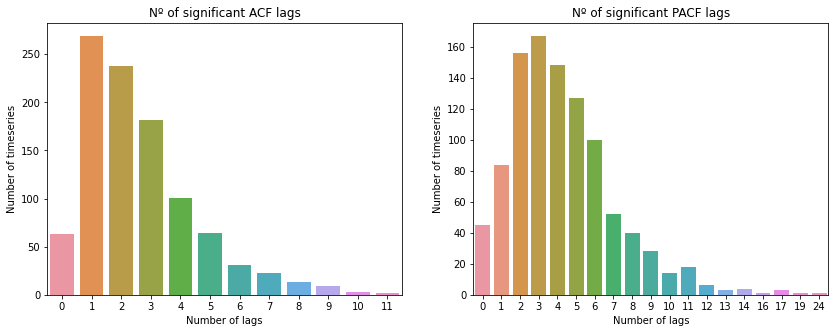

In [ ]:
# Most timeseries have a low number of statistically significant lags.

set_fig_size((14, 5))
fig, ax = plt.subplots(1,2)

p = sns.countplot(data = lags, x = "ACF_lags_count", ax = ax[0])
p.set_title("Nº of significant ACF lags")
p.set_xlabel("Number of lags")
p.set_ylabel("Number of timeseries")
p = sns.countplot(data = lags, x = "PACF_lags_count", ax = ax[1])
p.set_title("Nº of significant PACF lags")
p.set_xlabel("Number of lags")
p.set_ylabel("Number of timeseries")

Text(0, 0.5, 'Percentage of Timeseries/%')

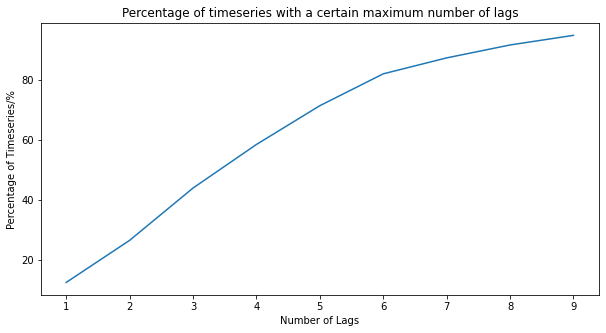

In [ ]:
# Aproximately half of the timeseries use only a maximum of three lags, which is a very low number.

def count_num_lags(row, min_num_lags):
  if (row["ACF"].count(1) <= min_num_lags) & (row["PACF"].count(1) <= min_num_lags):
    return True
  return False

distribution = []
for min_num_lags in range(1, 10):
  lags["is_repeat"] = lags.apply(count_num_lags, **{"min_num_lags": min_num_lags}, axis = 1)
  distribution.append(lags["is_repeat"].mean()*100)

distribution = pd.DataFrame(distribution, index = list(range(1, 10)))
distribution.columns = ["distribution"]

set_fig_size((10,5))
p = sns.lineplot(data = distribution, x = distribution.index, y = "distribution")
p.set_title("Percentage of timeseries with a certain maximum number of lags")
p.set_xlabel("Number of Lags")
p.set_ylabel("Percentage of Timeseries/%")

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


[(0.0, 160.0), (0.0, 0.8)]

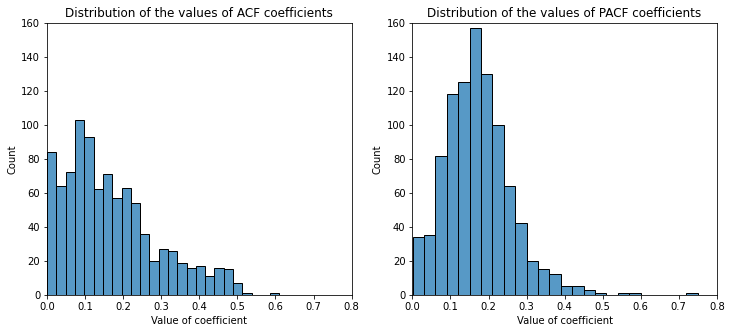

In [ ]:
# The majority of the coefficients also don't have particular high values, which indicates that although the lags are statiscally significant 

lags_flt = lags[lags.PACF_coefs_significant.apply(np.mean) < 1]

set_fig_size((12,5))
fig, ax = plt.subplots(1,2)

p = sns.histplot(abs(lags_flt.ACF_coefs_significant.apply(np.mean)), ax = ax[0], bins = 25)
p.set_title("Distribution of the values of ACF coefficients")
p.set_xlabel("Value of coefficient")
p.set(xlim=(0, 0.8), ylim = (0, 160))
p = sns.histplot(abs(lags_flt.PACF_coefs_significant.apply(np.mean)), ax = ax[1], bins = 25)
p.set_title("Distribution of the values of PACF coefficients")
p.set_xlabel("Value of coefficient")
p.set(xlim=(0, 0.8), ylim = (0, 160))

0.04215860991744875

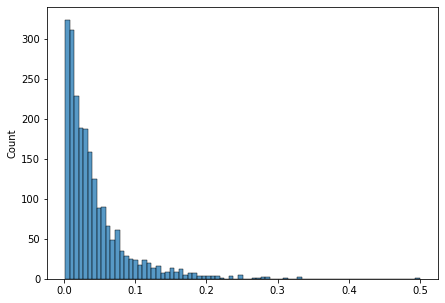

In [ ]:
sns.histplot(n_changes/n_samples)
np.mean(n_changes/n_samples)

In [ ]:
def characterize_n_changes(product_id):
  changes_ratio = n_changes.loc[product_id]/n_samples.loc[product_id]
  if changes_ratio < 0.04:
    return "low_number_changes"
  elif changes_ratio < 0.1:
    return "average_number_changes"
  else:
    return "high_number_changes"

lags["type_changes"] = lags.index.map(characterize_n_changes)

<AxesSubplot:xlabel='type_changes', ylabel='lags_'>

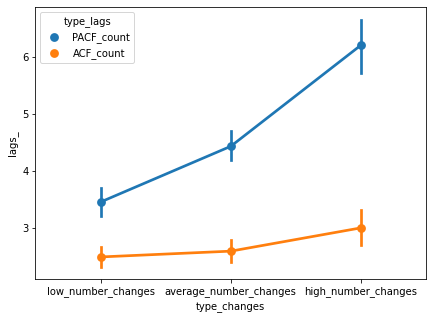

In [ ]:
lags_long = lags.copy()[["type_changes", "PACF_lags_count",	"ACF_lags_count"]]
lags_long.columns = ["type_changes", "lags_PACF_count", "lags_ACF_count"]
lags_long = pd.wide_to_long(lags_long.reset_index(), stubnames = ["lags_"], i = "product_id", j = "type_lags", suffix=r'\w+')
sns.pointplot(data = lags_long.reset_index(), x = "type_changes", y = "lags_", hue = "type_lags", order= ["low_number_changes", "average_number_changes", "high_number_changes"])


### Get ARIMA models

#### ARIMA functions

In [ ]:
class ARIMA:
  def __init__(self):
    pass

  def insert_data(self, data, train_test_split):

    self.train_test_split = train_test_split
    self.data = data.copy()

    self.n_test = round(len(self.data)*(self.train_test_split))

    if self.n_test != 0:
      self.y_train = self.data[:-self.n_test]
      self.y_test = self.data[-self.n_test:]
    else:
      self.y_train = self.data


  def is_stationary(self, tests = [adf_test, kpss_test], p_values_max = [0.05, 0.05]):
    self.df_diff = diff_time_series(self.data, self.diff_order)

    try:
      self.p_values, self.test_results, self.is_stationary, self.is_overall_stationary = test_stationarity(self.df_diff, tests, p_values_max)
    except OverflowError:
      print("Overflow Error")
      self.p_values, self.test_results, self.is_stationary, self.is_overall_stationary = np.nan, np.nan, np.nan, np.nan
      

    if self.is_overall_stationary:
      print("Timeseries is stationary")
    else:
      print("Timeseries is not stationary")

    
  def create_model(self, nlags = 40, diff_order = 1, all_lags = False):
    
    self.diff_order = diff_order
    
    if all_lags:
      self.MA_lags = nlags
      self.AR_lags = nlags
    else:
      self.MA_lags, self.AR_lags = get_lags(self.y_train, self.diff_order, nlags = nlags)

    self.model_train = sm.tsa.statespace.SARIMAX(self.y_train, order=(self.AR_lags, self.diff_order, self.MA_lags))
    #print(self.model_train.start_params)

  def fit_model(self, method, maxiter):
    print("Fitting:", method)

    model_fit = self.model_train.fit(method = method, maxiter = maxiter)
    converged = model_fit.mle_retvals["converged"]

    return model_fit, converged

  def try_fit_model(self, methods, maxiter):

    converged = 0
    for method in methods:
      model_fit, converged = self.fit_model(method, maxiter)
      if converged:
        break

    self.model_fit = model_fit
    self.converged = converged
    if converged:
      self.opt_method = method
    else:
      self.opt_method = np.nan

    return self.converged, self.model_fit
  
  def get_prediction(self):

    self.model = sm.tsa.statespace.SARIMAX(self.data, order=(self.AR_lags, self.diff_order, self.MA_lags)).filter(self.model_fit.params)

    self.predictions = self.model.get_prediction()
    self.pred = self.predictions.predicted_mean.iloc[1:]
    self.confint = self.predictions.conf_int()

    return self.pred, self.confint, self.model

  def get_metric(self, metric):
    self.metric_total = metric(self.data.iloc[1:], self.pred)
    
    if self.n_test != 0:
      self.metric_test = metric(self.y_test, self.pred.iloc[-self.n_test:])
      self.metric_train = metric(self.y_train.iloc[1:], self.pred.iloc[:-self.n_test])
    else:
      self.metric_train = self.metric_total
      self.metric_test = np.nan

    return self.metric_total, self.metric_train, self.metric_test

  def all_info(self):

    info_dict = {"converged": self.converged, 
                 "p_values": self.p_values, 
                 "is_stationary": self.is_overall_stationary, 
                 "metric_total": self.metric_total, 
                 "metric_train": self.metric_train, 
                 "metric_test": self.metric_test,
                 "AR_lags": self.AR_lags,
                 "diff_order": self.diff_order,
                 "MA_lags": self.MA_lags,
                 "obs": self.data,
                 "pred": self.pred,
                 "confint": self.confint,
                 "optimization_method": self.opt_method,
                 "variance": get_variance(self.df_diff),
                 }
    
    return info_dict

In [ ]:
class ARIMA_CV:
  def __init__(self):
    pass

  def insert_data(self, data, train_test_split):

    self.train_test_split = train_test_split
    self.data = data.copy()

    self.n_test = round(len(self.data)*(self.train_test_split))

    if self.n_test != 0:
      self.y_train = self.data[:-self.n_test]
      self.y_test = self.data[-self.n_test:]
    else:
      self.y_train = self.data


  def is_stationary(self, tests = [adf_test, kpss_test], p_values_max = [0.05, 0.05]):
    self.df_diff = diff_time_series(self.data, self.diff_order)

    try:
      self.p_values, self.test_results, self.is_stationary, self.is_overall_stationary = test_stationarity(self.df_diff, tests, p_values_max)
    except OverflowError:
      print("Overflow Error")
      self.p_values, self.test_results, self.is_stationary, self.is_overall_stationary = np.nan, np.nan, np.nan, np.nan
      
    if self.is_overall_stationary:
      print("Timeseries is stationary")
    else:
      print("Timeseries is not stationary")


  def create_model(self, nlags = 40, diff_order = 1, all_lags = False):
    
    self.diff_order = diff_order
    
    if all_lags:
      self.MA_lags = nlags
      self.AR_lags = nlags
    else:
      self.MA_lags, self.AR_lags = get_lags(self.y_train, self.diff_order, nlags = nlags)

    self.model_train = sm.tsa.statespace.SARIMAX(self.y_train, order=(self.AR_lags, self.diff_order, self.MA_lags))


  def fit_model(self, method, maxiter):
    model_fit = self.model_train.fit(method = method, maxiter = maxiter)
    converged = model_fit.mle_retvals["converged"]

    return model_fit, converged

  def try_fit_model(self, methods, maxiter):

    converged = 0
    for method in methods:
      model_fit, converged = self.fit_model(method, maxiter)
      if converged:
        break

    self.model_fit = model_fit
    self.converged = converged
    if converged:
      self.opt_method = method
    else:
      self.opt_method = np.nan

    return self.converged, self.model_fit
  
  def get_prediction(self):

    #self.model = sm.tsa.statespace.SARIMAX(self.y_train, order=(self.AR_lags, self.diff_order, self.MA_lags)).filter(self.model_fit.params)

    self.predictions = self.model_fit.get_forecast()
    self.pred_forecast = self.predictions.predicted_mean
    self.confint_forecast = self.predictions.conf_int()
    return self.pred_forecast, self.confint_forecast, self.model_fit

  def get_metric(self, metric):
    self.metric_total = metric(self.y_test, self.pred)
    return self.metric_total

  def get_baseline_metric(self, metric):
    self.pred_repeat = self.data[-(self.n_test+1):].shift(periods = 1).dropna()
    self.baseline_metric = metric(self.y_test, self.pred_repeat)
    return self.baseline_metric

  def all_info(self):

    info_dict = {"p_values": self.p_values, 
                 "is_stationary": self.is_overall_stationary, 
                 "metric_total": self.metric_total, 
                 "baseline_metric": self.baseline_metric,
                 "AR_lags": self.AR_lags,
                 "diff_order": self.diff_order,
                 "MA_lags": self.MA_lags,
                 "obs": self.data,
                 "obs_test" : self.y_test,
                 "pred": self.pred,
                 "confint": self.confint_lst,
                 "optimization_method": self.opt_method,
                 "variance": get_variance(self.df_diff),
                 "product_id" : self.product_id
                 #"models" : self.models
                 }
    
    return info_dict

  def apply_ARIMA_CV(self, data, train_test_split, metric, method, max_iter, tests = [adf_test, kpss_test], p_values_max = [0.05, 0.05], nlags = 40, diff_order = 1, all_lags = False):
    
    self.product_id = data.name
    print("Product ID: ", self.product_id)

    self.insert_data(data, train_test_split)

    self.pred = self.y_test.copy()
    self.confint_lst = []
    #self.models = []
    for i in range(self.n_test, 1, -1):
      print("Fitting ", i, "/", self.n_test)
      self.y_train = self.data[:-i]
      self.create_model(nlags = nlags, diff_order = 1, all_lags = all_lags)
      self.try_fit_model(method, maxiter)
      #self.models.append(self.model_fit)
      self.pred.iloc[self.n_test-i], confint, tmp = self.get_prediction()
      self.confint_lst.append(confint)
    self.get_metric(metric)
    self.get_baseline_metric(metric)
    self.is_stationary(tests = [adf_test, kpss_test], p_values_max = [0.05, 0.05])

    return self.all_info()

#### Discover best optimizer


Vários otimizadores foram testados, já que muitos deles pareciam não convergir. E os que de facto convergiam, demoravam muito tempo. Tentou então encontrar-se um otimizador que fosse rápido mas que produzisse bons resultados. 

Os seguintes otimizadores nem foram testados pelas seguintes razões:

- Basinhopping demora muito tempo
- NCG dá erros

##### Simulation

In [ ]:
# ARIMA model characteristics
train_test_split = 0
nlags = 30
diff_order = 1
maxiter = 25

# Optimizers to be tested
methods = ['nm', 'bfgs', 'cg']

# List to save the optimizer results of each type of timeseries
optimizer_results_by_timeseries_type = []

# Id's of different types of timeseries. range(30) - timeseries with most changes // range(-1000,-950) - timeseries with least changes, with exception of those with only one change //  range(int(middle), int(middle+40)) - timeseries with a reasonable number of changes
middle = float(len(product_id_ord))/2
i_lists = [range(30), range(-1000,-950), range(int(middle+1), int(middle+40))]

for i_list in i_lists:

  # List to save results of each timeseries
  optimizer_results = []

  for i in i_list:
    
    print("Timeseries: ", i)
    
    # Choose the timeseries
    product_id = [product_id_ord[i]]
    df_product, info = select_time_series(df, "product_id", product_id)
    df_product = prepare_time_series_univariate(df_product, price = "price_euro")
    data = df_product["price_euro"].iloc[0:]

    # Timeseries must have 3 times more samples than the number of total lags and have at least one change
    if (len(data) > 90) & (df_changes[product_id].values > 1):
    
      for method in methods:

        print("Method: ", method)

        model = ARIMA()
        model.insert_data(data, train_test_split)
        model.create_model(nlags = nlags, diff_order = diff_order)

        start = time.time()

        model.try_fit_model([method], maxiter)

        end = time.time()

        model.get_prediction()
        model.get_metric(get_nmse)
        model.is_stationary()

        all_info = model.all_info()
        all_info["timeseries"] = i
        all_info["fit_time"] = end - start      # Time it took to fit the model
        all_info["optimization_method"] = method

        optimizer_results.append(all_info)

  optimizer_results_by_timeseries_type.append(optimizer_results)

optimizer_results_most_changes = pd.DataFrame(optimizer_results_by_timeseries_type[0])
optimizer_results_most_changes.to_pickle("optimizer_results_most_changes_maxiter_25.pkl")

optimizer_results_least_changes = pd.DataFrame(optimizer_results_by_timeseries_type[1])
optimizer_results_least_changes.to_pickle("optimizer_results_least_changes_maxiter_25.pkl")

optimizer_results_average_changes = pd.DataFrame(optimizer_results_by_timeseries_type[2])
optimizer_results_average_changes.to_pickle("optimizer_results_average_changes_maxiter_25.pkl")

##### Analyze results

In [ ]:
# When it isn't explicitly stated in the name, the tests were made with 100 iterations.
optimizer_results_most_changes = pd.read_pickle("optimizer_results_most_changes_maxiter_25.pkl")
optimizer_results_least_changes = pd.read_pickle("optimizer_results_least_changes_maxiter_25.pkl")
optimizer_results_average_changes = pd.read_pickle("optimizer_results_average_changes_maxiter_25.pkl")
optimizer_results_all = pd.concat([optimizer_results_average_changes, optimizer_results_least_changes, optimizer_results_most_changes]).reset_index()

In [ ]:
results_total = optimizer_results_all[(optimizer_results_all["metric_total"] < 100)][["optimization_method", "converged",	"is_stationary",	"metric_total",	"fit_time"]]
results_least_changes = optimizer_results_least_changes[(optimizer_results_least_changes["metric_total"] < 100)][["optimization_method", "converged",	"is_stationary",	"metric_total",	"fit_time"]]#.groupby(by = "optimization_method").mean()[["converged",	"is_stationary",	"metric_total",	"fit_time"]]
results_average_changes = optimizer_results_average_changes[(optimizer_results_average_changes["metric_total"] < 100)][["optimization_method", "converged",	"is_stationary",	"metric_total",	"fit_time"]]#.groupby(by = "optimization_method").mean()[["converged",	"is_stationary",	"metric_total",	"fit_time"]]
results_most_changes = optimizer_results_most_changes[(optimizer_results_most_changes["metric_total"] < 100)][["optimization_method", "converged",	"is_stationary",	"metric_total",	"fit_time"]]#.groupby(by = "optimization_method").mean()[["converged",	"is_stationary",	"metric_total",	"fit_time"]]
all_results = pd.concat([results_least_changes, results_average_changes, results_most_changes, results_total], keys=['least_changes', 'average_changes', 'most_changes', 'total'])
all_results.optimization_method = all_results.optimization_method.apply(str.upper)

In [ ]:
fontsize = 14

set_fig_size((10, 5))
p = sns.barplot(data = all_results, x = all_results.index.get_level_values(0), y = "metric_total", hue = "optimization_method", errwidth = 0.8, capsize = 0.1)
p.set(ylim=(0,-60))
p.set_title("Average performance of different solvers for each type of timeseries", fontsize = fontsize)
p.set_xlabel("Type of Timeseries", fontsize = fontsize)
p.set_ylabel("Average NMSE/dB", fontsize = fontsize)
p.set_xticklabels(["Small nº of changes", "Average nº of changes", "High nº of changes", "All timeseries"], fontsize = fontsize-1.5)
p.legend(title = 'Solver Methods', fontsize = fontsize-1.5, loc = "lower right")

for container in p.containers:
  p.bar_label(container, padding = -15, fmt = "%.2f dB")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "chooseSolverPerformance")

In [ ]:
fontsize = 13

set_fig_size((10, 5))
p = sns.barplot(data = all_results, x = all_results.index.get_level_values(0), y = "fit_time", hue = "optimization_method", errwidth = 0.5, capsize = 0.1)
p.set_title("Average fit time of different solvers for each type of timeseries", fontsize = fontsize)
p.set_xlabel("Type of Timeseries", fontsize = fontsize)
p.set_ylabel("Average fit time/s", fontsize = fontsize)
p.set_xticklabels(["Small nº of changes", "Average nº of changes", "High nº of changes", "All timeseries"], fontsize = fontsize-1.5)
p.legend(title = 'Solver Methods', fontsize = fontsize-1.5)
for container in p.containers:
  p.bar_label(container, padding = 4, fmt = "%.2f s")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "chooseSolverFitTime")

Check if number of iterations influences results

In [ ]:
filenames = ["arima_results_nm_25_iter",
             "arima_results_nm_50_iter",
             "arima_results_nm_100_iter",
             "arima_results_nm_200_iter"]

iters = ["25", "50", "100", "200"]

all_iter_results = []
for filename, iter in zip(filenames, iters):
  iter_results = pd.read_pickle(filename)[["metric_total", "converged", "optimization_method", "fit_time"]]
  iter_results["iter"] = iter
  all_iter_results.append(iter_results)

all_iter_results = pd.concat(all_iter_results)
all_iter_results.optimization_method = all_iter_results.optimization_method.apply(str.upper)

I don't know why, but more timeseries converged for 25 iterations than for 50 iterations.

<AxesSubplot:xlabel='iter', ylabel='converged'>

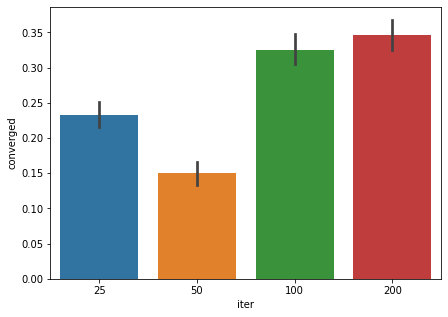

In [ ]:
set_fig_size((7,5))
sns.barplot(data = all_iter_results, x = "iter", y = "converged")

The performance also decreases with the increase of iterations, why?

<AxesSubplot:xlabel='iter', ylabel='metric_total'>

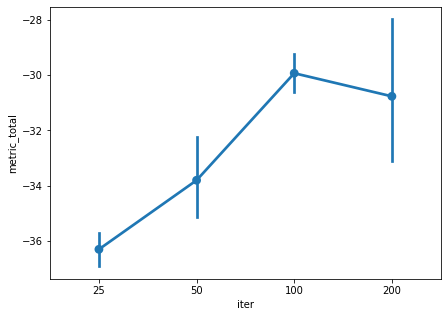

In [ ]:
set_fig_size((7,5))
sns.pointplot(data = all_iter_results, x = "iter", y = "metric_total")

The fit time naturally increases with the number of iterations.

<AxesSubplot:xlabel='iter', ylabel='fit_time'>

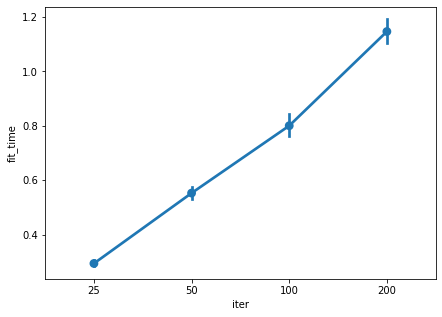

In [ ]:
set_fig_size((7,5))
sns.pointplot(data = all_iter_results, x = "iter", y = "fit_time")

#### Fit models without cross-validation

##### Using linear interpolation

In [ ]:
train_test_split = 0
nlags = 28
diff_order = 1
maxiter = 25

method = 'nm'
timeseries_results = []

for i in range(len(product_id_ord)):
  
  print("Timeseries: ", i)
  product_id = product_id_ord[i]
  df_product, info = select_time_series(df, "product_id", [product_id])
  df_product = prepare_time_series_univariate(df_product, price = "price_euro")

  data = df_product["price_euro"].iloc[0:]

  if (len(data) > 90) & (df_changes[[product_id]].values > 1):

    model = ARIMA()
    model.insert_data(data, train_test_split)
    model.create_model(nlags = nlags, diff_order = diff_order)

    start = time.time()

    model.try_fit_model([method], maxiter)

    end = time.time()

    model.get_prediction()
    model.get_metric(get_nmse)
    model.is_stationary()
    all_info = model.all_info()
    all_info["fit_time"] = end - start
    all_info["optimization_method"] = method
    all_info["product_id"] = int(product_id)
    #print(product_id)
    timeseries_results.append(all_info)


df_timeseries_results = pd.DataFrame(timeseries_results)
df_timeseries_results.to_pickle("arima_results_" + method + "_" + str(maxiter) + "_iter")

Timeseries:  0


NameError: ignored

##### Using fill interpolation

In [ ]:
#### Code updated
# _28_lags", "_21_lags", "_14_lags", "_7_lags", "_5_lags", "_3_lags", "_2_lags", "_1_lags",

train_test_split = 0
#nlags = 31
diff_order = 1
maxiter = 100
all_lags = True
method = 'nm'

product_id_lst = list(df_flt.index.get_level_values(0).unique())

nlags_list = [3]

for nlags in nlags_list:

  print("N_lags: ", nlags)

  timeseries_results = []

  for product_id in product_id_lst:
    
    print("ID: ", product_id)
    
    #df_product, info = select_time_series(df, "product_id", [product_id])
    #df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolate_method = "ffill")

    data = df_flt["price_euro"].loc[product_id]

    model = ARIMA()
    model.insert_data(data, train_test_split)
    model.create_model(nlags = nlags, diff_order = diff_order, all_lags = all_lags)

    start = time.time()

    model.try_fit_model([method], maxiter)

    end = time.time()

    model.get_prediction()
    model.get_metric(get_nmse)
    model.is_stationary()
    all_info = model.all_info()
    all_info["fit_time"] = end - start
    all_info["optimization_method"] = method
    all_info["product_id"] = int(product_id)

    ## Model parameters
    model_parameters = pd.concat([model.model_fit.params, model.model_fit.conf_int()], axis = 1)
    model_parameters.columns = ["model_params", "conf_int_lower", "conf_int_upper"]
    all_info["model_parameters"] = model_parameters


    timeseries_results.append(all_info)

  df_timeseries_results = pd.DataFrame(timeseries_results)
  #df_timeseries_results.to_pickle("arima_results_" + method + "_" + str(maxiter) + "_iter_fill_interpolation_w_model_params")
  df_timeseries_results.to_pickle("arima_results_" + method + "_" + str(maxiter) + "_iter_fill_interpolation_" + str(nlags) + "_lags_w_model_params")

N_lags:  3
ID:  2
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 3.354604
         Iterations: 84
         Function evaluations: 163


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [9.040802774556952e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  4
Fitting: nm
P-Values:  [2.804423156189613e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  12
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0583732875644684e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  18
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0223145462270832e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  20
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.084025732786338e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  21
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.386825768673291e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  24
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.977963811981767e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  25
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0843954535860011e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  26
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.115113333680587e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  27
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.059916786997238e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  28
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.7567532156516914e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  29
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0163600262379056e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  30
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4002021341251908e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  32
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.04956886412835e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  33
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4116851200792124e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  34
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.359403
         Iterations: 83
         Function evaluations: 160
P-Values:  [2.1594822623817886e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  36
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.9482102503771573e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  37
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2127368916743418e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  38
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  40
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.338774841062573e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  42
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.5488652628366785e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  43
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.081345
         Iterations: 97
         Function evaluations: 189
P-Values:  [7.871116411219845e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  58
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.312254227861222e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  73
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.011927307730634e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  74
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.08539784962010508]
The timeseries is stationary.
Timeseries is stationary
ID:  77
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [0.8663712991473367, 0.1]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  79
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.906882894322591e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  83
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.631629
         Iterations: 61
         Function evaluations: 117
P-Values:  [1.1522010267431569e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  84
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.588441457217735e-15, 0.06750458610114286]
The timeseries is stationary.
Timeseries is stationary
ID:  89
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [3.688210576003109e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  90
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0179886045579448e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  92
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.765649
         Iterations: 93
         Function evaluations: 160
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  93
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.861275592209563e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  94
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.308623173261626e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  95
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.462880007235472e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  96
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.836242235030701e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  97
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4160103090811645e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  98
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.416267547356475e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  100
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.1575928840580654e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  102
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  103
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  104
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.810607299847492e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  105
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.729527306053235e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  106
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1629113394662845e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  107
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.75543515316236e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  109
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3220015772754364e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  110
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0156897101038772e-19, 0.07144803196382492]
The timeseries is stationary.
Timeseries is stationary
ID:  112
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [1.13067569728733e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  113
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.171260944623518e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  114
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.974559008743217e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  115
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  132
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.579031
         Iterations: 82
         Function evaluations: 156
P-Values:  [1.9966362927006766e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  136
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.651963106838022e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  138
Fitting: nm
P-Values:  [8.589924162908881e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  145
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  148
Fitting: nm
P-Values:  [2.343054356089164e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  161
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.322527
         Iterations: 81
         Function evaluations: 147
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  163
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 2.887060
         Iterations: 71
         Function evaluations: 139
P-Values:  [6.084784914666434e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  164
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.06017145684209e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  166
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.3618647879647502, 0.07994282678672865]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  168
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [8.7114546701548e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  179
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  189
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.617769637995239e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  193
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.578281
         Iterations: 64
         Function evaluations: 123
P-Values:  [3.1687631052388265e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  194
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.467555575157115e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  195
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.836993331293947e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  196
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4106474022891096e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  198
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0377973929896508e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  200
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.5614827928432027e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  201
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  202
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8605678681537006e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  203
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.3047440816167517e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  204
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.777690592858268e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  205
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.35016531741174e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  206
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.7267362132513785e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  207
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.179866966201744e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  208
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.404082533494874e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  212
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.360949859369946e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  225
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.01694611659416633, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  228
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  229
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.416782602180896e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  232
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.790081
         Iterations: 75
         Function evaluations: 143
P-Values:  [6.655076223340868e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  233
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.614717591435715e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  234
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.923159460239794e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  237
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.441302195502849e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  239
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0003235402460083325, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  244
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.338478
         Iterations: 92
         Function evaluations: 163


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.642611114421974e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  262
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.971937
         Iterations: 82
         Function evaluations: 161


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.1649759424765766e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  295
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.592900
         Iterations: 73
         Function evaluations: 144


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [4.545302563518989e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  299
Fitting: nm
P-Values:  [9.62875273094889e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  301
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.90470181070666e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  304
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.071103724222301e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  305
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.022988019043815e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  306
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.662356040143992e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  307
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8349564688213743e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  309
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.647290
         Iterations: 79
         Function evaluations: 140
P-Values:  [4.877885108865375e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  319
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  320
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.500810849113952e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  325
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.6513570054505468e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  328
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.5693739445315647e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  334
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 5.099885
         Iterations: 97
         Function evaluations: 189
P-Values:  [2.642306099834622e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  350
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.1744150139839375e-24, 0.04438604297486245]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  353
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [2.1519411570370158e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  355
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.1642437657406895e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  362
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.5032514926141203e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  363
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5013178668049576e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  365
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.773850
         Iterations: 90
         Function evaluations: 178
P-Values:  [1.4046801320639878e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  367
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.2368390258659416e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  368
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.291385605341699e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  370
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.1205958108665064e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  371
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.135523633006059e-20, 0.04166666666667871]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  372
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [1.1317507871586281e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  374
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.479125355374283e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  389
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  390
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.34595510259939e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  393
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1093142541706473e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  394
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.6110097427610441e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  395
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0710520942508905e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  398
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.1913763959946665e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  399
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.224077077569728e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  400
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.787240077193393e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  404
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [5.327614928834887e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  410
Fitting: nm
P-Values:  [9.978240758546858e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  414
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.485681633176987e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  416
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.9018669972422954e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  417
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.727694952100505e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  418
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2104931126113962e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  419
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.480228444876956e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  421
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.6638101173444057e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  423
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.912417271664335e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  428
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.532261943916706e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  429
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.926513
         Iterations: 92
         Function evaluations: 175
P-Values:  [2.9802273100740967e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  431
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [0.018818272975989203, 0.08879480817360907]
The timeseries is stationary.
Timeseries is stationary
ID:  432
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [3.4141766260567414e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  447
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.654119365960162e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  453
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.467339965822762e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  455
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0500268837975024e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  457
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.008317086269745463, 0.04723041599009925]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  458
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [2.575129795460186e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  459
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.056222250818257e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  460
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.310062904452292e-06, 0.02842960938895103]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  462
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [9.173459647062483e-11, 0.04166666666666602]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  468
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [7.763879210587495e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  469
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.368527332500174e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  470
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0911155614979166e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  471
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.16795812613679e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  473
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.557296831736128e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  474
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  477
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.371287125713123e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  478
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.2539580959945476e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  479
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.290064556816778e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  480
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.559790247463779e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  481
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.19019020978003e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  482
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1004872556004431e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  484
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.213080
         Iterations: 76
         Function evaluations: 136
P-Values:  [7.665659481804172e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  485
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.4023887501943639e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  490
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.1085982105221178e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  495
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.671980747747992e-05, 0.08263376039919187]
The timeseries is stationary.
Timeseries is stationary
ID:  496
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [3.38498967447753e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  499
Fitting: nm
P-Values:  [5.933374743534096e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

ID:  500
Fitting: nm
P-Values:  [9.089328978482152e-30, 0.08537673583033567]
The timeseries is stationary.
Timeseries is stationary
ID:  503
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


P-Values:  [3.258837381282952e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  506
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [7.673935669366365e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  511
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8308570301257366e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  512
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.605461931427259e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  515
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.799274821015906e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  518
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.406917153012109e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  521
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  522
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6655271117915144e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  523
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.315874633185003e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  525
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.660398863352868e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  526
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.810936435715415e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  527
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6358455226345165e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  528
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5301098766479856e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  529
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.8594834294999677e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  530
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.123913798346531e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  532
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.947053884348849e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  535
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.9851487308993836e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  540
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.2381838442878e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  541
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7493636982514564e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  543
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.005817126121264e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  548
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.824509047636075e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  549
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.45171876059325e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  551
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0681449470831636e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  559
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1322236607340633e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  562
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.470750991062578e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  563
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.102227989325176e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  565
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.113082312688746e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  568
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.06853509375886e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  572
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.801761451832017e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  576
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.836830
         Iterations: 69
         Function evaluations: 133
P-Values:  [4.068646808074702e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  577
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 2.458837
         Iterations: 72
         Function evaluations: 140
P-Values:  [4.543290743130465e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  578
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.1951290043591963e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  580
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3913066616829253e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  581
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.900774616268646e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  582
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  583
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.617996547399866e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  584
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.191055151274862e-16, 0.041666666666667296]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  585
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [8.519287489715275e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  586
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8754153760134648e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  588
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.2645118318293475e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  589
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.1590106874476963e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  590
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.6035805385098692e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  591
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.3999628571964475e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  593
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.505285240025358e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  598
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.06483731621051154, 0.1]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  599
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.450500
         Iterations: 47
         Function evaluations: 86
P-Values:  [9.61825112372209e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  600
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  601
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.161319163358732e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  602
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.898717861397014e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  603
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  604
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.824896787656025e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  606
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.2290261442970695e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  607
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  611
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0905748536631958e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  612
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.2777502584306554e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  614
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.537835465642298e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  615
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.85391265144989e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  616
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.814171245184892e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  617
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.546237646417628e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  618
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.607406238898147e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  630
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  637
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.071257728457011e-16, 0.041666666666563996]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  638
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [5.101261528705047e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  639
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.270505
         Iterations: 85
         Function evaluations: 158

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati


P-Values:  [1.2211953914055752e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  645
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.8899254676065173e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  649
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.4255804875605e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  650
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.1660321345101217e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  651
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2693392011478446e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  654
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.63775851880896e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  655
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7256641692045876e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  657
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5993707616496081e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  658
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.9851653826746115e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  670
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4792634325888621e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  678
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8645338870707302e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  690
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  691
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.317390623638663e-06, 0.09228127362159484]
The timeseries is stationary.
Timeseries is stationary
ID:  692
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [3.907541470765601e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  693
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.100890179521267e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  694
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3560053178381025e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  695
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.9009862592545668e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  696
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  698
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.951412
         Iterations: 99
         Function evaluations: 177
P-Values:  [2.415916311085255e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  699
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.9629953705617452e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  700
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.352317089564734e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  701
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7988815922501726e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  702
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.450021337309697e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  703
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3092051846108193e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  704
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1376239836720748e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  705
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.104944636507901e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  708
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1144713852315952e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  709
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.070091752439613e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  711
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.813075241145033e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  712
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.9912678542759968e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  718
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0009235722058783163, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  719
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.891909394012538e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  724
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.025513
         Iterations: 65
         Function evaluations: 129
P-Values:  [1.5503581825383215e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  725
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [9.201429123825736e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  726
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.2187205338764263e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  728
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.821755
         Iterations: 64
         Function evaluations: 127
P-Values:  [2.2176927199308165e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  732
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.012998208478999e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  738
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.579482
         Iterations: 83
         Function evaluations: 159
P-Values:  [1.6134227659024443e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  739
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [7.594654320580433e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  740
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.8212510589374654e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  741
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.309331197032028e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  742
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.110357905780312e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  746
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.166650156554543e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  747
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5934325735975488e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  749
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  750
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.24804151799972e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  752
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5907088767765262e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  753
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.3552248355548423e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  758
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.524366493528971e-30, 0.07654776044759576]
The timeseries is stationary.
Timeseries is stationary
ID:  759
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [6.05245469211787e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  760
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.0156868824695948e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  761
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.670552789701082e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  762
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.378444491852307e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  767
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.401791
         Iterations: 85
         Function evaluations: 155
P-Values:  [1.1115026454770436e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  771
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.307430623548399e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  773
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8037633211987428e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  777
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.006311926483012e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  786
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5949587543572774e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  787
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3426766372791346e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  788
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7340035008146907e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  789
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.019891899695277e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  790
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  792
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.614950
         Iterations: 89
         Function evaluations: 154
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  793
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.7671404536100934e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  795
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8020855286800695e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  798
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.041345383825406e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  799
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.591981343088687e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  800
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.0261243041795045e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  801
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.7050676306836116e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  802
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.949213108484651e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  803
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.1051444850130326e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  804
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  805
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.177399
         Iterations: 84
         Function evaluations: 157
P-Values:  [9.152347426829709e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  806
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.139959707066095e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  809
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.004800020317573997, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  814
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.1031247700586886e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  815
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.565460
         Iterations: 72
         Function evaluations: 136
P-Values:  [1.49102211078703e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  817
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.880347460570272e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  818
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.06472212134546e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  828
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  829
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3584468718253e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  830
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.456781
         Iterations: 69
         Function evaluations: 131
P-Values:  [3.2647860340051305e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  831
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [7.863888354855854e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  832
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.835089
         Iterations: 70
         Function evaluations: 136
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  833
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.8836956394186984e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  835
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.8532690745862426e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  838
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7899066947794577e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  839
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.910460
         Iterations: 93
         Function evaluations: 164
P-Values:  [1.9292009924356209e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  840
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [6.512242696089498e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  843
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.647179914073911e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  844
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.820988554880757e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  846
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7952314922385482e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  847
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.5437649469892384e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  848
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.746676663766875e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  850
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.798040434918056e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  852
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.897095483162128e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  857
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.421661327711192e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  861
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.412655544987659e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  867
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.23889307796946e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  869
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.257030644866172e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  870
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.986073668748351e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  876
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

P-Values:  [3.3637028235380027e-22, 0.09007265656483285]
The timeseries is stationary.
Timeseries is stationary
ID:  883
Fitting: nm
P-Values:  [2.620007177335222e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  890
Fitting: nm
Optimization terminated successfully.
         Current function value: 1.968737
         Iterations: 74
         Function evaluations: 137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1763427810504998e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  915
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.001953351516301249, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  918
Fitting: nm
P-Values:  [2.23534755015687e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  919
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.2404459668705256e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  920
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0251047579780744e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  923
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.568487841750469e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  925
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.5807445348771165e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  927
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.1888388749379157e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  928
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8045418260466237e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  932
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  933
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  934
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2050704261816345e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  935
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  936
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2138823733965891e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  937
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.1910783762118304e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  938
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5045583042121564e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  939
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.249752624094528e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  940
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8227116534592297e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  941
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.552870212794961e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  943
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0110861289019206e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  945
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.487509209535775e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  948
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.1934387921769686e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  950
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4430896645552325e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  964
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.283601
         Iterations: 65
         Function evaluations: 119
P-Values:  [2.5108068009964467e-23, 0.086849719603866]
The timeseries is stationary.
Timeseries is stationary
ID:  969
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 1.971618
         Iterations: 65
         Function evaluations: 128
P-Values:  [5.430460502479449e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  971
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.610882461022346e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  972
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.061793
         Iterations: 67
         Function evaluations: 126
P-Values:  [2.176022897994253e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  974
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.777695063303378e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  975
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.030996430089683e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  976
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4206523515087254e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  977
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.6859513592783143e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  979
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.863863
         Iterations: 80
         Function evaluations: 150
P-Values:  [2.1829911375723275e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  997
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.1444095951818577e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  998
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.694942
         Iterations: 63
         Function evaluations: 126
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1008
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.1058030615872842e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1009
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8150606362761555e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1010
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3445843705159276e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1012
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8910604064945516e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1013
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1015
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.771095243460014e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1018
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3704299872764174e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1019
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.759199009884934e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1021
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1963148829115914e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1025
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.5324157055488274e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1028
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.712045
         Iterations: 85
         Function evaluations: 147
P-Values:  [8.052452386145896e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1029
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 2.607220
         Iterations: 92
         Function evaluations: 177
P-Values:  [4.406572139305629e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1032
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.072806057242777e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1033
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4718341244047806e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1037
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.173459647062551e-11, 0.04166666666666649]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  1047
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [7.81950901609449e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1050
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.026817488855794e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1075
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.0724572627994757e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1077
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.8065768685669915e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1078
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.9735207095293483e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1079
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Overflow Error
Timeseries is stationary
ID:  1081
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/ts

P-Values:  [1.4108625514487569e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1082
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.3753884790135197e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1083
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7537963124523718e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1089
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.719902161509642e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1099
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.697342383727964e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1102
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.221000965779851e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1107
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.038097012106373e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1111
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.285293
         Iterations: 73
         Function evaluations: 133
P-Values:  [8.20060536004214e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1112
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 1.899637
         Iterations: 65
         Function evaluations: 128
P-Values:  [2.4885254167546793e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1113
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [6.080934749571206e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1114
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5296688010923454e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1115
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.047481072454093e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1118
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.00026480597221428603, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1119
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.880211837228027e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1121
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7770076860171223e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1122
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.539051899196839e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1123
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.110390224141514e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1124
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.59938185810441e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1125
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.397860275274615e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1126
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.41507348360587e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1127
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.72853559063098e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1129
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.2217638080948706e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1135
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.540768577352302e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1138
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.469724
         Iterations: 69
         Function evaluations: 140
P-Values:  [4.974994018084368e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1142
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 3.245540
         Iterations: 70
         Function evaluations: 138
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1144
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [6.128095446317873e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1145
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1147
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8805868029631626e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1161
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.0241848761869e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1162
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.404254675681407e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1163
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.004567212711166e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1164
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2862002381451115e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1165
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.824944539480063e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1166
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.6624453328549714e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1169
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.012085066910032e-05, 0.07215328406414576]
The timeseries is stationary.
Timeseries is stationary
ID:  1189
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [0.006937778067738967, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1195
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.119334
         Iterations: 57
         Function evaluations: 111
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1196
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.0857172697203475e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1198
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.463481639919982e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1199
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.033999874839073e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1200
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.161415163346211e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1201
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7187544781414148e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1202
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0060277362010372e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1205
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4614957495083205e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1227
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0003836890629277338, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1230
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1118073073339806e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1231
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.076622749097773e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1234
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.9031254873870125e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1251
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.2836782520318555e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1253
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.044374796770948e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1254
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.5524088886071807e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1255
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.389700847676251e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1257
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.0540843361897934e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1258
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.382240747201388e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1264
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.400961
         Iterations: 85
         Function evaluations: 169
P-Values:  [1.593292267007285e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1270
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 2.655056
         Iterations: 71
         Function evaluations: 133
P-Values:  [1.280524904145648e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1275
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.1927157296326918e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1276
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8538203649816127e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1281
Fitting: nm
Optimization terminated successfully.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati


         Current function value: 3.056572
         Iterations: 77
         Function evaluations: 143
P-Values:  [1.097579161346401e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1283
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.265146689421427e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1284
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.021490315043055e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1285
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.6082955335061678e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1286
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3212020124426514e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1287
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.503412834251339e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1289
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.005951110609417e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1291
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.696756953553873e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1292
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.493203
         Iterations: 71
         Function evaluations: 134


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.039345685458215e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1293
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.023674016474102087, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1296
Fitting: nm
P-Values:  [7.195697183386584e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1300
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.909139266016924e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1310
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.7506628142752365e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1316
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1957250700214338e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1317
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.506664227097026e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1318
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.7160596181719535e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1319
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.404124014032775e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1320
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.69496752397069e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1321
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.11791140133173e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1322
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.1147471663686517e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1325
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.3972559656114694e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1326
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.348380
         Iterations: 86
         Function evaluations: 170
P-Values:  [4.873140113597965e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1327
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.740112981449705e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1330
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.694969
         Iterations: 72
         Function evaluations: 144
P-Values:  [4.452271588717887e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1335
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.5013468212138563e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1336
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.846540
         Iterations: 74
         Function evaluations: 146
P-Values:  [1.584152492753235e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1338
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.085944382338448e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1339
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.587830568631096e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1340
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.983981452637758e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1341
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7824161732796311e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1342
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7522558962860896e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1343
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.487321737482509e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1344
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.965716930991917e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1345
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.262087498403532e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1353
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.028880596322734e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1356
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.3053597270216858e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1357
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.011719727904667e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1358
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.1653121943098e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1360
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.424547031649035e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1368
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.907140201998664e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1370
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.9554271620684376e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1371
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5334128694758904e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1382
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.713391
         Iterations: 92
         Function evaluations: 168
P-Values:  [2.671154946045021e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1384
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.5297228856690683e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1385
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.9116644939190972e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1390
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.215642543200731e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1392
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.522005326787584e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1395
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.520527
         Iterations: 57
         Function evaluations: 110
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1396
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [6.252216735071822e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1397
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.3381060720750394e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1398
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.714447574249638e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1400
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.038559707423604e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1401
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.040322080060006e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1402
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.069090672957687e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1403
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.815533294848182e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1405
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.383928518025441e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1406
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.862985729227448e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1407
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.500885334233157e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1409
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.637588891267738e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1410
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.192354913087492e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1411
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.337752999874469e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1413
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5778087374547102e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1414
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.610238358021907e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1417
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.986109783996872e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1424
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.766992935140175e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1425
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.2704949066948024e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1428
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.731755693559855e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1436
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.96505495283354e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1444
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.88106509790342e-29, 0.05274120144396098]
The timeseries is stationary.
Timeseries is stationary
ID:  1445
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [1.3584803090731582e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1446
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.200678374524544e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1447
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.497635
         Iterations: 70
         Function evaluations: 134
P-Values:  [1.6139705484298787e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1448
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.352576337280549e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1451
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.454175393246702e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1452
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.816648753261457e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1453
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0228752736382254e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1459
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.463975244772711e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1460
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.0012894889906197e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1461
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7211621225294785e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1462
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1463
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.29668353950328e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1464
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.537902397526549e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1465
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1807998396359764e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1466
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.744408033777103e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1467
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.795663659457901e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1468
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.081786284370757e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1469
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.381301
         Iterations: 62
         Function evaluations: 120
P-Values:  [2.8497568749541486e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1476
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.742467906271453e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1477
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5946759016119625e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1479
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.683803814416779e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1484
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.933535683743977e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1490
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0996246043415623e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1495
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.661703
         Iterations: 71
         Function evaluations: 139
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1498
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 3.875754
         Iterations: 89
         Function evaluations: 178
P-Values:  [1.552714963464054e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1502
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.7346710331876655e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1503
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.3880947540948624e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1512
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.199670593899558e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1514
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0001449829568789046, 0.08668821313228264]
The timeseries is stationary.
Timeseries is stationary
ID:  1515
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1516
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3548608028234983e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1517
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7671799440071503e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1518
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.000890176470084742, 0.08471972260877497]
The timeseries is stationary.
Timeseries is stationary
ID:  1519
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [2.795005031190121e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1528
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.1477783190997907e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1541
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0924917501564705e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1542
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.499568324913187e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1543
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1544
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.584126753602281e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1545
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.140052211057817e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1547
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1549
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.565755264318348e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1550
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.9658845332401533e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1551
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6748944565904575e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1552
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.115795997052196e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1554
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0621695202082843e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1556
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1557
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0803126283462728e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1560
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.581570089517672e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1561
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.045999111243687e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1562
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7372797849948313e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1563
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1566
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.476421495816389e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1577
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.96390884287332e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1578
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.001389059240911554, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1579
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.501891
         Iterations: 56
         Function evaluations: 108
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1592
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [0.00011189708092270246, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1596
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.633127973566096e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1597
Fitting: nm
Optimization terminated successfully.
         Current function value: 3.103150
         Iterations: 63
         Function evaluations: 118


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6581121460467273e-25, 0.040792136222243765]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  1598
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

P-Values:  [4.706157870008168e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1600
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7359795344809653e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1601
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.457487916516379e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1606
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.407480010284944e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1626
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.608130305422374e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1631
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0167751904354017e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1632
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0539346656637947e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1634
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.671224051712596e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1637
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0429190093442403e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1653
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.551334
         Iterations: 67
         Function evaluations: 125
P-Values:  [6.582988071462497e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1654
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.9617635315902255e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1655
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.067142
         Iterations: 83
         Function evaluations: 164
P-Values:  [4.011564685307067e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1656
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.0447481816954541e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1678
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4251631256793357e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1679
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.681024
         Iterations: 84
         Function evaluations: 161
P-Values:  [7.974562623703552e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1680
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [4.917721141096807e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1681
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.487592878549598e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1682
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.740082513049788e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1683
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.990923779175602e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1689
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3885009963734237e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1693
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.6707676541897606e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1694
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7338050218255377e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1698
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0483659495948496e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1699
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.365990296509595e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1703
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0836952960797283e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1708
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.081070865487472e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1710
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.413458
         Iterations: 82
         Function evaluations: 153
P-Values:  [3.4607209563070175e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1711
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [4.552931439938836e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1717
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.3449809523589415e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1720
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0004310541390381578, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1722
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.948515994639377e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1723
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.447384542754101e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1725
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.733176622407461e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1732
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.713578430601373e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1733
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.862098957766073e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1737
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.0407893887032724e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1740
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.081182408263932e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1743
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.685292422442794e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1746
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.088821257418968e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1747
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.2621283299994608e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1748
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1056074966729851e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1750
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.499675635842956e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1751
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.773396282563209e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1753
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.593685648074071e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1761
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.680290623932217e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1762
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.936504481915625e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1763
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2008982813520458e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1764
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8788299949949606e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1769
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4048046484669483e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1770
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7443623541114325e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1771
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.7160596181719535e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1772
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.483448295815238e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1773
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1440351819709624e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1774
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.206496573805307e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1775
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.69153454265012e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1777
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.614944201965979e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1781
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.682909532626789e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1792
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.688398027212713e-12, 0.04166666666668019]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  1797
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [1.981937132117876e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1798
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.640401676416574e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1800
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.017016138972746e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1801
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.741427030809298e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1805
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.258320136451377e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1807
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.196567301746849e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1814
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.254384
         Iterations: 87
         Function evaluations: 168
P-Values:  [6.66087317960815e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1817
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.218323483973334e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1820
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3696737467504603e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1821
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.472639288815621e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1826
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.673048941123735e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1827
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0788187720923908e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1833
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.457378671774731e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1834
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0640010104185925e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1835
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2203346976766137e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1836
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7831276079700518e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1837
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6728953890478407e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1838
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.2848033280942268e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1839
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.2418745188152877e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1840
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6824446223593096e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1842
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3108597879051644e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1857
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3544496778929708e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1859
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.463927920856189e-10, 0.04166666666666632]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  1863
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [7.065178488065586e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1864
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2762175257772848e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1866
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.842983853240474e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1870
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8994137102296392e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1874
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.789178896362857e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1876
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.139319960626087e-29, 0.02265334537084547]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  1877
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [3.0924227609069865e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1894
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.9546096033386e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1901
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.492401
         Iterations: 83
         Function evaluations: 148
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1903
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.321717411944221e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1904
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.335432
         Iterations: 74
         Function evaluations: 142
P-Values:  [1.1682559428106378e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1905
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1908
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7133867130558224e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1909
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.149288397131373e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1911
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.761261473601524e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1914
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.3756403916482125e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1915
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.431836422379426e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1916
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0361169458325158e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1919
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.629426
         Iterations: 95
         Function evaluations: 176
P-Values:  [5.279397706226788e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1925
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.022295180382581e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1936
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1937
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.501682806616612e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1939
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0675412417855684e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1942
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.039352732836514e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1945
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.344060029449796e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1947
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.1919732784256154e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1952
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.726152344485322e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1954
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.463964
         Iterations: 90
         Function evaluations: 177
P-Values:  [4.378612350240135e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1958
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.6351617643911995e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1959
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.7414313304137336e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1960
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.982151040749112e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1961
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.104045
         Iterations: 77
         Function evaluations: 154
P-Values:  [4.850063968228339e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1962
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [6.935155052851923e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1963
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.851584912735422e-09, 0.07927575847204665]
The timeseries is stationary.
Timeseries is stationary
ID:  1966
Fitting: nm
P-Values:  [0.00012057216359715294, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1967
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.523001081918698e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1977
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.810638071505558e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1990
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2934395021981137e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1991
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.409410
         Iterations: 94
         Function evaluations: 178
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1993
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 2.925934
         Iterations: 93
         Function evaluations: 163
P-Values:  [2.0170981786480854e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1994
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 2.853694
         Iterations: 68
         Function evaluations: 129
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1995
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.718021076523231e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1996
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8107049311095485e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1997
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1998
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2691632795632963e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  1999
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5709804039328667e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2001
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3525566778012835e-23, 0.0717079211606916]
The timeseries is stationary.
Timeseries is stationary
ID:  2002
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [4.4601968384970693e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2003
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.236377989852411e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2004
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.980636470394729e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2005
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2006
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.685738043895814e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2008
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.130669
         Iterations: 98
         Function evaluations: 176
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2009
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.157945857206839e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2010
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8540465731192268e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2015
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0765934068531355e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2021
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.535124661169104e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2024
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2889806378192719e-16, 0.0988834576820852]
The timeseries is stationary.
Timeseries is stationary
ID:  2026
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [4.743973080168405e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2028
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1648539183441723e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2037
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.852060794997598e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2039
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.96390884287332e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2041
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.051887326856208e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2042
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.343711
         Iterations: 83
         Function evaluations: 162
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2043
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [8.006972451485952e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2045
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.268190667119124e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2046
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2108889630861267e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2047
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0860479558066837e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2049
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0861657925843644e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2052
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.939131218144389e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2057
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2058
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.96390884287332e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2059
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.829200989809355e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2061
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0410185860093384e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2070
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2074
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.1317788095917346e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2076
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.732736
         Iterations: 97
         Function evaluations: 163
P-Values:  [2.0296250637949188e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2079
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.1751928785959728e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2084
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.700731
         Iterations: 85
         Function evaluations: 164
P-Values:  [4.2846814538440726e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2105
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 3.001077
         Iterations: 74
         Function evaluations: 144
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2108
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [9.216997147685536e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2109
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4315172965625537e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2110
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2112
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2114
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2115
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.207180413224405e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2116
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.9647502593017896e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2127
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2763596703913266e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2133
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.425724702898569e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2134
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.0219132124896873e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2136
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.769445612908009e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2137
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.5351711878491603e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2138
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.2294721415171463e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2150
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.88157033071061e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2153
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.910900688368584e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2157
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7838584218155978e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2163
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 4.512528
         Iterations: 88
         Function evaluations: 164
P-Values:  [3.875447794969125e-22, 0.09144958753909163]
The timeseries is stationary.
Timeseries is stationary
ID:  2171
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [1.311698790460185e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2172
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2177
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.255688
         Iterations: 80
         Function evaluations: 135
P-Values:  [7.482659298131278e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2187
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 3.954381
         Iterations: 97
         Function evaluations: 171
P-Values:  [2.603762857801372e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2188
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.289465724967533e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2193
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.469119644176533e-25, 0.0836990439418469]
The timeseries is stationary.
Timeseries is stationary
ID:  2207
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2218
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4259706477857496e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2220
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0489858953752703e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2221
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3048658521915207e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2229
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.065999332232095e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2233
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.695559003089318e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2235
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7561109725116539e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2236
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.9638061278836726e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2263
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.257811655786242e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2267
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.0033249100282387e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2269
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.090609234118574e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2270
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.272156723621902e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2274
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.009770663882371e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2276
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3131219593432159e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2278
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.403009474695906e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2279
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0008830857783191536, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2281
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.063083
         Iterations: 96
         Function evaluations: 168
P-Values:  [7.408183784578664e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2283
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.0017427135091187e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2285
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.605617671348535e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2288
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.813769204616694e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2291
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.711212763632297e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2298
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.277593795719087e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2299
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.441702648713153e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2300
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2301
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.743885201629349e-13, 0.07698066896008404]
The timeseries is stationary.
Timeseries is stationary
ID:  2302
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [8.091818685714392e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2303
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.184473219907326e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2305
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.0012977459286426e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2306
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.9036852781024204e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2307
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5149587072802255e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2308
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.370588882140088e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2309
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.706544490942285e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2318
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1420385830463008e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2323
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.891170188577151e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2324
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.550265201417397e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2325
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.7115536944879473e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2326
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.2647464963281265e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2327
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.999056325991262e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2329
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2330
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4963574346361461e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2331
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.0201688332107162e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2333
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.173459647062551e-11, 0.041666666666666394]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  2339
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [2.632349616977181e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2353
Fitting: nm
Optimization terminated successfully.
         Current function value: 3.336161
         Iterations: 77
         Function evaluations: 142
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2356
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.054050140641162e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2358
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.531095822561763e-19, 0.08255901982780763]
The timeseries is stationary.
Timeseries is stationary
ID:  2359
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 4.582257
         Iterations: 86
         Function evaluations: 167
P-Values:  [2.0898350859677913e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2360
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [9.855413431320411e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2362
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.9741673172444416e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2363
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.486235121841322e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2368
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.704064578149883e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2374
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.330946815320837e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2378
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.434492
         Iterations: 87
         Function evaluations: 159
P-Values:  [6.072961820753456e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2379
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [4.1419820520339926e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2393
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 3.118028
         Iterations: 77
         Function evaluations: 148
P-Values:  [3.8022310936190015e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2394
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.544853270658381e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2395
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [5.936657046038979e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2396
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [6.234566392672073e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2398
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4919321808292579e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2399
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0008884032832191855, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2403
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3720566452229128e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2412
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7416444213674945e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2420
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.348002857034327e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2426
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.370481
         Iterations: 81
         Function evaluations: 155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.531377767025456e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2430
Fitting: nm
P-Values:  [2.875345826237699e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2431
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.614080735546409e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2434
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.990785
         Iterations: 65
         Function evaluations: 128
P-Values:  [2.1738219801340473e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2436
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.7128107316370176e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2437
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.5035604627374284e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2439
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.43081203082138e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2441
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3672051090509323e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2442
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.9123243720371248e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2443
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1246613804767756e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2450
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.88925538692409e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2451
Fitting: nm
P-Values:  [2.883622639066795e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2459
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2463
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5384107745639405e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2481
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1758669506538986e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2486
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.464490
         Iterations: 80
         Function evaluations: 155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.618023305820268e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2492
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodel

P-Values:  [1.2869014293874022e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2499
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1949776053011007e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2511
Fitting: nm
P-Values:  [5.26375557246331e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2529
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.862634545703962e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2539
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2548
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2568
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.732059
         Iterations: 64
         Function evaluations: 123
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2569
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.1697178200429045e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2571
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.232605639518891e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2572
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4604787787622025e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2573
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.778577072278738e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2574
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.054456858504455e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2575
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.5117814667471137e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2579
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.2537292300041064e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2580
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.2112555446363284e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2582
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.496737256969057e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2583
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5734915226851763e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2584
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.835537717264582e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2588
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.889904816845966e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2591
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2597
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2598
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2599
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.721603705461912e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2600
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6420960127228044e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2601
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2603
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1727142468212386e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2604
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.735238356809283e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2609
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.561908933826102e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2611
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1090636248375635e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2612
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.387835380956407e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2617
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2619
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.455853024069926e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2623
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3358796016315552e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2624
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.903768996077055e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2626
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.997588254177404e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2627
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.029885
         Iterations: 57
         Function evaluations: 111
P-Values:  [1.4198210080372943e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2628
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [9.964837095868063e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2630
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.193338187967058e-17, 0.07825510965439482]
The timeseries is stationary.
Timeseries is stationary
ID:  2631
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [2.7020522567282444e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2632
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.951112
         Iterations: 61
         Function evaluations: 124
P-Values:  [2.416052515026337e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2636
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [4.6185003216377635e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2637
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.86910146244266e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2640
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.662354027099029e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2641
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.1345140590556835e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2642
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.000946819384236045, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2643
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.667360900128083e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2645
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.927277535504012e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2665
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.2615569210171157e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2677
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2687
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.1992626406848547e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2688
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.6172475249927325e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2692
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.111447193412305e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2693
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0010126192737489328, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2695
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.814150
         Iterations: 75
         Function evaluations: 143
P-Values:  [4.38282033616594e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2704
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [0.007829731752207147, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2706
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.280993
         Iterations: 57
         Function evaluations: 111
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2708
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [7.446076046325216e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2709
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.229958296017115e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2711
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.01441692123466526, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2715
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.885573
         Iterations: 83
         Function evaluations: 159
P-Values:  [2.7892487560703746e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2717
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2724
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.489528548599768e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2727
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6190382234486636e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2728
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.542204709869819e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2731
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.755482214800491e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2738
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.00031230779871806115, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2749
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.815480
         Iterations: 56
         Function evaluations: 109
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2750
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.5128677358544438e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2751
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2752
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7575625696584293e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2753
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.533318
         Iterations: 72
         Function evaluations: 131
P-Values:  [2.115164018514301e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2754
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.6571132461962903e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2757
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3422899307853692e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2759
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.6132058260003015e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2760
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.928689522158424e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2764
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.163800787943318e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2765
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.687411524875829e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2792
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.593468630334461e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2798
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.472272106325388e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2799
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.7303800390247753e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2800
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.2619195577699305e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2804
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.756845
         Iterations: 84
         Function evaluations: 156
P-Values:  [4.6815425090007085e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2808
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.2858999416469008e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2810
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.804636436213091e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2816
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.146056606301609e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2844
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.964386
         Iterations: 69
         Function evaluations: 131
P-Values:  [1.7126928466747648e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2846
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [6.19542225785744e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2848
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.767864559279216e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2850
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.8581706814749946e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2853
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.7971722636644464e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2854
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.3885124964151e-28, 0.06359825023011709]
The timeseries is stationary.
Timeseries is stationary
ID:  2855
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [6.607190977162523e-05, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2856
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.921776900046166e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2857
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.5426104238613668e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2862
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8495360985130107e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2863
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.820690350625101e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2867
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.199216042293922e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2868
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.3088187344317586e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2893
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.412286
         Iterations: 47
         Function evaluations: 93
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2894
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.296377965258251e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2895
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.702530
         Iterations: 63
         Function evaluations: 117
P-Values:  [0.0, 0.03933827563875893]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  2897
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


P-Values:  [5.732003180326153e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2898
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.008089885372405e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2899
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.9111910056093686e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2900
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.721322077751514e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2901
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.347387
         Iterations: 73
         Function evaluations: 141
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2902
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.153402498030986e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2903
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.834489154874084e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2905
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.848538
         Iterations: 92
         Function evaluations: 168
P-Values:  [4.9574612097388946e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2907
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.8853037710221546e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2908
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.519170011482668e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2919
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.725564
         Iterations: 99
         Function evaluations: 175
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2925
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [4.585689207746628e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2926
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.464973
         Iterations: 80
         Function evaluations: 150


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.8716526675817036e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2928
Fitting: nm
Optimization terminated successfully.
         Current function value: 2.891505
         Iterations: 92
         Function evaluations: 168
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2939
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 4.503747
         Iterations: 95
         Function evaluations: 185
P-Values:  [1.853942438745244e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2944
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

Optimization terminated successfully.
         Current function value: 2.267534
         Iterations: 57
         Function evaluations: 111
P-Values:  [7.65348978948833e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2945
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.5290252716765707e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2946
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.434855795112553e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2947
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.369485984670095e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2948
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.966505
         Iterations: 80
         Function evaluations: 155
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2950
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [5.301353855871054e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2951
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.258827
         Iterations: 93
         Function evaluations: 159
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2953
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.0068483616990097e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2954
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.719492
         Iterations: 74
         Function evaluations: 140
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2956
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.7013354329875423e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2960
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0002601562444577534, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2961
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2962
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.0010019255085084e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2963
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.825864089616577e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2970
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.3176032304282523e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2976
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.495995169883408e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2984
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.354912
         Iterations: 58
         Function evaluations: 113
P-Values:  [5.616063129143987e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2985
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [8.394675736714101e-18, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2987
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2989
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.291247002349993e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2990
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.949991
         Iterations: 60
         Function evaluations: 119
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2993
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.0707529901842104e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2995
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.3528866320751515e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2998
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.0269363885820225e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  2999
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.527248020221306e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3002
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.2836452598058376e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3015
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.504135
         Iterations: 62
         Function evaluations: 119
P-Values:  [6.013541172095636e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3016
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [4.199670593899558e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3029
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Overflow Error
Timeseries is stationary
ID:  3035
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/ts

P-Values:  [4.081045487668916e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3039
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.2167204786443173e-26, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3045
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3047
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.4249148572848456e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3048
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.332771573626047e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3058
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 1.822182
         Iterations: 73
         Function evaluations: 133
P-Values:  [2.975359614846537e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3059
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.4594700076432142e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3060
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.108349818179066e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3061
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.9048472404433902e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3062
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.5563044417889833e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3072
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.003865367054639e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3073
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.420052578665645e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3074
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.8231271292832025e-13, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3075
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.947183575530686e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3076
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.9874879364666578e-17, 0.04166666666666092]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  3079
Fitting: nm
P-Values:  [0.15180217377610372, 0.022305255923449955]
Can't confirm the series is stationary.
Timeseries is not stationary
ID:  3089
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.561147
         Iterations: 43
         Function evaluations: 85
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3095
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.5430348546542061e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3098
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.6934257524927865e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3101
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.8732725661935835e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3105
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.8656654307858306e-08, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3116
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3117
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.0018714143366677e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3118
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.533541394834824e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3120
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.817066
         Iterations: 97
         Function evaluations: 170
P-Values:  [7.91285132300693e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3121
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.9004599722741002e-27, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3123
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.536339552201706e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3124
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.777926
         Iterations: 85
         Function evaluations: 147
P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3125
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [3.9235306160517686e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3126
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.680162080731237e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3127
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 3.237223
         Iterations: 93
         Function evaluations: 167
P-Values:  [2.97717538381835e-28, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3130
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [2.1406731091915878e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3131
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.089174626646696e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3132
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3133
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [4.6287736511321144e-29, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3134
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.833231751297671e-23, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3137
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.445699460442547e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3138
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.06670145534818396]
The timeseries is stationary.
Timeseries is stationary
ID:  3139
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib

P-Values:  [6.742831009809773e-10, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3140
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.761868507037415e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3147
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.144392
         Iterations: 57
         Function evaluations: 111
P-Values:  [1.6158546339978742e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3160
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [7.759179637777022e-24, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3167
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3168
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.952364834641483e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3169
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3171
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.246300892866667e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3172
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.628378085907991e-20, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3174
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.9208237364927255e-17, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3175
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.660099462975755e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3177
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [7.08147055885837e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3178
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [6.159546611141372e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3181
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4160137842457847e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3182
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.744202
         Iterations: 75
         Function evaluations: 142
P-Values:  [6.40555442828549e-22, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3184
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [8.082545430495551e-07, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3185
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [0.0, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3186
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [9.55309299006397e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3211
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [8.797569978707613e-14, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3216
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4866299534618837e-11, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3217
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.06406326045174e-19, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3218
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4990447246307433e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3220
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.573546354635234e-25, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3223
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [2.4783024025587372e-21, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3225
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [5.5551648156159284e-15, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3226
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.6676040324518e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3228
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [3.4973558264224664e-06, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3229
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

Optimization terminated successfully.
         Current function value: 2.175842
         Iterations: 78
         Function evaluations: 142
P-Values:  [5.8398246828540894e-30, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3230
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No 

P-Values:  [1.7575276420195572e-09, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3231
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.815327703383271e-12, 0.1]
The timeseries is stationary.
Timeseries is stationary
ID:  3234
Fitting: nm


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informati

P-Values:  [1.1120063620621462e-16, 0.1]
The timeseries is stationary.
Timeseries is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
train_test_split = 0
nlags = 3
diff_order = 1
maxiter = 50
all_lags = False
method = 'nm'
timeseries_results = []

for i in range(len(product_id_ord)):
  
  print("Timeseries: ", i)
  product_id = product_id_ord[i]
  df_product, info = select_time_series(df, "product_id", [product_id])
  df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolate_method = "ffill")

  data = df_product["price_euro"].iloc[0:]

  if (len(data) > 90) & (df_changes[[product_id]].values > 1):

    model = ARIMA()
    model.insert_data(data, train_test_split)
    model.create_model(nlags = nlags, diff_order = diff_order, all_lags = all_lags)

    start = time.time()

    model.try_fit_model([method], maxiter)

    end = time.time()

    model.get_prediction()
    model.get_metric(get_nmse)
    model.is_stationary()
    all_info = model.all_info()
    all_info["fit_time"] = end - start
    all_info["optimization_method"] = method
    all_info["product_id"] = int(product_id)
    timeseries_results.append(all_info)

df_timeseries_results = pd.DataFrame(timeseries_results)
df_timeseries_results.to_pickle("arima_results_" + method + "_" + str(maxiter) + "_iter_fill_interpolation")
#df_timeseries_results.to_pickle("arima_results_" + method + "_" + str(maxiter) + "_iter_fill_interpolation_" + str(nlags) + "_lags")

##### Auto ARIMA

###### Simple example

In [ ]:
product_id_lst = list(df_flt.index.get_level_values(0).unique())

train = df_flt.loc[product_id_lst[5]]["price_euro"]
arima = pm.auto_arima(train, d = 1, trace = True, max_p = 31, max_q = 31, stepwise = False)

arima.predict_in_sample()     # Predictions on train data
arima.params()                # Parameters
arima.conf_int()              # Confidence interval of parameters

In [ ]:
len(arima.maparams())
len(arima.arparams())

###### Get models for all timeseries

In [ ]:
product_id_lst = list(df_flt.index.get_level_values(0).unique())

max_p = 31
max_q = 31
max_order_list = [31, 7]
stepwise_list = [True, False]

count = 0
count_timeseries = 0

for i in range(0, len(product_id_lst) + 1, 200):

  count = count + 1
  timeseries_results = []

  for product_id in product_id_lst[i:i+200]:

    count_timeseries = count_timeseries + 1
    print("\n\n", str(count_timeseries), "/", len(product_id_lst))

    for max_order, stepwise in zip(max_order_list, stepwise_list):
    
      print("ID: ", product_id)

      print("Max_order:", max_order)
      print("Stepwise:", stepwise)

      data = df_flt.loc[product_id]["price_euro"]

      arima = pm.auto_arima(data, d = 1, trace = True, max_p = max_p, max_q = max_q, stepwise = stepwise, max_order = max_order)

      pred = arima.predict_in_sample()

      nmse = get_nmse(data[1:], pred[1:])

      model_parameters = pd.concat([arima.params(), arima.conf_int()], axis = 1)
      model_parameters.columns = ["model_params", "conf_int_lower", "conf_int_upper"]
      if stepwise:
        model_parameters = model_parameters.drop(["sigma2"])
      else:
        model_parameters = model_parameters.drop(["intercept", "sigma2"])

      info_dict = {"product_id" : product_id,
                  "metric_total" : nmse,
                  "obs" : data[1:],
                  "pred" : pred[1:],
                  "model_parameters" : model_parameters,
                  "MA_order" : len(arima.maparams()),
                  "AR_order" : len(arima.arparams()),
                  "max_p" : max_p,
                  "max_q" : max_q,
                  "max_order": max_order,
                  "stepwise" : stepwise}
                  
      timeseries_results.append(info_dict)

  df_timeseries_results = pd.DataFrame(timeseries_results)
  df_timeseries_results.to_pickle("arima_results_auto_arima_fill_interpolation_" + str(count))

print("Finished!")



 1 / 1045
ID:  2
Max_order: 14
Stepwise: False
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1962.982, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1964.982, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1966.940, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1968.940, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1970.940, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1972.940, Time=0.15 sec
 ARIMA(0,1,6)(0,0,0)[1] intercept   : AIC=1974.940, Time=0.20 sec
 ARIMA(0,1,7)(0,0,0)[1] intercept   : AIC=1976.939, Time=0.26 sec
 ARIMA(0,1,8)(0,0,0)[1] intercept   : AIC=1978.939, Time=0.31 sec
 ARIMA(0,1,9)(0,0,0)[1] intercept   : AIC=1980.939, Time=0.34 sec
 ARIMA(0,1,10)(0,0,0)[1] intercept   : AIC=1982.939, Time=0.40 sec
 ARIMA(0,1,11)(0,0,0)[1] intercept   : AIC=1984.938, Time=0.49 sec
 ARIMA(0,1,12)(0,0,0)[1] intercept   : AIC=1986.777, Time=0.53 sec
 ARIMA(0,1,13)(0,0,0)[1] intercept   : AIC=1987.978, Time=0.82 sec
 ARIMA(0,1,14)(0,0,0)[1

#### Fit models with cross validation

In [ ]:
def fill_info_dict_nan(product_id):
  info_dict = {"p_values": np.nan, 
                "is_stationary": np.nan, 
                "metric_total": np.nan, 
                "AR_lags": np.nan,
                "diff_order": np.nan,
                "MA_lags": np.nan,
                "obs": np.nan,
                "obs_test" : np.nan,
                "pred": np.nan,
                "confint": np.nan,
                "optimization_method": np.nan,
                "variance": np.nan,
                "product_id" : product_id
                }
  return info_dict

def get_arima_cv_results(df, train_test_split, metric, method, max_iter, nlags, all_lags):
  
  #if (len(df) > 90) & (df_changes[[df.name]].values > 1):
  if len(df)*train_test_split > nlags*2:

    model = ARIMA_CV()
    return model.apply_ARIMA_CV(df, train_test_split, metric, method, max_iter, nlags = nlags, all_lags = all_lags)

  return fill_info_dict_nan(df.name)

In [ ]:
print(list(range(50, 1001, 50)))
print(list(range(52, 1051, 50)))

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050]


In [ ]:
##### 31 28

In [ ]:
import warnings
#warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

train_test_split = 0.4

#nlags = 31
lags = [31, 28] #, 21, 14, 7, 5, 3]

diff_order = 1
maxiter = 25
all_lags = True
method = ['nm']


init_count = list(range(0, 1001, 25))
end_count = list(range(25, 1051, 25))

count = 0

product_id_lst = list(df_flt.index.get_level_values(0).unique())
product_id_lst.remove(869)
product_id_lst.remove(1336)
product_id_lst.remove(1743)
product_id_lst.remove(2511)
product_id_lst.remove(2642)

for nlags in lags:

  print("Lags: ", nlags)

  for init, end in zip(init_count, end_count):
  
    print(init, end)
    
    count = count + 1

    results = df_flt.loc[product_id_lst[init:end]].groupby(id)["price_euro"].apply(get_arima_cv_results, **{"train_test_split" : train_test_split, "metric" : get_nmse, "method" : method, "max_iter" : maxiter, "nlags" : nlags, "all_lags" : all_lags})
    results = pd.DataFrame(results)

    results.to_pickle("arima_results_" + method[0] + "_" + str(maxiter) + "_iter_fill_interpolation_cross_validation_best_approach_all_" + str(nlags) + "_lags_" + str(count))
    #results.to_pickle("arima_results_" + method[0] + "_" + str(maxiter) + "_iter_fill_interpolation_cv_" + str(count))

A saída de streaming foi truncada nas últimas 5000 linhas.
Fitting  45 / 174
Fitting  44 / 174
Fitting  43 / 174
Fitting  42 / 174
Fitting  41 / 174
Fitting  40 / 174
Fitting  39 / 174
Fitting  38 / 174
Fitting  37 / 174
Fitting  36 / 174
Fitting  35 / 174
Fitting  34 / 174
Fitting  33 / 174
Fitting  32 / 174
Fitting  31 / 174
Fitting  30 / 174
Fitting  29 / 174
Fitting  28 / 174
Fitting  27 / 174
Fitting  26 / 174
Fitting  25 / 174
Fitting  24 / 174
Fitting  23 / 174
Fitting  22 / 174
Fitting  21 / 174
Fitting  20 / 174
Fitting  19 / 174
Fitting  18 / 174
Fitting  17 / 174
Fitting  16 / 174
Fitting  15 / 174
Fitting  14 / 174
Fitting  13 / 174
Fitting  12 / 174
Fitting  11 / 174
Fitting  10 / 174
Fitting  9 / 174
Fitting  8 / 174
Fitting  7 / 174
Fitting  6 / 174
Fitting  5 / 174
Fitting  4 / 174
Fitting  3 / 174
Fitting  2 / 174
P-Values:  [2.0156897101038772e-19, 0.07144803196382492]
The timeseries is stationary.
Timeseries is stationary
Product ID:  112
Fitting  63 / 63
Fitting  62

### Read ARIMA model results

#### Read model results

##### Functions

In [29]:
# Read the contents of a file with results from an arima model
def read_arima_file(filename, suffix):
  
  arima_results = pd.read_pickle(filename)   # Read contents of file
  arima_results = arima_results.set_index("product_id").rename(columns={"metric_total": "arima_nmse"}).drop(["metric_train", "metric_test"], axis = 1) # Remove non used columns
  if "model_parameters" in arima_results.columns:
    arima_results["contains_zero"] = arima_results.model_parameters.apply(contains_zero)
  arima_results = arima_results.add_suffix(suffix)    # Add an optional suffix to the columns of the dataframe with the arima results

  return arima_results

# Read the contents of a file with results from naive models
def read_naive_file(filename, suffix):
  naive_results = pd.read_pickle(filename)
  naive_results = naive_results.add_suffix(suffix)
  return naive_results

# Check if all elements of a list have the same size
def all_same_size(items):
  sizes = list(map(len, items))
  return all(size == sizes[0] for size in sizes)

# Read the results of several files and join them in one dataframe - the data that originated these results has to be the same (e.g. interpolation method has to be the same)
def read_model_results(df, models_filenames, models_read_functions, suffixes, interpolation_method, join = "outer"):
  
  df = df.copy()

  # Check if the correct number of models_filenames or models_read_functions or suffixes was given
  if not all_same_size([models_filenames, models_read_functions, suffixes]):
    print("Warning: models_filenames or models_read_functions or suffixes don't all have the same size")
    
  # Read model results
  models_results = []
  for model_filename, model_read_function, suffix in zip(models_filenames, models_read_functions, suffixes):
    models_results.append(model_read_function(model_filename, suffix))

  # Join model results to information of number of changes in original data
  models_results = pd.concat(models_results, axis = 1, join = join)

  return models_results

# Join linear model results with fill model results
def join_all_model_results(model_results, suffixes, on = "product_id", how = "outer"):
    model_results[0] = model_results[0].add_suffix(suffixes[0])
    model_results[1] = model_results[1].add_suffix(suffixes[1])

    model_results_all = model_results[0].merge(model_results[1], on = [on], how = how)

    return model_results_all

def add_samples_changes(df):
  df = df.copy().loc[n_changes_flt.index]
  df["n_changes"] = df.index.map(lambda x : n_changes_flt.loc[x])
  df["n_samples"] = df.index.map(lambda x : n_samples_flt.loc[x])
  df["changes_samples_ratio"] = df["n_changes"]/df["n_samples"]
  
  return df

In [30]:
def contains_zero(params):

  if type(params) is float:
    return np.nan
  if "sigma2" in params.index:
    params = params.drop("sigma2")
  return 1-(params.conf_int_lower*params.conf_int_upper < 0).mean()


def get_significant_lags(model_parameters, type):
  model_parameters["not_contains_zero"] = (model_parameters.conf_int_lower*model_parameters.conf_int_upper > 0)
  model_parameters = model_parameters[model_parameters.not_contains_zero]
  params = list(model_parameters.index)
  lags = np.zeros(31)
  for param in params:
    if param[:2] == type:
      lags[int(param[4:])-1] = 1
  return lags


def get_all_predictions(df):
  product_id = df._name
  if "lags" in df.index:
    lags = df.lags
  else:
    lags = None
  
  df = pd.concat([df["obs"], df["pred"], df["pred_repeat"]], axis = 1, join = "inner")
  df.columns = ["obs", "pred", "pred_repeat"]
  df["product_id"] = product_id

  if lags is not None:
    df["lags"] = lags
  
  return df


def residual_analysis(df):
  
  if len(df) < 29*2:
    return np.nan, np.nan
  
  nlags = 28
  alpha = 0.05

  residuals = (df["pred"]-df["obs"]).dropna()
  
  try:
    acf_coeff,  acf_confint  = acf(residuals, nlags=nlags, alpha = alpha, fft = True)
    pacf_coeff, pacf_confint = pacf(residuals, nlags=nlags, alpha = alpha)
  except np.linalg.LinAlgError: 
    return np.nan
  
  # The confidence interval is computed based on white noise (??), so the confidence interval (shaded blue area) is centered around the value of the correlation
  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1] - acf_coeff)  | (acf_coeff  < acf_confint[:,0] - acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]- pacf_coeff) | (pacf_coeff < pacf_confint[:,0] - pacf_coeff)).astype(int))

  acf_lags = acf_lags[1:]
  pacf_lags = pacf_lags[1:]

  return acf_lags, pacf_lags

##### Read model results

In [31]:
# Naive model
model_filenames = ["naive_results_fill_interpolation.pkl",
                   "naive_model_repeat_observations.pkl"]

naive_results = []
for model_filename in model_filenames:
  naive_results.append(pd.read_pickle(model_filename))

naive_results = pd.concat(naive_results, axis = 1).dropna()[["repeat_nmse", "pred_repeat"]]

In [32]:
# 1st approach
model_filename = "arima_results_nm_100_iter_fill_interpolation_w_model_params"
approach_1 = read_arima_file(model_filename, "")[["arima_nmse", "AR_lags", "MA_lags", "obs", "pred", "confint", "model_parameters", "contains_zero"]]
approach_1 = add_samples_changes(approach_1)
approach_1 = pd.concat([approach_1, naive_results], axis = 1).dropna()

In [33]:
#2nd approach
# model_filenames = ["arima_results_nm_100_iter_fill_interpolation_31_lags_w_model_params",
#                    "arima_results_nm_100_iter_fill_interpolation_28_lags_w_model_params",
#                     "arima_results_nm_100_iter_fill_interpolation_21_lags_w_model_params",
#                     "arima_results_nm_100_iter_fill_interpolation_14_lags_w_model_params",
#                     "arima_results_nm_100_iter_fill_interpolation_7_lags_w_model_params",
#                     "arima_results_nm_100_iter_fill_interpolation_5_lags_w_model_params",
#                     "arima_results_nm_100_iter_fill_interpolation_3_lags_w_model_params"]

# suffixes = ["_31_lags", "_28_lags", "_21_lags", "_14_lags", "_7_lags", "_5_lags", "_3_lags"]
# suffixes = [31, 28, 21, 14, 7, 5, 3]
# approach_2_results = []

# for model_filename, suffix in zip(model_filenames, suffixes):
#   print(suffix)
#   df_tmp = read_arima_file(model_filename, "")[["arima_nmse", "AR_lags", "MA_lags", "obs", "pred", "confint", "model_parameters", "contains_zero"]]
#   df_tmp = pd.concat([df_tmp, naive_results], axis = 1).reset_index()
#   approach_2_results.append(df_tmp)
  
# approach_2 = pd.concat(approach_2_results, keys = suffixes)
# approach_2 = approach_2.reset_index().drop(["level_1"], axis = 1)
# approach_2["lags"] = approach_2["level_0"]
# approach_2 = approach_2.drop(["level_0"], axis = 1)

# model_filename = "arima_results_nm_100_iter_fill_interpolation_fixed_lags_w_model_params_long"
# approach_2.to_pickle(model_filename)

model_filename = "arima_results_nm_100_iter_fill_interpolation_fixed_lags_w_model_params"
model_filename = "arima_results_nm_100_iter_fill_interpolation_fixed_lags_w_model_params_long"
approach_2_all = pd.read_pickle(model_filename).set_index("product_id")
approach_2_all = add_samples_changes(approach_2_all)
approach_2_all = approach_2_all.dropna()

In [34]:
# 3rd approach

# auto_arima_filename = "arima_results_auto_arima_fill_interpolation_"
# auto_arima_max_count = 6
# model_results_auto_arima = []

# for count in range(1, auto_arima_max_count + 1):
#  model_results_auto_arima.append(pd.read_pickle(auto_arima_filename + str(count)))
   
# model_results_auto_arima = pd.concat(model_results_auto_arima).set_index("product_id")
# model_results_auto_arima.to_pickle("arima_results_auto_arima_fill_interpolation_all")

approach_3_all = pd.read_pickle("arima_results_auto_arima_fill_interpolation_all").rename(columns={'metric_total' : 'arima_nmse'})
approach_3_all = add_samples_changes(approach_3_all)

In [35]:
extreme = -10

approach_1["extreme"] = approach_1.arima_nmse > extreme
print("Approach 1 - Number of extreme cases: ", len(approach_1[approach_1.extreme]))
#approach_1 = approach_1[approach_1.extreme == False]

approach_2_all["extreme"] = approach_2_all.arima_nmse > extreme
print("Approach 2 - Number of extreme cases: ", len(approach_2_all[approach_2_all.extreme]))
approach_2_all = approach_2_all[approach_2_all.extreme == False]

approach_3_all["extreme"] = approach_3_all.arima_nmse > extreme
print("Approach 3 - Number of extreme cases: ", len(approach_3_all[approach_3_all.extreme]))
approach_3_all = approach_3_all[approach_3_all.extreme == False]
approach_3 = approach_3_all[approach_3_all.stepwise == False]
approach_3 = pd.concat([approach_3, naive_results], axis = 1).dropna()

Approach 1 - Number of extreme cases:  20
Approach 2 - Number of extreme cases:  49
Approach 3 - Number of extreme cases:  14


In [36]:
approach_1["compare_arima_repeat"] = approach_1["arima_nmse"] -  approach_1["repeat_nmse"]
approach_1["AR_lags_significant"] = approach_1.model_parameters.apply(lambda model_parameters : get_significant_lags(model_parameters, 'ar'))
approach_1["MA_lags_significant"] = approach_1.model_parameters.apply(lambda model_parameters : get_significant_lags(model_parameters, 'ma'))
approach_1["contains_zero"] = approach_1.model_parameters.apply(contains_zero)
approach_1["significant_model"] = (approach_1.contains_zero != 0)

approach_2_all["compare_arima_repeat"] = approach_2_all["arima_nmse"] -  approach_2_all["repeat_nmse"]
approach_2_all["AR_lags_significant"] = approach_2_all.model_parameters.apply(lambda model_parameters : get_significant_lags(model_parameters, 'ar'))
approach_2_all["MA_lags_significant"] = approach_2_all.model_parameters.apply(lambda model_parameters : get_significant_lags(model_parameters, 'ma'))
approach_2_all["contains_zero"] = approach_2_all.model_parameters.apply(contains_zero)
approach_2_all["significant_model"] = (approach_2_all.contains_zero != 0)

approach_3["compare_arima_repeat"] = approach_3["arima_nmse"] -  approach_3["repeat_nmse"]
approach_3["AR_lags_significant"] = approach_3.model_parameters.apply(lambda model_parameters : get_significant_lags(model_parameters, 'ar'))
approach_3["MA_lags_significant"] = approach_3.model_parameters.apply(lambda model_parameters : get_significant_lags(model_parameters, 'ma'))
approach_3["contains_zero"] = approach_3.model_parameters.apply(contains_zero)
approach_3["significant_model"] = (approach_3.contains_zero != 0)

In [37]:
approach_2 = approach_2_all.groupby(by = "product_id").apply(lambda df : df[df['arima_nmse'] == df['arima_nmse'].min()]).droplevel(0).reset_index()

In [38]:
residuals = pd.DataFrame(list(approach_1.apply(residual_analysis, axis = 1)))
residuals.index = approach_1.index
approach_1[["MA_lags_residual", "AR_lags_residual"]] = residuals
approach_1["lags_residual_percentage"] = (approach_1["MA_lags_residual"].apply(np.mean) + approach_1["AR_lags_residual"].apply(np.mean))/2

residuals = pd.DataFrame(list(approach_2.apply(residual_analysis, axis = 1)))
residuals.index = approach_2.index
approach_2[["MA_lags_residual", "AR_lags_residual"]] = residuals
approach_2["lags_residual_percentage"] = (approach_2["MA_lags_residual"].apply(np.mean) + approach_2["AR_lags_residual"].apply(np.mean))/2

residuals = pd.DataFrame(list(approach_3.apply(residual_analysis, axis = 1)))
residuals.index = approach_3.index
approach_3[["MA_lags_residual", "AR_lags_residual"]] = residuals
approach_3["lags_residual_percentage"] = (approach_3["MA_lags_residual"].apply(np.mean) + approach_3["AR_lags_residual"].apply(np.mean))/2

In [39]:
approach_1_all_preds = pd.concat(approach_1.apply(get_all_predictions, axis = 1).values)
approach_2_all_preds = pd.concat(approach_2.apply(get_all_predictions, axis = 1).values)
approach_3_all_preds = pd.concat(approach_3.apply(get_all_predictions, axis = 1).values)

In [40]:
approach_1_all_preds["pred_sample_nmse"]   = approach_1_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred"]), axis = 1)
approach_1_all_preds["repeat_sample_nmse"] = approach_1_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred_repeat"]), axis = 1)
approach_1_all_preds["compare_pred_repeat_sample"] = approach_1_all_preds["pred_sample_nmse"] - approach_1_all_preds["repeat_sample_nmse"]

approach_2_all_preds["pred_sample_nmse"]   = approach_2_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred"]), axis = 1)
approach_2_all_preds["repeat_sample_nmse"] = approach_2_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred_repeat"]), axis = 1)
approach_2_all_preds["compare_pred_repeat_sample"] = approach_2_all_preds["pred_sample_nmse"] - approach_2_all_preds["repeat_sample_nmse"]

approach_3_all_preds["pred_sample_nmse"]   = approach_3_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred"]), axis = 1)
approach_3_all_preds["repeat_sample_nmse"] = approach_3_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred_repeat"]), axis = 1)
approach_3_all_preds["compare_pred_repeat_sample"] = approach_3_all_preds["pred_sample_nmse"] - approach_3_all_preds["repeat_sample_nmse"]

#### Analyse results

##### Functions

In [41]:
def compare_models(df, model1, model2, limits = [None, 2], in_between = False):

  # First limit: model1 below model 2 by limit[0]
  # Second limit: model1 not so much below model 2 by limit[1]

  df = df.copy()
  
  if not in_between:
  
    if limits[0] != None:
      df = df[df[model1] < (df[model2] - limits[0])]

    if limits[1] != None:
      df = df[df[model1] > (df[model2] - limits[1])]
  
  else:
    
    df = df[df[model1] > (df[model2] - limits[0])]
    df = df[df[model1] < (df[model2] + limits[1])]

  return df

def display_arima_model(df, i, ax = None):
  p = plot_results("Product_id: " + str(df.index[i]), df["obs"].iloc[i], df["pred"].iloc[i], df["confint"].iloc[i], (10, 5))

  print("ARIMA: " + str(df["arima_nmse"].iloc[i]) + "  REPEAT: " + str(df["repeat_nmse"].iloc[i]))
  print(df.iloc[i]["MA_lags"])
  print(df.iloc[i]["AR_lags"])

  return p

def plot_repeat_scatter(data, x, y, hue, alpha, ax = None, lim_u = -100, lim_o = 30):
  p = sns.scatterplot(data = data, x = x, y = y, hue = hue, alpha = alpha, ax = ax)
  p.plot([lim_u, lim_o], [lim_u, lim_o], linestyle='dashed', alpha = alpha)
  p.set(ylim=(lim_u, lim_o))
  p.set(xlim=(lim_u, lim_o))
  return p


def display_model_parameters(params, fig_size = (5, 5)):

  params = params.drop("sigma2")

  fig, ax = plt.subplots(figsize=(fig_size))
  ax.set(title= "Confidence intervals of parameters", xlabel='Lag', ylabel='Params')

  params.model_params.plot(ax=ax, style='r')
  ax.fill_between(params.index, params.conf_int_lower,  params.conf_int_upper, color='r', alpha=0.1)
  ax.axhline(y=0, color='blue', linestyle='--')
  ax.set_ylim([-5, 5])

  return ax

def contains_zero(params):

  if type(params) is float:
    return np.nan

  if "sigma2" in params.index: 
    params = params.drop("sigma2")
  
  return 1-(params.conf_int_lower*params.conf_int_upper < 0).mean()

##### ARIMA without cross-validation

###### Linear models

In [43]:
plot_repeat_scatter(data = model_results_linear, x = "repeat_nmse", y = "arima_nmse", hue = "changes_samples_ratio", alpha = 0.3)

NameError: ignored

In [42]:
models_results_arima_better_repeat = model_results_linear[(model_results_linear["arima_nmse"] < (model_results_linear["repeat_nmse"] - 0.5)) & (model_results_linear["arima_nmse"] > (model_results_linear["repeat_nmse"] - 2.1))]
models_results_arima_better_repeat = model_results_linear
i = 22
plot_results("hello", models_results_arima_better_repeat["obs"].iloc[i].iloc[1:], models_results_arima_better_repeat["pred"].iloc[i], models_results_arima_better_repeat["confint"].iloc[i], (10, 5))
print(len(models_results_arima_better_repeat))
print("ARIMA: " + str(models_results_arima_better_repeat["arima_nmse"].iloc[i]) + "  REPEAT: " + str(models_results_arima_better_repeat["repeat_nmse"].iloc[i]))

NameError: ignored

In [ ]:
data_linear = models_results_arima_better_repeat["obs"].iloc[i]
data_fill = df_flt["price_euro"].loc[58]

In [ ]:
fontsize = 13
set_fig_size((12, 4))
fig, ax = plt.subplots(1, 2)
p1 = sns.lineplot(data = data_linear, ax = ax[0], marker = 'o')
p1.set_title("Linear Interpolation", fontsize = fontsize)
p1.set_ylabel("Price/€")
p1.set_xlabel("")
p2 = sns.lineplot(data = data_fill, ax = ax[1], marker = 'o')
p2.set_title("Repeat Last Sample", fontsize = fontsize)
p2.set_ylabel("Price/€")
p2.set_xlabel("")

#save_fig(plt, chapter_name = "Data", section_name = "missing_values", name_of_fig = "LinearvsFillInterpolation")

###### Models with chosen number of lags

Summary of model performance

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_1stApproachPerformance.


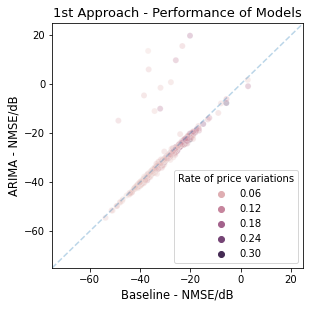

In [ ]:
fontsize = 13
set_fig_size((4.5,4.5))
p1 = plot_repeat_scatter(data = approach_1, x = "repeat_nmse", y = "arima_nmse", hue = "changes_samples_ratio", alpha = 0.3, lim_u = -75, lim_o = 25)
#p1.get_legend().remove()
p1.set_title("1st Approach - Performance of Models", fontsize = fontsize)
p1.set_xlabel("Baseline - NMSE/dB", fontsize = fontsize-1.5)
p1.set_ylabel("ARIMA - NMSE/dB", fontsize = fontsize-1.5)
p1.legend(title="Rate of price variations", loc = "lower right")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "1stApproachPerformance")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_1stApproachFrequencyOfLags.


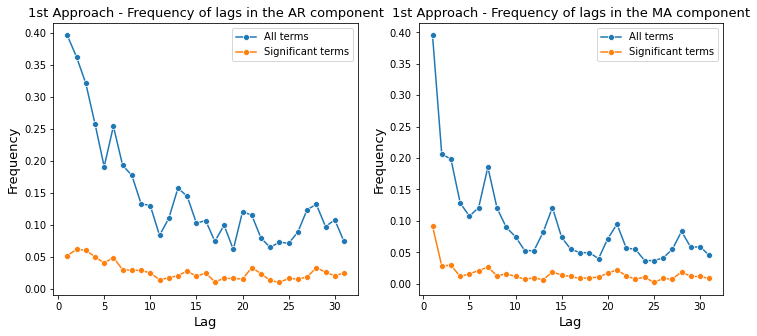

In [ ]:
fontsize = 13

n_subplots = 2
set_fig_size((n_subplots*6, 5))

fig, ax = plt.subplots(1, n_subplots)

columns = list(range(1, len(approach_1.iloc[0]["AR_lags"]) + 1))
AR_lags = pd.DataFrame(list(approach_1.AR_lags.values), columns = columns)
MA_lags = pd.DataFrame(list(approach_1.MA_lags.values), columns = columns)
AR_lags_significant = pd.DataFrame(list(approach_1.AR_lags_significant.values), columns = columns)
MA_lags_significant = pd.DataFrame(list(approach_1.MA_lags_significant.values), columns = columns)

p1 = sns.lineplot(data = AR_lags.mean(), marker = 'o', ax = ax[0])
p1 = sns.lineplot(data = AR_lags_significant.mean(), marker = 'o', ax = ax[0])
p2 = sns.lineplot(data = MA_lags.mean(), marker = 'o', ax = ax[1])
p2 = sns.lineplot(data = MA_lags_significant.mean(), marker = 'o', ax = ax[1])

p1.set_title("1st Approach - Frequency of lags in the AR component", fontsize = fontsize)
p1.set_xlabel("Lag", fontsize = fontsize)
p1.set_ylabel("Frequency", fontsize = fontsize)
p1.legend(labels = ["All terms", "Significant terms"])

p2.set_title("1st Approach - Frequency of lags in the MA component", fontsize = fontsize)
p2.set_xlabel("Lag", fontsize = fontsize)
p2.set_ylabel("Frequency", fontsize = fontsize)
p2.legend(labels = ["All terms", "Significant terms"])

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "1stApproachFrequencyOfLags")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_impactModelSignificancy.


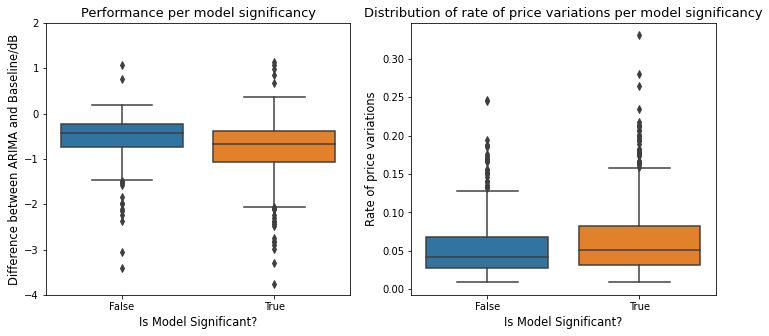

In [ ]:
fontsize = 13

n_subplots = 2
set_fig_size((n_subplots*6, 5))

fig, ax = plt.subplots(1, n_subplots)

p5 = sns.boxplot(data = approach_1, y = "compare_arima_repeat", x = "significant_model", ax = ax[0]);
p5.set(ylim=(-4, 2));
p5.set_title("Performance per model significancy", fontsize = fontsize)
p5.set_xlabel("Is Model Significant?", fontsize = fontsize - 1.5)
p5.set_ylabel("Difference between ARIMA and Baseline/dB", fontsize = fontsize - 1.5)

p6 = sns.boxplot(data = approach_1, x = "significant_model", y = "changes_samples_ratio", ax = ax[1]);
p6.set_title("Distribution of rate of price variations per model significancy", fontsize = fontsize)
p6.set_xlabel("Is Model Significant?", fontsize = fontsize - 1.5)
p6.set_ylabel("Rate of price variations", fontsize = fontsize - 1.5)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "impactModelSignificancy")

Number of models withouth significant coefficients:  387 / 949


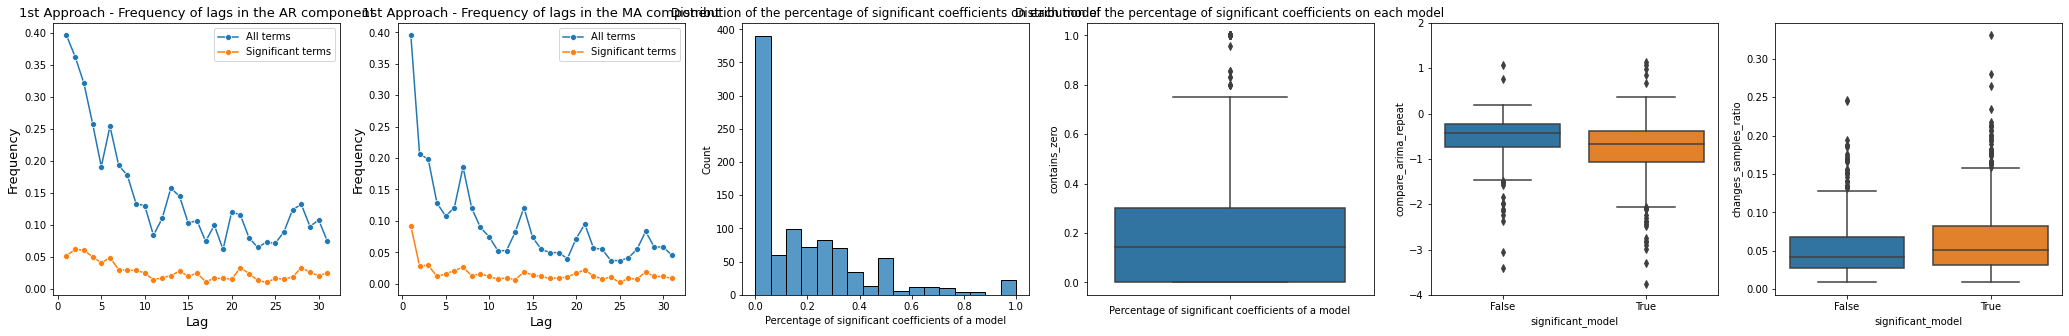

In [ ]:
fontsize = 13

n_subplots = 6
set_fig_size((n_subplots*6, 5))

fig, ax = plt.subplots(1, n_subplots)

columns = list(range(1, len(approach_1.iloc[0]["AR_lags"]) + 1))
AR_lags = pd.DataFrame(list(approach_1.AR_lags.values), columns = columns)
MA_lags = pd.DataFrame(list(approach_1.MA_lags.values), columns = columns)
AR_lags_significant = pd.DataFrame(list(approach_1.AR_lags_significant.values), columns = columns)
MA_lags_significant = pd.DataFrame(list(approach_1.MA_lags_significant.values), columns = columns)

p1 = sns.lineplot(data = AR_lags.mean(), marker = 'o', ax = ax[0])
p1 = sns.lineplot(data = AR_lags_significant.mean(), marker = 'o', ax = ax[0])
p2 = sns.lineplot(data = MA_lags.mean(), marker = 'o', ax = ax[1])
p2 = sns.lineplot(data = MA_lags_significant.mean(), marker = 'o', ax = ax[1])

p1.set_title("1st Approach - Frequency of lags in the AR component", fontsize = fontsize)
p1.set_xlabel("Lag", fontsize = fontsize)
p1.set_ylabel("Frequency", fontsize = fontsize)
p1.legend(labels = ["All terms", "Significant terms"])

p2.set_title("1st Approach - Frequency of lags in the MA component", fontsize = fontsize)
p2.set_xlabel("Lag", fontsize = fontsize)
p2.set_ylabel("Frequency", fontsize = fontsize)
p2.legend(labels = ["All terms", "Significant terms"])

p3 = sns.histplot(data = approach_1.contains_zero, ax = ax[2])
p3.set_title("Distribution of the percentage of significant coefficients on each model")
p3.set_xlabel("Percentage of significant coefficients of a model")

p4 = sns.boxplot(data = approach_1, y = "contains_zero", ax = ax[3])
p4.set_title("Distribution of the percentage of significant coefficients on each model")
p4.set_xlabel("Percentage of significant coefficients of a model")

p5 = sns.boxplot(data = approach_1, y = "compare_arima_repeat", x = "significant_model", ax = ax[4]);
p5.set(ylim=(-4, 2));

p6 = sns.boxplot(data = approach_1, x = "significant_model", y = "changes_samples_ratio", ax = ax[5]);

print("Number of models withouth significant coefficients: ", len(approach_1[approach_1.contains_zero == 0]), "/", len(approach_1))

0.16666666666666663
Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_exampleModelParameters.


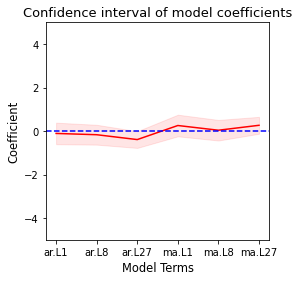

In [ ]:
fontsize = 13

params = approach_1.model_parameters.iloc[34]
print(contains_zero(params))
p1 = display_model_parameters(params, fig_size = (4, 4))
p1.set_title("Confidence interval of model coefficients", fontsize = fontsize)
p1.set_xlabel("Model Terms", fontsize = fontsize-1.5)
p1.set_ylabel("Coefficient", fontsize = fontsize-1.5)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "exampleModelParameters")

It is possible to distinguish three regions in the performance of the models:

- Near the REPEAT model, where the performance of ARIMA is naturally very similar to that of the REPEAT model. When the ARIMA model is slighly better it's the case where ARIMA acts as a low pass filter and is indifferent the sudden changes in the data. However, the number of timeseries where ARIMA is superior is negligible.

In [ ]:
arima_better_repeat = compare_models(approach_1, "arima_nmse", "repeat_nmse", limits = [2, None])
print(len(arima_better_repeat))

28


ARIMA: -24.519136281662984  REPEAT: -22.46561215399828
(1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_exampleARIMABetterBaseline.


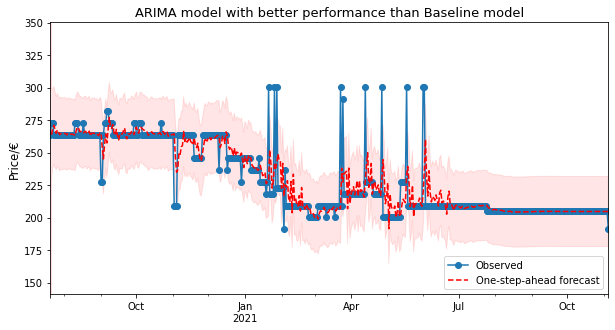

In [ ]:
set_fig_size((7, 5))

fontsize = 13
i = 0
p = display_arima_model(arima_better_repeat, i)
p.set_title("ARIMA model with better performance than Baseline model", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Price/€", fontsize = fontsize -1.5)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "exampleARIMABetterBaseline")

- When the performances of both models are very similar, it correponds naturally to the cases when the ARIMA model behaves almost like the REPEAT model. There may be advantages in sometimes not working just like a REPEAT model, as there can be cases where being a low pass filter is better.

In [ ]:
arima_similar_repeat = compare_models(approach_1, "arima_nmse", "repeat_nmse", limits = [1, 1], in_between = True)
print(len(arima_similar_repeat))

784


ARIMA: -27.75125747767058  REPEAT: -27.014336545173492
(1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0)
(1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0)


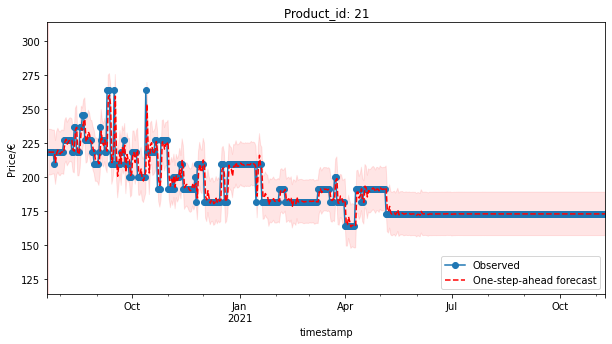

In [ ]:
i = 4
p = display_arima_model(arima_similar_repeat, i)

###### Fill model with fixed number of lags

In [ ]:
arima_lags = [3, 5, 7, 14, 21, 28]
approach_2_all = approach_2_all[approach_2_all.lags.isin(arima_lags)]
approach_2 = approach_2_all.groupby(by = "product_id").apply(lambda df : df[df['arima_nmse'] == df['arima_nmse'].min()]).droplevel(0).reset_index()

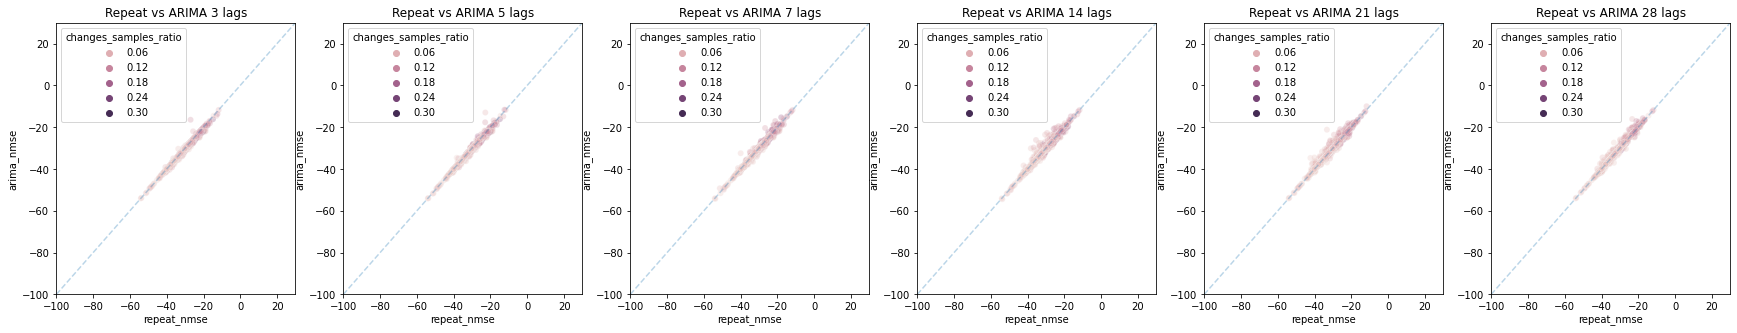

In [ ]:
arima_lags = [3, 5, 7, 14, 21, 28]

set_fig_size((len(arima_lags)*5, 5))
fig, axes = plt.subplots(1,len(arima_lags))

for arima_lag, ax in zip(arima_lags, axes):
  p = plot_repeat_scatter(data = approach_2_all[approach_2_all.lags == arima_lag], x = "repeat_nmse", y = "arima_nmse", hue = "changes_samples_ratio", alpha = 0.3, ax = ax)
  p.set_title("Repeat vs ARIMA " + str(arima_lag) + " lags")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_fixedOrdersPerformances.


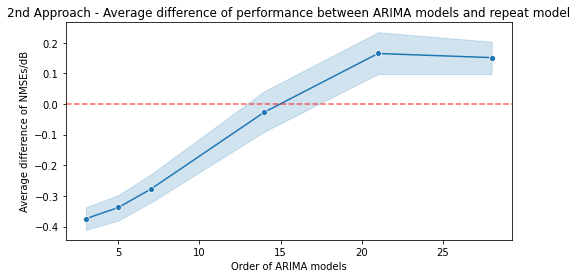

In [ ]:
approach_2_all["changes_samples_ratio_cat"] = pd.cut(approach_2_all["changes_samples_ratio"], bins = [0, 0.15, 1], right = False)

n_subplots = 1
set_fig_size((8*n_subplots, 4))
fig, ax = plt.subplots(1, n_subplots)

p1 = sns.lineplot(data = approach_2_all.reset_index(), x = "lags", y = "compare_arima_repeat", marker = 'o', ax = ax)
p1.axhline(y=0, color='r', linestyle='--', alpha = 0.6, linewidth = 1.5)
p1.set_title("2nd Approach - Average difference of performance between ARIMA models and repeat model")
p1.set_xlabel("Order of ARIMA models")
p1.set_ylabel("Average difference of NMSEs/dB")

# p2 = sns.lineplot(data = approach_2_all.reset_index(), x = "lags", y = "compare_arima_repeat", hue = "changes_samples_ratio_cat", marker = 'o', ax = ax[1])
# p2.axhline(y=0, color='r', linestyle='--', alpha = 0.6, linewidth = 1.5)
# p2.set_title("Average difference of performance between ARIMA models and repeat model")
# p2.set_xlabel("Nº of fixed lags of ARIMA models")
# p2.set_ylabel("Average difference of NMSEs/dB")
# p2.legend(title='Ratio of price changes')

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "fixedOrdersPerformances")

Os modelos com lags maiores reajam mais lentamente às mudanças e é por isso normal que a sua performance decresça quando comparado com o repeat model. As séries com mais mudanças benefeciam ligeiramente da utilização do modelo ARIMA pois este atua nalgumas situação como filtro passa-baixo. Dado que o ARIMA é uma espécie de modelo Naive mais complexo, faz sentido que haja esta pequena melhoria de performance.

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_2ndApproachAnalysisOfBestModels.


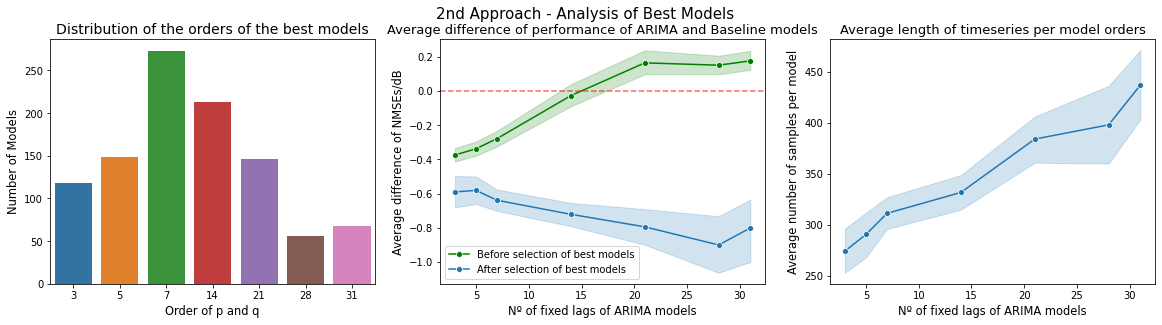

In [ ]:
fontsize = 13

n_subplots = 3
set_fig_size((6.6*n_subplots, 4.5))
fig, ax = plt.subplots(1, n_subplots)

fig.suptitle("2nd Approach - Analysis of Best Models", fontsize = fontsize + 2)

p1 = sns.countplot(data = approach_2, x = "lags", ax = ax[0])
p1.set_title("Distribution of the orders of the best models", fontsize = fontsize+1)
p1.set_xlabel("Order of p and q", fontsize = fontsize - 1.5)
p1.set_ylabel("Number of Models", fontsize = fontsize - 1.5)

p2 = sns.lineplot(data = approach_2_all.reset_index(), x = "lags", y = "compare_arima_repeat", color = "green", marker = 'o', ax = ax[1], label = "Before selection of best models")
p2 = sns.lineplot(data = approach_2, x = "lags", y = "compare_arima_repeat", marker = 'o', ax = ax[1], label = "After selection of best models")
p2.axhline(y=0, color='r', linestyle='--', alpha = 0.6, linewidth = 1.5)
p2.set_title("Average difference of performance of ARIMA and Baseline models", fontsize = fontsize)
p2.set_xlabel("Nº of fixed lags of ARIMA models", fontsize = fontsize - 1.5)
p2.set_ylabel("Average difference of NMSEs/dB", fontsize = fontsize - 1.5);

p3 = sns.lineplot(data = approach_2, x = "lags", y = "n_samples", marker = 'o', ax = ax[2])
p3.set_title("Average length of timeseries per model orders", fontsize = fontsize)
p3.set_xlabel("Nº of fixed lags of ARIMA models", fontsize = fontsize - 1.5)
p3.set_ylabel("Average number of samples per model", fontsize = fontsize - 1.5);

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "2ndApproachAnalysisOfBestModels")

In [ ]:
lags = [21, 14, 7, 5, 3]
approach_2_up_to_21 = approach_2_all[approach_2_all.lags.isin(lags)]

print("Decrease in performance if not considering lag 28: ", round(approach_2.compare_arima_repeat.mean() - approach_2_up_to_21.compare_arima_repeat.mean(), 2))

Decrease in performance if not considering lag 28:  -0.51


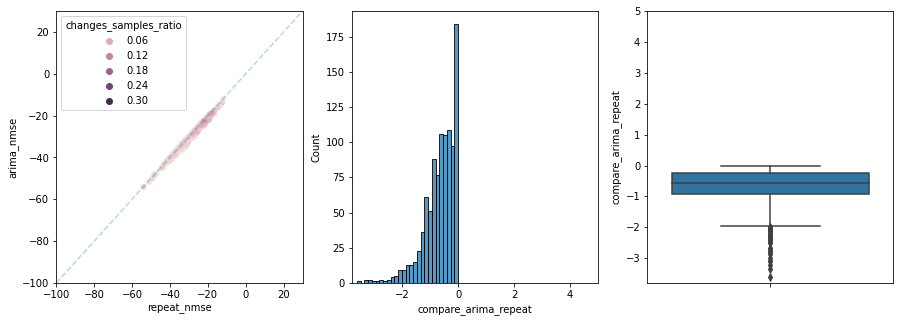

In [ ]:
n_subplots = 3
set_fig_size((n_subplots*5, 5))
fig, ax = plt.subplots(1, n_subplots)

p1 = plot_repeat_scatter(data = approach_2, x = "repeat_nmse", y = "arima_nmse", hue = "changes_samples_ratio", alpha = 0.3, ax = ax[0])
p2 = sns.histplot(data = approach_2, x = "compare_arima_repeat", ax = ax[1]);
p2.set(xlim=(None, 5));
p3 = sns.boxplot(data = approach_2, y = "compare_arima_repeat", ax = ax[2]);
p3.set(ylim=(None, 5));

Number of models withouth significant coefficients:  907 / 1023


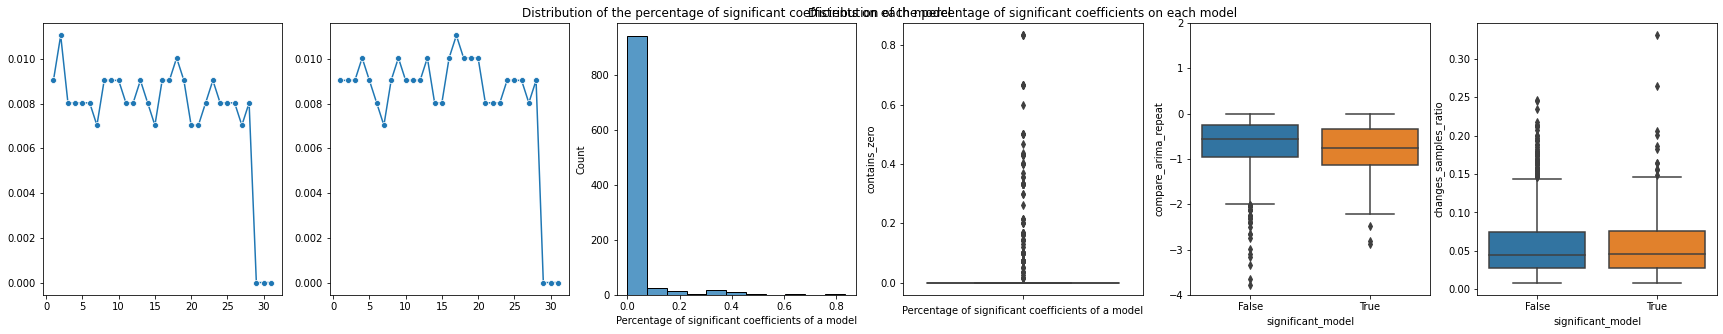

In [ ]:
n_subplots = 6
set_fig_size((n_subplots*5, 5))

fig, ax = plt.subplots(1, n_subplots)

a = approach_2_all[approach_2_all.lags == 28]
columns = list(range(1, 31+1))
AR_lags_significant = pd.DataFrame(list(a.AR_lags_significant.values), columns = columns)
MA_lags_significant = pd.DataFrame(list(a.MA_lags_significant.values), columns = columns)

p1 = sns.lineplot(data = AR_lags_significant.mean(), marker = 'o', ax = ax[0])
p2 = sns.lineplot(data = MA_lags_significant.mean(), marker = 'o', ax = ax[1])

p3 = sns.histplot(data = approach_2.contains_zero, ax = ax[2])
p3.set_title("Distribution of the percentage of significant coefficients on each model")
p3.set_xlabel("Percentage of significant coefficients of a model")

p4 = sns.boxplot(data = approach_2, y = "contains_zero", ax = ax[3])
p4.set_title("Distribution of the percentage of significant coefficients on each model")
p4.set_xlabel("Percentage of significant coefficients of a model")

p5 = sns.boxplot(data = approach_2, y = "compare_arima_repeat", x = "significant_model", ax = ax[4]);
p5.set(ylim=(-4, 2));

p6 = sns.boxplot(data = approach_2, x = "significant_model", y = "changes_samples_ratio", ax = ax[5]);

print("Number of models withouth significant coefficients: ", len(approach_2[approach_2.contains_zero == 0]), "/", len(approach_2))

Number of series that are noise:  827 / 1023


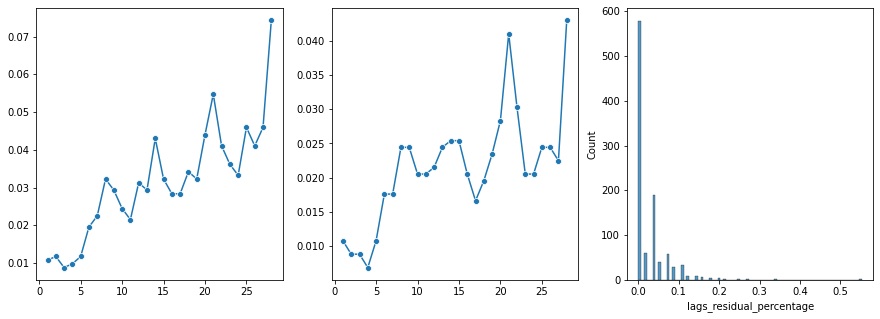

In [ ]:
n_subplots = 3
set_fig_size((n_subplots*5, 5))

fig, ax = plt.subplots(1, n_subplots)

columns = list(range(1, 28 + 1))
AR_lags_residuals = pd.DataFrame(list(approach_2.AR_lags_residual.values), columns = columns)
MA_lags_residuals = pd.DataFrame(list(approach_2.MA_lags_residual.values), columns = columns)

p1 = sns.lineplot(data = AR_lags_residuals.mean(), marker = 'o', ax = ax[0])
p2 = sns.lineplot(data = MA_lags_residuals.mean(), marker = 'o', ax = ax[1])

p3 = sns.histplot(data = approach_2, x = "lags_residual_percentage", ax = ax[2])

print("Number of series that are noise: ", len(approach_2[approach_2["lags_residual_percentage"] < 0.05]), "/", len(approach_2))

###### Auto-ARIMA

In [ ]:
# Check if both modes of stepwise produced the same types of models 
compare_stepwise1 = approach_3_all.groupby(by = "product_id")[["MA_order",	"AR_order"]].apply(lambda df : df.nunique() <= 1)
compare_stepwise1["same_model"] = compare_stepwise1["MA_order"] & compare_stepwise1["AR_order"]
compare_stepwise1["same_model"].value_counts()

False    546
True     492
Name: same_model, dtype: int64

In [ ]:
approach_3["sum_orders"] = (approach_3["MA_order"] + approach_3["AR_order"]) == approach_3["max_order"]
approach_3["sum_orders"].value_counts()

False    794
True     218
Name: sum_orders, dtype: int64

In [ ]:
approach_3_all.groupby(by ="stepwise")["arima_nmse"].mean()

stepwise
False   -31.009052
True    -30.873559
Name: arima_nmse, dtype: float64

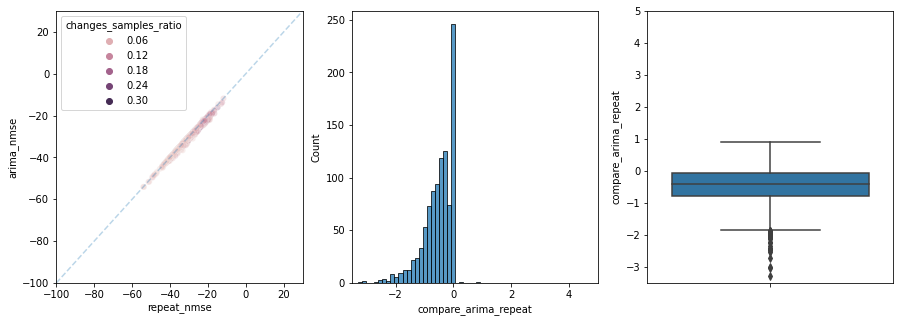

In [ ]:
n_subplots = 3
set_fig_size((n_subplots*5, 5))
fig, ax = plt.subplots(1, n_subplots)

p1 = plot_repeat_scatter(data = approach_3, x = "repeat_nmse", y = "arima_nmse", hue = "changes_samples_ratio", alpha = 0.3, ax = ax[0])
p2 = sns.histplot(data = approach_3, x = "compare_arima_repeat", ax = ax[1]);
p2.set(xlim=(None, 5));
p3 = sns.boxplot(data = approach_3, y = "compare_arima_repeat", ax = ax[2]);
p3.set(ylim=(None, 5));

Number of models withouth significant coefficients:  10 / 1012


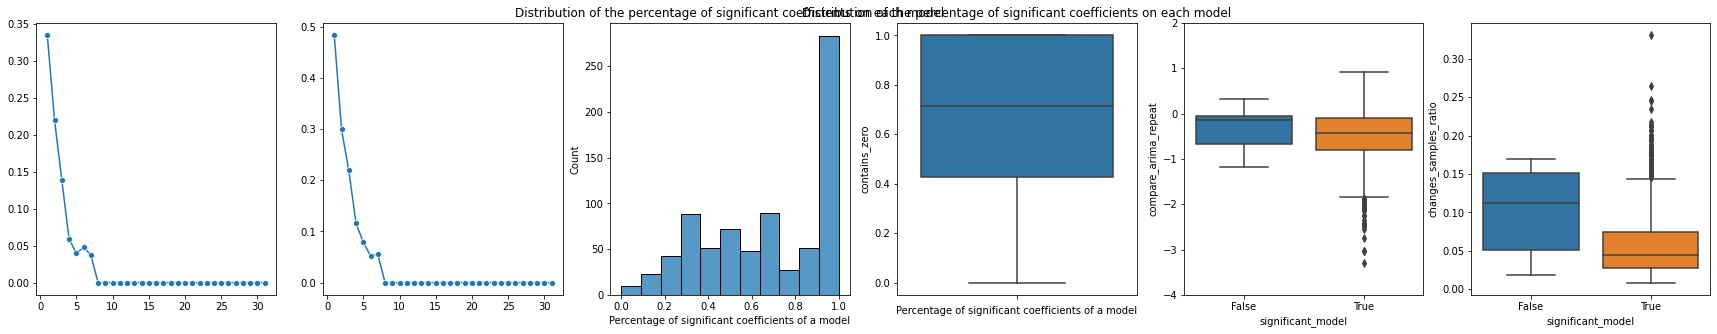

In [ ]:
n_subplots = 6
set_fig_size((n_subplots*5, 5))

fig, ax = plt.subplots(1, n_subplots)

columns = list(range(1, 32))
AR_lags_significant = pd.DataFrame(list(approach_3.AR_lags_significant.values), columns = columns)
MA_lags_significant = pd.DataFrame(list(approach_3.MA_lags_significant.values), columns = columns)

p1 = sns.lineplot(data = AR_lags_significant.mean(), marker = 'o', ax = ax[0])
p2 = sns.lineplot(data = MA_lags_significant.mean(), marker = 'o', ax = ax[1])

p3 = sns.histplot(data = approach_3.contains_zero, ax = ax[2])
p3.set_title("Distribution of the percentage of significant coefficients on each model")
p3.set_xlabel("Percentage of significant coefficients of a model")

p4 = sns.boxplot(data = approach_3, y = "contains_zero", ax = ax[3])
p4.set_title("Distribution of the percentage of significant coefficients on each model")
p4.set_xlabel("Percentage of significant coefficients of a model")

p5 = sns.boxplot(data = approach_3, y = "compare_arima_repeat", x = "significant_model", ax = ax[4]);
p5.set(ylim=(-4, 2));

p6 = sns.boxplot(data = approach_3, x = "significant_model", y = "changes_samples_ratio", ax = ax[5]);

print("Number of models withouth significant coefficients: ", len(approach_3[approach_3.contains_zero == 0]), "/", len(approach_3))

Number of series that are noise:  550 / 1012


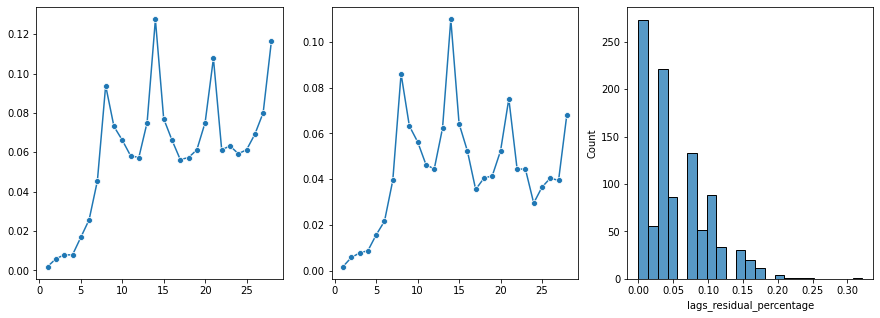

In [ ]:
n_subplots = 3
set_fig_size((n_subplots*5, 5))

fig, ax = plt.subplots(1, n_subplots)

columns = list(range(1, 28 + 1))
AR_lags_residuals = pd.DataFrame(list(approach_3.AR_lags_residual.values), columns = columns)
MA_lags_residuals = pd.DataFrame(list(approach_3.MA_lags_residual.values), columns = columns)

p1 = sns.lineplot(data = AR_lags_residuals.mean(), marker = 'o', ax = ax[0])
p2 = sns.lineplot(data = MA_lags_residuals.mean(), marker = 'o', ax = ax[1])

p3 = sns.histplot(data = approach_3, x = "lags_residual_percentage", ax = ax[2])

print("Number of series that are noise: ", len(approach_3[approach_3["lags_residual_percentage"] < 0.05]), "/", len(approach_3))

###### Conjoined analysis of the three approaches

Performance

In [ ]:
index_all = approach_1.index.intersection(approach_2.set_index("product_id").index).intersection(approach_3.index)
columns = ["arima_nmse", "contains_zero", "n_changes",	"n_samples", "changes_samples_ratio",	"repeat_nmse", "compare_arima_repeat", "significant_model", "product_id", "obs", "pred", "pred_repeat", "lags_residual_percentage"]

approach_1_flt = approach_1.loc[index_all].reset_index()[columns]
approach_1_flt = approach_1_flt[approach_1_flt.compare_arima_repeat < 5]

approach_2_flt = approach_2.set_index("product_id").loc[index_all].reset_index()[columns]

approach_3_flt = approach_3.loc[index_all].reset_index()[columns]

approaches = pd.concat([approach_1_flt, approach_2_flt, approach_3_flt], keys = [1, 2, 3]).reset_index().drop("level_1", axis = 1).rename(columns={"level_0": "approach"})

In [ ]:
approach_1_flt_all_preds = pd.concat(approach_1_flt.set_index("product_id").apply(get_all_predictions, axis = 1).values)
approach_2_flt_all_preds = pd.concat(approach_2_flt.set_index("product_id").apply(get_all_predictions, axis = 1).values)
approach_3_flt_all_preds = pd.concat(approach_3_flt.set_index("product_id").apply(get_all_predictions, axis = 1).values)

In [ ]:
approach_1_flt_all_preds["pred_sample_nmse"]   = approach_1_flt_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred"]), axis = 1)
approach_1_flt_all_preds["repeat_sample_nmse"] = approach_1_flt_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred_repeat"]), axis = 1)
approach_1_flt_all_preds["compare_pred_repeat_sample"] = approach_1_flt_all_preds["pred_sample_nmse"] - approach_1_flt_all_preds["repeat_sample_nmse"]
approach_1_flt_all_preds = approach_1_flt_all_preds[(approach_1_flt_all_preds.compare_pred_repeat_sample < 1) & (approach_1_flt_all_preds.compare_pred_repeat_sample > -1)]

approach_2_flt_all_preds["pred_sample_nmse"]   = approach_2_flt_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred"]), axis = 1)
approach_2_flt_all_preds["repeat_sample_nmse"] = approach_2_flt_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred_repeat"]), axis = 1)
approach_2_flt_all_preds["compare_pred_repeat_sample"] = approach_2_flt_all_preds["pred_sample_nmse"] - approach_2_flt_all_preds["repeat_sample_nmse"]
approach_2_flt_all_preds = approach_2_flt_all_preds[(approach_2_flt_all_preds.compare_pred_repeat_sample < 1) & (approach_2_flt_all_preds.compare_pred_repeat_sample > -1)]

approach_3_flt_all_preds["pred_sample_nmse"]   = approach_3_flt_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred"]), axis = 1)
approach_3_flt_all_preds["repeat_sample_nmse"] = approach_3_flt_all_preds.apply(lambda row : get_nmse_sample(row["obs"], row["pred_repeat"]), axis = 1)
approach_3_flt_all_preds["compare_pred_repeat_sample"] = approach_3_flt_all_preds["pred_sample_nmse"] - approach_3_flt_all_preds["repeat_sample_nmse"]
approach_3_flt_all_preds = approach_3_flt_all_preds[(approach_3_flt_all_preds.compare_pred_repeat_sample < 1) & (approach_3_flt_all_preds.compare_pred_repeat_sample > -1)]

approaches_all_preds = pd.concat([approach_1_flt_all_preds, approach_2_flt_all_preds, approach_3_flt_all_preds], keys = [1, 2, 3]).reset_index().drop("level_1", axis = 1).rename(columns={"level_0": "approach"})

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_allAproachesPerformanceComparison.


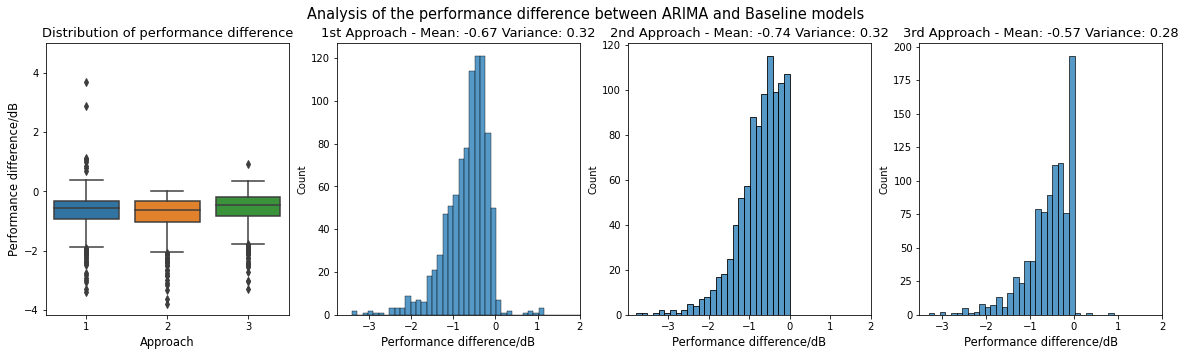

In [ ]:
fontsize = 13

n_subplots = 4
set_fig_size((5*n_subplots, 5))
fig, ax = plt.subplots(1, n_subplots)

plt.suptitle("Analysis of the performance difference between ARIMA and Baseline models", fontsize = fontsize + 1.5)

p1 = sns.boxplot(data = approaches, x = "approach", y = "compare_arima_repeat", ax = ax[0]);
p1.set_title("Distribution of performance difference", fontsize = fontsize)
p1.set_ylabel("Performance difference/dB", fontsize = fontsize-1.5)
p1.set_xlabel("Approach", fontsize = fontsize-1.5)
p1.set(ylim=(None, 5))

p2 = sns.histplot(data = approach_1_flt.reset_index(), x = "compare_arima_repeat", ax = ax[1])
p2.set_title("1st Approach - Mean: " + str(round(np.mean(approach_1_flt.compare_arima_repeat),2)) + " Variance: " + str(round(np.var(approach_1_flt.compare_arima_repeat-np.mean(approach_1_flt.compare_arima_repeat)),2)), fontsize = fontsize)
p2.set_xlabel("Performance difference/dB", fontsize = fontsize-1.5)
p2.set(xlim=(None, 2))

p3 = sns.histplot(data = approach_2_flt.reset_index(), x = "compare_arima_repeat", ax = ax[2])
p3.set_title("2nd Approach - Mean: " + str(round(np.mean(approach_2_flt.compare_arima_repeat),2)) + " Variance: " + str(round(np.var(approach_2_flt.compare_arima_repeat-np.mean(approach_2_flt.compare_arima_repeat)),2)), fontsize = fontsize)
p3.set_xlabel("Performance difference/dB", fontsize = fontsize-1.5)
p3.set(xlim=(None, 2))

p4 = sns.histplot(data = approach_3_flt.reset_index(), x = "compare_arima_repeat", ax = ax[3])
p4.set_title("3rd Approach - Mean: " + str(round(np.mean(approach_3_flt.compare_arima_repeat),2)) + " Variance: " + str(round(np.var(approach_3_flt.compare_arima_repeat-np.mean(approach_3_flt.compare_arima_repeat)),2)), fontsize = fontsize)
p4.set_xlabel("Performance difference/dB", fontsize = fontsize-1.5)
p4.set(xlim=(None, 2))

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "allAproachesPerformanceComparison")

In [ ]:
data1 = list(approach_1_flt.compare_arima_repeat)
data2 = list(approach_2_flt.compare_arima_repeat)
data3 = list(approach_3_flt.compare_arima_repeat)

print("ANOVA: ",f_oneway(data1, data2, data3))
print("Kruskal-Wallis: ", stats.kruskal(data1, data2, data3))

ANOVA:  F_onewayResult(statistic=21.736922196205988, pvalue=4.284778973702751e-10)
Kruskal-Wallis:  KruskalResult(statistic=61.43673095407916, pvalue=4.562295175578781e-14)


Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_multipleComparisonsTukey.


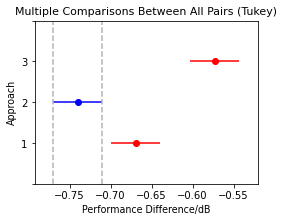

In [ ]:
fontsize = 11
mc = MultiComparison(approaches.compare_arima_repeat, approaches.approach, group_order=None).tukeyhsd()
mc.summary()

mc.plot_simultaneous(comparison_name = 2, figsize = (4, 3), xlabel = "Performance Difference/dB", ylabel="Approach")
plt.title("Multiple Comparisons Between All Pairs (Tukey)", fontsize = fontsize)
plt.xlabel("Performance Difference/dB", fontsize = fontsize - 1.5)
plt.ylabel("Approach", fontsize = fontsize-1.5)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "multipleComparisonsTukey")

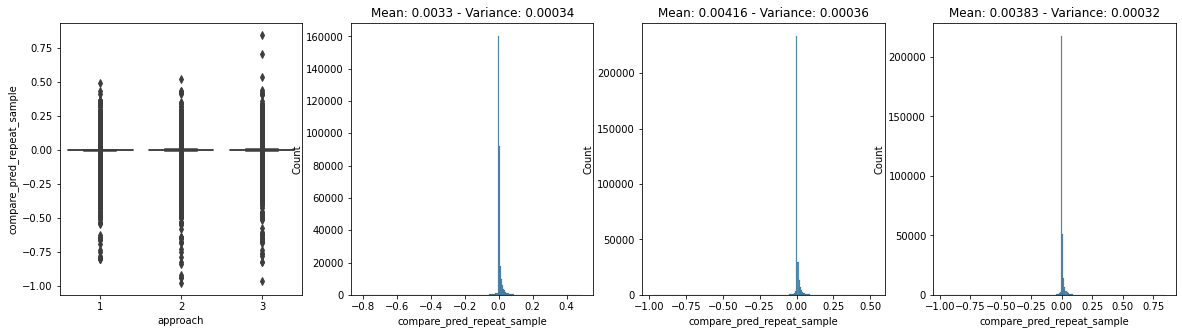

In [ ]:
set_fig_size((20, 5))
fig, ax = plt.subplots(1, 4)

p1 = sns.boxplot(data = approaches_all_preds, x = "approach", y = "compare_pred_repeat_sample", ax = ax[0])

p2 =sns.histplot(data = approach_1_flt_all_preds.reset_index(), x = "compare_pred_repeat_sample", bins = 200, ax = ax[1])
p2.set_title("Mean: " + str(round(np.mean(approach_1_flt_all_preds.compare_pred_repeat_sample),5)) + " - Variance: " + str(round(np.var(approach_1_flt_all_preds.compare_pred_repeat_sample-np.mean(approach_1_flt_all_preds.compare_pred_repeat_sample)),5)))

p3 = sns.histplot(data = approach_2_flt_all_preds.reset_index(), x = "compare_pred_repeat_sample", bins = 200, ax = ax[2])
p3.set_title("Mean: " + str(round(np.mean(approach_2_flt_all_preds.compare_pred_repeat_sample),5)) + " - Variance: " + str(round(np.var(approach_2_flt_all_preds.compare_pred_repeat_sample-np.mean(approach_2_flt_all_preds.compare_pred_repeat_sample)),5)))

p4 = sns.histplot(data = approach_3_flt_all_preds.reset_index(), x = "compare_pred_repeat_sample", bins = 200, ax = ax[3])
p4.set_title("Mean: " + str(round(np.mean(approach_3_flt_all_preds.compare_pred_repeat_sample),5)) + " - Variance: " + str(round(np.var(approach_3_flt_all_preds.compare_pred_repeat_sample-np.mean(approach_3_flt_all_preds.compare_pred_repeat_sample)),5)));

In [ ]:
data1 = list(approach_1_flt_all_preds.compare_pred_repeat_sample)
data2 = list(approach_2_flt_all_preds.compare_pred_repeat_sample)
data3 = list(approach_3_flt_all_preds.compare_pred_repeat_sample)

print(stats.kruskal(data1, data2, data3))
print(f_oneway(data1, data2, data3))

KruskalResult(statistic=56102.512161955965, pvalue=0.0)
F_onewayResult(statistic=169.35662817666585, pvalue=2.902670958073624e-74)


<class 'statsmodels.iolib.table.SimpleTable'>

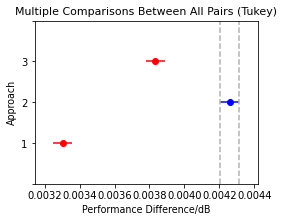

In [ ]:
fontsize = 11
mc = MultiComparison(approaches_all_preds.compare_pred_repeat_sample, approaches_all_preds.approach, group_order=None).tukeyhsd()

mc.plot_simultaneous(comparison_name = 2, figsize = (4, 3), xlabel = "Performance Difference/dB", ylabel="Approach")
plt.title("Multiple Comparisons Between All Pairs (Tukey)", fontsize = fontsize)
plt.xlabel("Performance Difference/dB", fontsize = fontsize - 1.5)
plt.ylabel("Approach", fontsize = fontsize-1.5)
mc.summary()

Dunn's test

In [ ]:
data1 = list(approach_1_flt_all_preds.compare_pred_repeat_sample)
data2 = list(approach_2_flt_all_preds.compare_pred_repeat_sample)
data3 = list(approach_3_flt_all_preds.compare_pred_repeat_sample)
sp.posthoc_dunn([data1, data2, data3], p_adjust = 'holm')

1    2    3
1  1.0  0.0  0.0
2  0.0  1.0  0.0
3  0.0  0.0  1.0

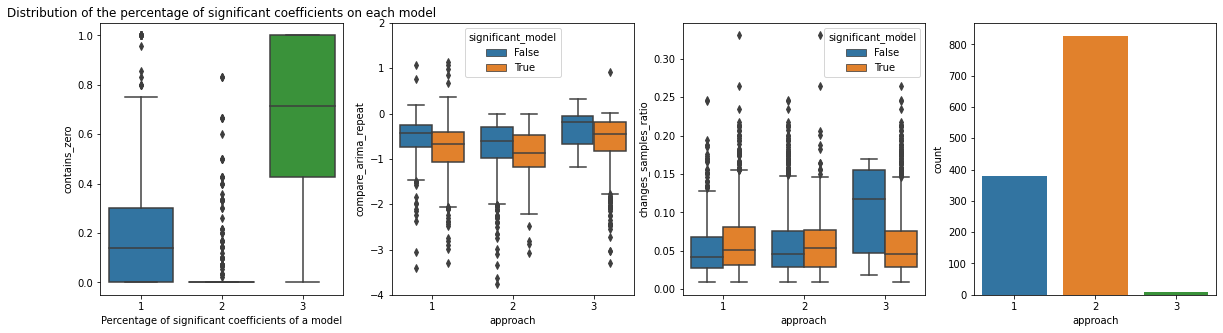

In [ ]:
n_subplots = 4
set_fig_size((n_subplots*5, 5))

fig, ax = plt.subplots(1, n_subplots)

p1 = sns.boxplot(data = approaches, x = "approach", y = "contains_zero", ax = ax[0])
p1.set_title("Distribution of the percentage of significant coefficients on each model")
p1.set_xlabel("Percentage of significant coefficients of a model")

p2 = sns.boxplot(data = approaches, y = "compare_arima_repeat", x = "approach", hue = "significant_model", ax = ax[1]);
p2.set(ylim=(-4, 2));

p3 = sns.boxplot(data = approaches, x = "approach", y = "changes_samples_ratio", hue = "significant_model", ax = ax[2]);

p4 = sns.countplot(data = approaches[approaches.contains_zero == 0], x = "approach", ax = ax[3])
#print("Number of models withouth significant coefficients: ", len(approach_3[approach_3.contains_zero == 0]), "/", len(approach_3))

In [ ]:
approaches_w_repeat = approaches[approaches.approach == 1].copy()
approaches_w_repeat.approach = "Baseline"
approaches_w_repeat["pred"] = approaches_w_repeat["pred_repeat"]
residuals = pd.DataFrame(list(approaches_w_repeat.apply(residual_analysis, axis = 1)))
residuals.index = approaches_w_repeat.index
approaches_w_repeat[["MA_lags_residual", "AR_lags_residual"]] = residuals
approaches_w_repeat["lags_residual_percentage"] = (approaches_w_repeat["MA_lags_residual"].apply(np.mean) + approaches_w_repeat["AR_lags_residual"].apply(np.mean))/2

approaches_w_repeat = pd.concat([approaches, approaches_w_repeat])#, approaches_w_obs])
#approaches_w_repeat

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_allApproachesResidualAnalysis.


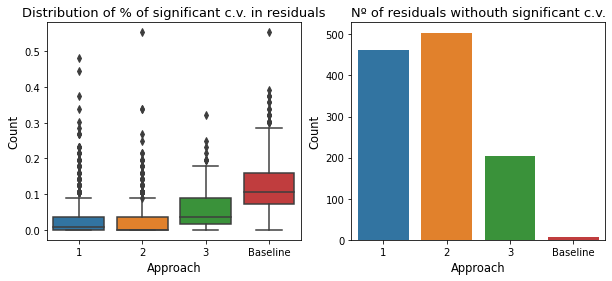

In [ ]:
fontsize = 13

n_subplots = 2
set_fig_size((n_subplots*5, 4))

fig, ax = plt.subplots(1, n_subplots)

p1 = sns.boxplot(data = approaches_w_repeat, x = "approach", y = "lags_residual_percentage", ax = ax[0])
p1.set_title("Distribution of % of significant c.v. in residuals", fontsize = fontsize)
p1.set_xlabel("Approach", fontsize = fontsize - 1.5)
p1.set_ylabel("Count", fontsize = fontsize - 1.5)

p2 = sns.countplot(data = approaches_w_repeat[approaches_w_repeat["lags_residual_percentage"] == 0], x = "approach", ax = ax[1])
p2.set_title("Nº of residuals withouth any significant c.v.", fontsize = fontsize)
p2.set_xlabel("Approach", fontsize = fontsize - 1.5)
p2.set_ylabel("Count", fontsize = fontsize - 1.5)

# tmp = (approach_1_all_preds["pred"]-approach_1_all_preds["obs"])/approach_1_all_preds["obs"]
# tmp = tmp[(tmp < 0.5) & (tmp > -0.5)]
# p = sns.histplot(data = tmp, bins = 1000, ax = ax[2])
# p.set(xlim=(-0.02, 0.02));

# tmp = (approach_2_all_preds["pred"]-approach_2_all_preds["obs"])/approach_2_all_preds["obs"]
# tmp = tmp[(tmp < 0.5) & (tmp > -0.5)]
# p = sns.histplot(data = tmp, bins = 1000, ax = ax[3])
# p.set(xlim=(-0.02, 0.02));

# tmp = (approach_3_all_preds["pred"]-approach_3_all_preds["obs"])/approach_3_all_preds["obs"]
# tmp = tmp[(tmp < 0.5) & (tmp > -0.5)]
# p = sns.histplot(data = tmp, bins = 1000, ax = ax[4])
# p.set(xlim=(-0.02, 0.02));

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "allApproachesResidualAnalysis")

##### ARIMA with cross-validation

In [ ]:
def get_df_p(row):

  y_obs = pd.DataFrame(row["obs"])
  y_pred = []
  for pred_7 in list(row["pred_7"]):
    y_pred.append(pd.DataFrame(pred_7).join(y_obs))  

  df_p = pd.concat(y_pred)
  df_p["horizon_int"] = np.tile(range(1,8), int(len(df_p)/7))
  df_p.columns = ["yhat", "y", "horizon_int"]
  df_p = df_p.dropna()
  size = df_p.groupby(by = "horizon_int").size()
  df_p = df_p.groupby(by = "horizon_int")[["y", "yhat"]].apply(lambda x : get_nmse(x["y"], x["yhat"]))
  df_p = pd.DataFrame(df_p)
  df_p["size"] = size
  df_p.columns = ["nmse", "size"]
  return df_p

In [ ]:
# results_cv = []
# for count in range(1, 42):
#   print(count)
#   results_cv.append(pd.read_pickle("arima_results_nm_25_iter_fill_interpolation_cross_validation_best_approach_all_" + str(count)))

#approach_2_cv = pd.concat(results_cv).drop("optimization_method", axis = 1).reset_index(drop = True)
#approach_2_cv.to_pickle("arima_results_nm_25_iter_fill_interpolation_cross_validation_best_approach_all")

In [ ]:
approach_2_cv = pd.read_pickle("arima_results_nm_25_iter_fill_interpolation_cross_validation_best_approach_all").dropna()
approach_2_cv = approach_2_cv[approach_2_cv.metric_total > -500]

In [ ]:
approach_2_pred_7 = pd.concat(list(approach_2_cv.apply(get_df_p, axis = 1)))
print("Number of infs: ", len(approach_2_pred_7[approach_2_pred_7.nmse < -500]))
approach_2_pred_7 = approach_2_pred_7[approach_2_pred_7.nmse > -500]

Number of infs:  0


In [ ]:
# Get nmse evolution with the number of days
def performance_metrics_self(df_cv):
  df_cv = df_cv.copy()
  df_cv["horizon"] = df_cv["ds"] - df_cv["cutoff"]
  df_cv["horizon_int"] = df_cv["horizon"].apply(lambda horizon: horizon.days)
  df_p = df_cv.groupby(by = "horizon")[["y", "yhat"]].apply(lambda x : get_nmse(x["y"], x["yhat"]))
  df_p = pd.DataFrame(df_p)
  df_p.columns = ["nmse"]
  df_p["n_samples_in_horizon"] = df_cv.groupby(by = "horizon").size()
  
  if "yhat_upper" in df_cv.columns:
    df_p["conf_int_width"] = df_cv.groupby(by = "horizon")[["yhat_lower", "yhat_upper"]].apply(lambda x : np.mean(x["yhat_upper"] - x["yhat_lower"]))
    df_p["conf_int_width_normalized"] = df_cv.groupby(by = "horizon")[["y", "yhat_lower", "yhat_upper"]].apply(lambda x : np.mean((x["yhat_upper"] - x["yhat_lower"])/np.mean(x["y"])))
  
  df_p = df_p.reset_index()

  df_p["horizon_int"] = df_p["horizon"].apply(lambda horizon: horizon.days)
  
  return df_p

# Get df_cv for repeat model
def repeat_cross_validation(timeseries, initial, period, horizon):
  
  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    repeat_value = timeseries.iloc[i-1]
    obs = timeseries.iloc[i:i+horizon]
    pred = np.ones(len(obs))*repeat_value

    result = {"y" : obs,
              "yhat" : pred,
              "ds" : obs.index,
              "cutoff": timeseries.index[i-1]}
    
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)

In [ ]:
count = 0
period = 1
horizon = 7
all_info_repeat = []

product_id_lst = list(approach_2_cv.product_id)

for product_id in product_id_lst:

  count = count+1  
  print(str(count) + "/" + str(len(product_id_lst)))

  timeseries = approach_2_cv.set_index("product_id").loc[product_id].obs
  initial = int(len(timeseries)*0.4)
  if initial > 30: 
    df_cv = repeat_cross_validation(timeseries, initial, period, horizon)
    df_p  = performance_metrics_self(df_cv)

    info = {"product_id": product_id,
            "performance_metrics": df_p,
            "cross_validation_results": df_cv,
            "cross_validation_initial": initial,
            "cross_validation_horizon": horizon}

    all_info_repeat.append(info)

all_info_repeat = pd.DataFrame(all_info_repeat)
all_info_repeat.to_pickle("arima_repeat_horizon_" + str(horizon))

In [ ]:
repeat_pred = pd.read_pickle("arima_repeat_horizon_7")
list(repeat_pred.performance_metrics)
repeat_pred_all = pd.concat(list(repeat_pred.performance_metrics))[["horizon_int", "nmse"]].set_index("horizon_int")
repeat_pred_all = repeat_pred_all[repeat_pred_all.nmse > -500]

Dissertação/Chapters/Imagens/Chapter_ArticleDETI/articledeti_arima_7DayForecast.


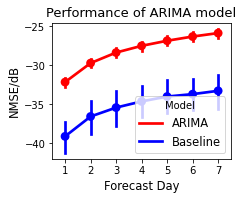

In [ ]:
fontsize = 13
set_fig_size((3.2,2.5))
fig, ax = plt.subplots(1)
p = sns.pointplot(data = approach_2_pred_7, x = approach_2_pred_7.index, y = "nmse", ax = ax, color = "blue", label = "ARIMA")
p = sns.pointplot(data = repeat_pred_all, x = repeat_pred_all.index, y = "nmse", ax = ax, color = "red", label = "Baseline")
p.set_title("Performance of ARIMA model", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.legend(title = "Model", labels = ["ARIMA", "Baseline"], fontsize = fontsize - 1.5)
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')

save_fig(plt, chapter_name = "ArticleDETI", section_name = "arima", name_of_fig = "7DayForecast")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_crossValidation2ndApproachARIMABaseline.


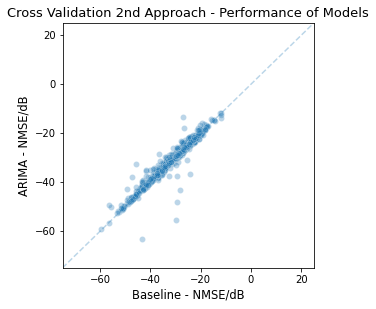

In [ ]:
fontsize = 13
set_fig_size((4.5,4.5))
p1 = plot_repeat_scatter(data = approach_2_cv, x = "baseline_metric", y = "metric_total", hue = None, alpha = 0.3, lim_u = -75, lim_o = 25)
#p1.get_legend().remove()
p1.set_title("Cross Validation 2nd Approach - Performance of Models", fontsize = fontsize)
p1.set_xlabel("Baseline - NMSE/dB", fontsize = fontsize-1.5)
p1.set_ylabel("ARIMA - NMSE/dB", fontsize = fontsize-1.5)

save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "crossValidation2ndApproachARIMABaseline")

In [ ]:
approach_2_cv = approach_2_cv[approach_2_cv.baseline_metric > -100]
approach_2_cv["compare_arima_repeat"] = approach_2_cv["metric_total"] - approach_2_cv["baseline_metric"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_arima_approach2CrossValidation.


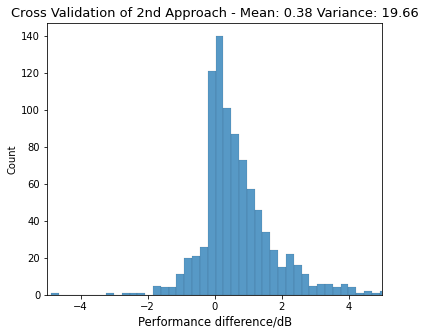

In [ ]:
fontsize = 13
p1 = sns.histplot(data = approach_2_cv, x = "compare_arima_repeat")
p1.set_title("Cross Validation of 2nd Approach - Mean: " + str(round(np.mean(approach_2_cv.compare_arima_repeat),2)) + " Variance: " + str(round(np.var(approach_2_cv.compare_arima_repeat-np.mean(approach_1_flt.compare_arima_repeat)),2)), fontsize = fontsize)
p1.set_xlabel("Performance difference/dB", fontsize = fontsize-1.5)
p1.set(xlim=(-5, 5))

save_fig(plt, chapter_name = "Prediction", section_name = "arima", name_of_fig = "approach2CrossValidation")